In [1]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.torch_generic_model_training import train_model_with_cv
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
from lib.binary_classification import to_binary
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [4]:
dataset_raw_train, dataset_raw_test = split(NumpyDataset(data_raw, labels), test_size_pct=0.2, seed=6942066)

### Create sequences

In [5]:
sequences_ds_train = combine_birds(
    dataset_raw_train, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_train.data.shape   = }')
print(f'{sequences_ds_train.labels.shape = }\n\n')


sequences_ds_test = combine_birds(
    dataset_raw_test, 
    sequence_length=300,
    random_seed=42
)

if sequences_ds_test is not None:
    print(f'{sequences_ds_test.data.shape   = }')
    print(f'{sequences_ds_test.labels.shape = }')
else:
    print('sequences_ds_test = None')

Creating random sequence (num_duplicates = 1): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96000/96000 [01:19<00:00, 1202.82it/s]

sequences_ds_train.data.shape = (320, 300, 548)
sequences_ds_train.labels.shape = (320, 300)


### Binaryfication - BirdNoBird

In [7]:
train_binary_labels = to_binary(
    labels=sequences_ds_train.labels, 
    pos_labels=np.array(range(1, 7)),
    neg_labels=np.array([0]),
)
print(train_binary_labels)

sequences_ds_train_binary_labels = sequences_ds_train.copy()
sequences_ds_train_binary_labels.labels = train_binary_labels

[[0 0 0 ... 0 0 1]
 [0 0 1 ... 1 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [1 0 0 ... 1 1 1]
 [1 1 1 ... 0 1 0]
 [1 0 0 ... 0 1 0]]


In [8]:
test_binary_labels = to_binary(
    labels=sequences_ds_test.labels, 
    pos_labels=np.array(range(1, 7)),
    neg_labels=np.array([0]),
)
print(test_binary_labels)

sequences_ds_test_binary_labels = sequences_ds_test.copy()
sequences_ds_test_binary_labels.labels = test_binary_labels

[[0 0 1 ... 0 0 1]
 [0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 1 1]
 [0 1 1 ... 0 0 0]
 [0 1 0 ... 0 1 1]]


# Hyper Parameters

In [9]:
ac_hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=2,
    
    attention_window_size=30,
    d_model=60,
    num_heads=12,
    attention_stack_size=3,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[80, 60, 60, 60],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [10]:
training_hyper_parameters = TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_factors=torch.Tensor([
            1.0 / 2, # no bird
            1.0, # bird
        ]).to(device),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=175,
        lr=1e-3,
    
        lr_scheduler_milestones=[int(m) for m in [30, 100, 250]],
        lr_scheduler_gamma=0.75,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
        # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
        #     optimizer, 
        #     milestones=milestones,
        #     gamma=gamma
        # )
    )

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]




Executing CV for fold 0
Training fold 0


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59904, 24096]
eval label counts  = [ 8462,  3538]

loss weights                    = [ 0.50,  2.49]
eval loss weights (theoretical) = [ 0.50,  2.39]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000071, num_samples = 84000, num_correct = 24096, acc = 0.286857, bacc = 0.500000, score = -0.426286
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000131, num_samples = 12000, num_correct =  3538, acc = 0.294833, bacc = 0.500000, score = -0.410333
Training Epoch   2/5  : lr = 1.00E-03, epoch =     2, avg_loss = 0.000069, num_samples = 84000, num_correct = 24096, acc = 0.286857, bacc = 0.500000, score = -0.426286
Evaluation Epoch   2/5  : epoch =     2, avg_loss = 0.000158, num_samples = 12000, num_correct =  3538, acc = 0.294833, bacc = 0.500000,

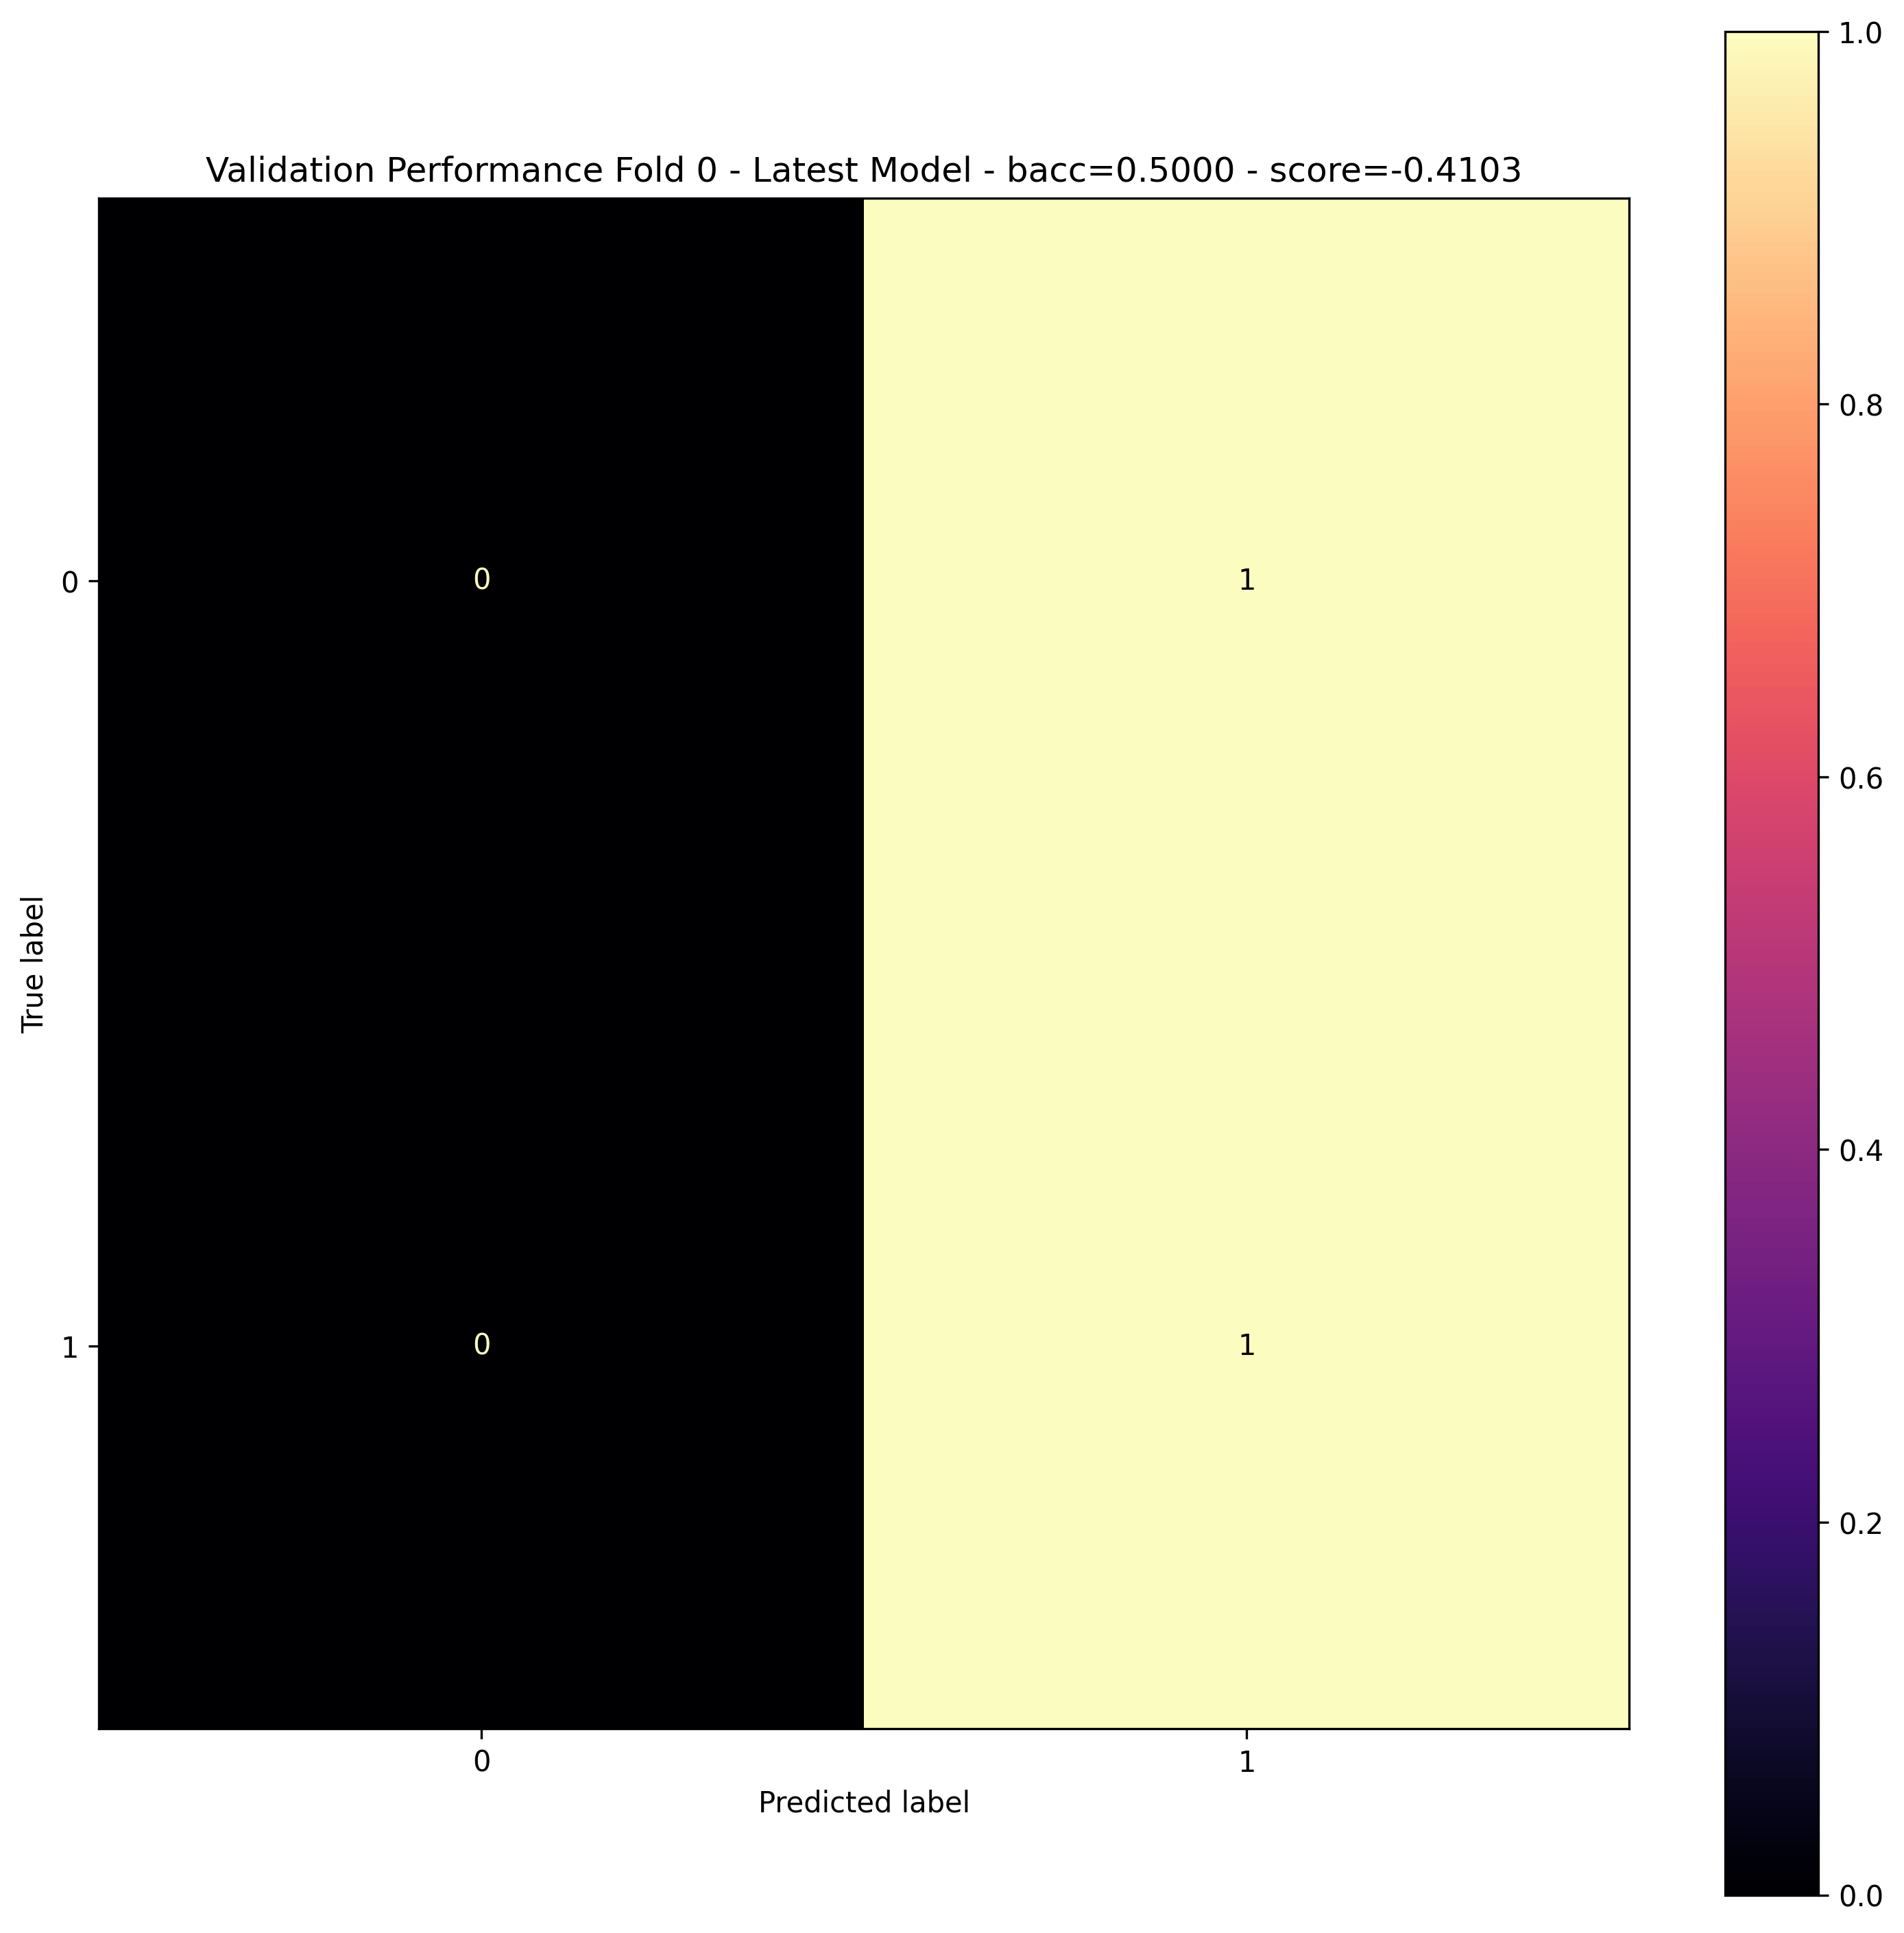

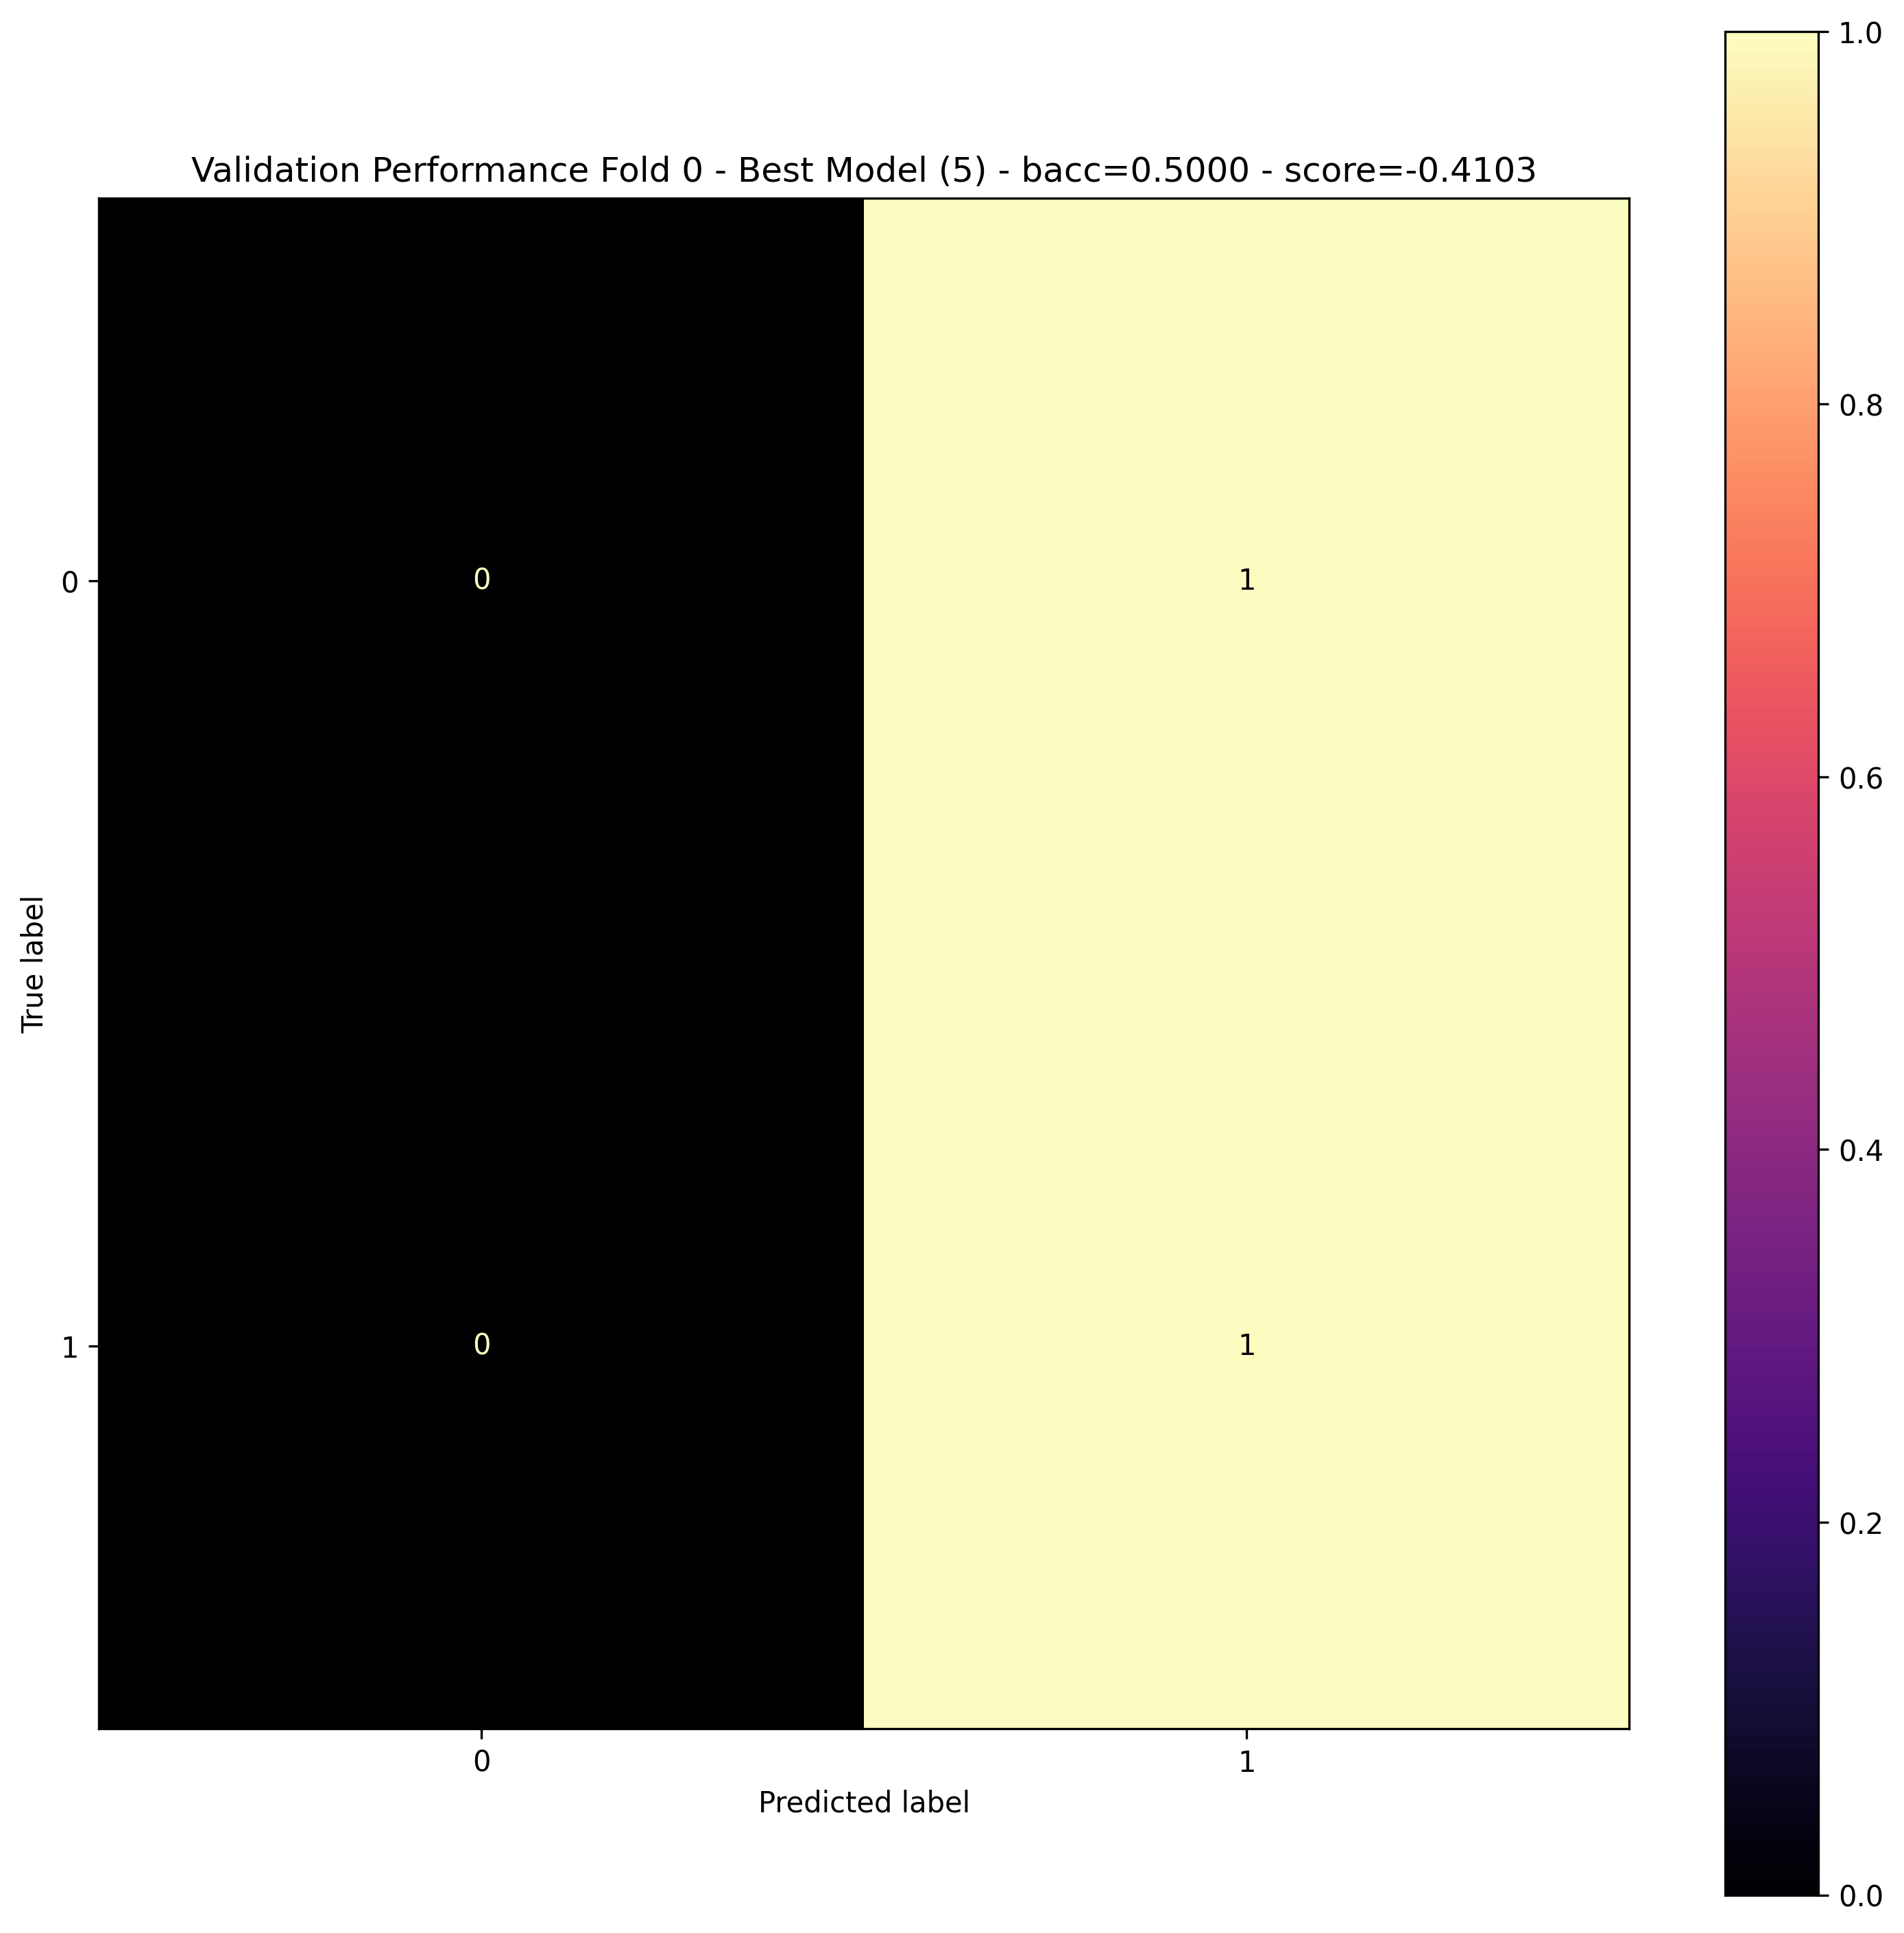


Testing fold 0


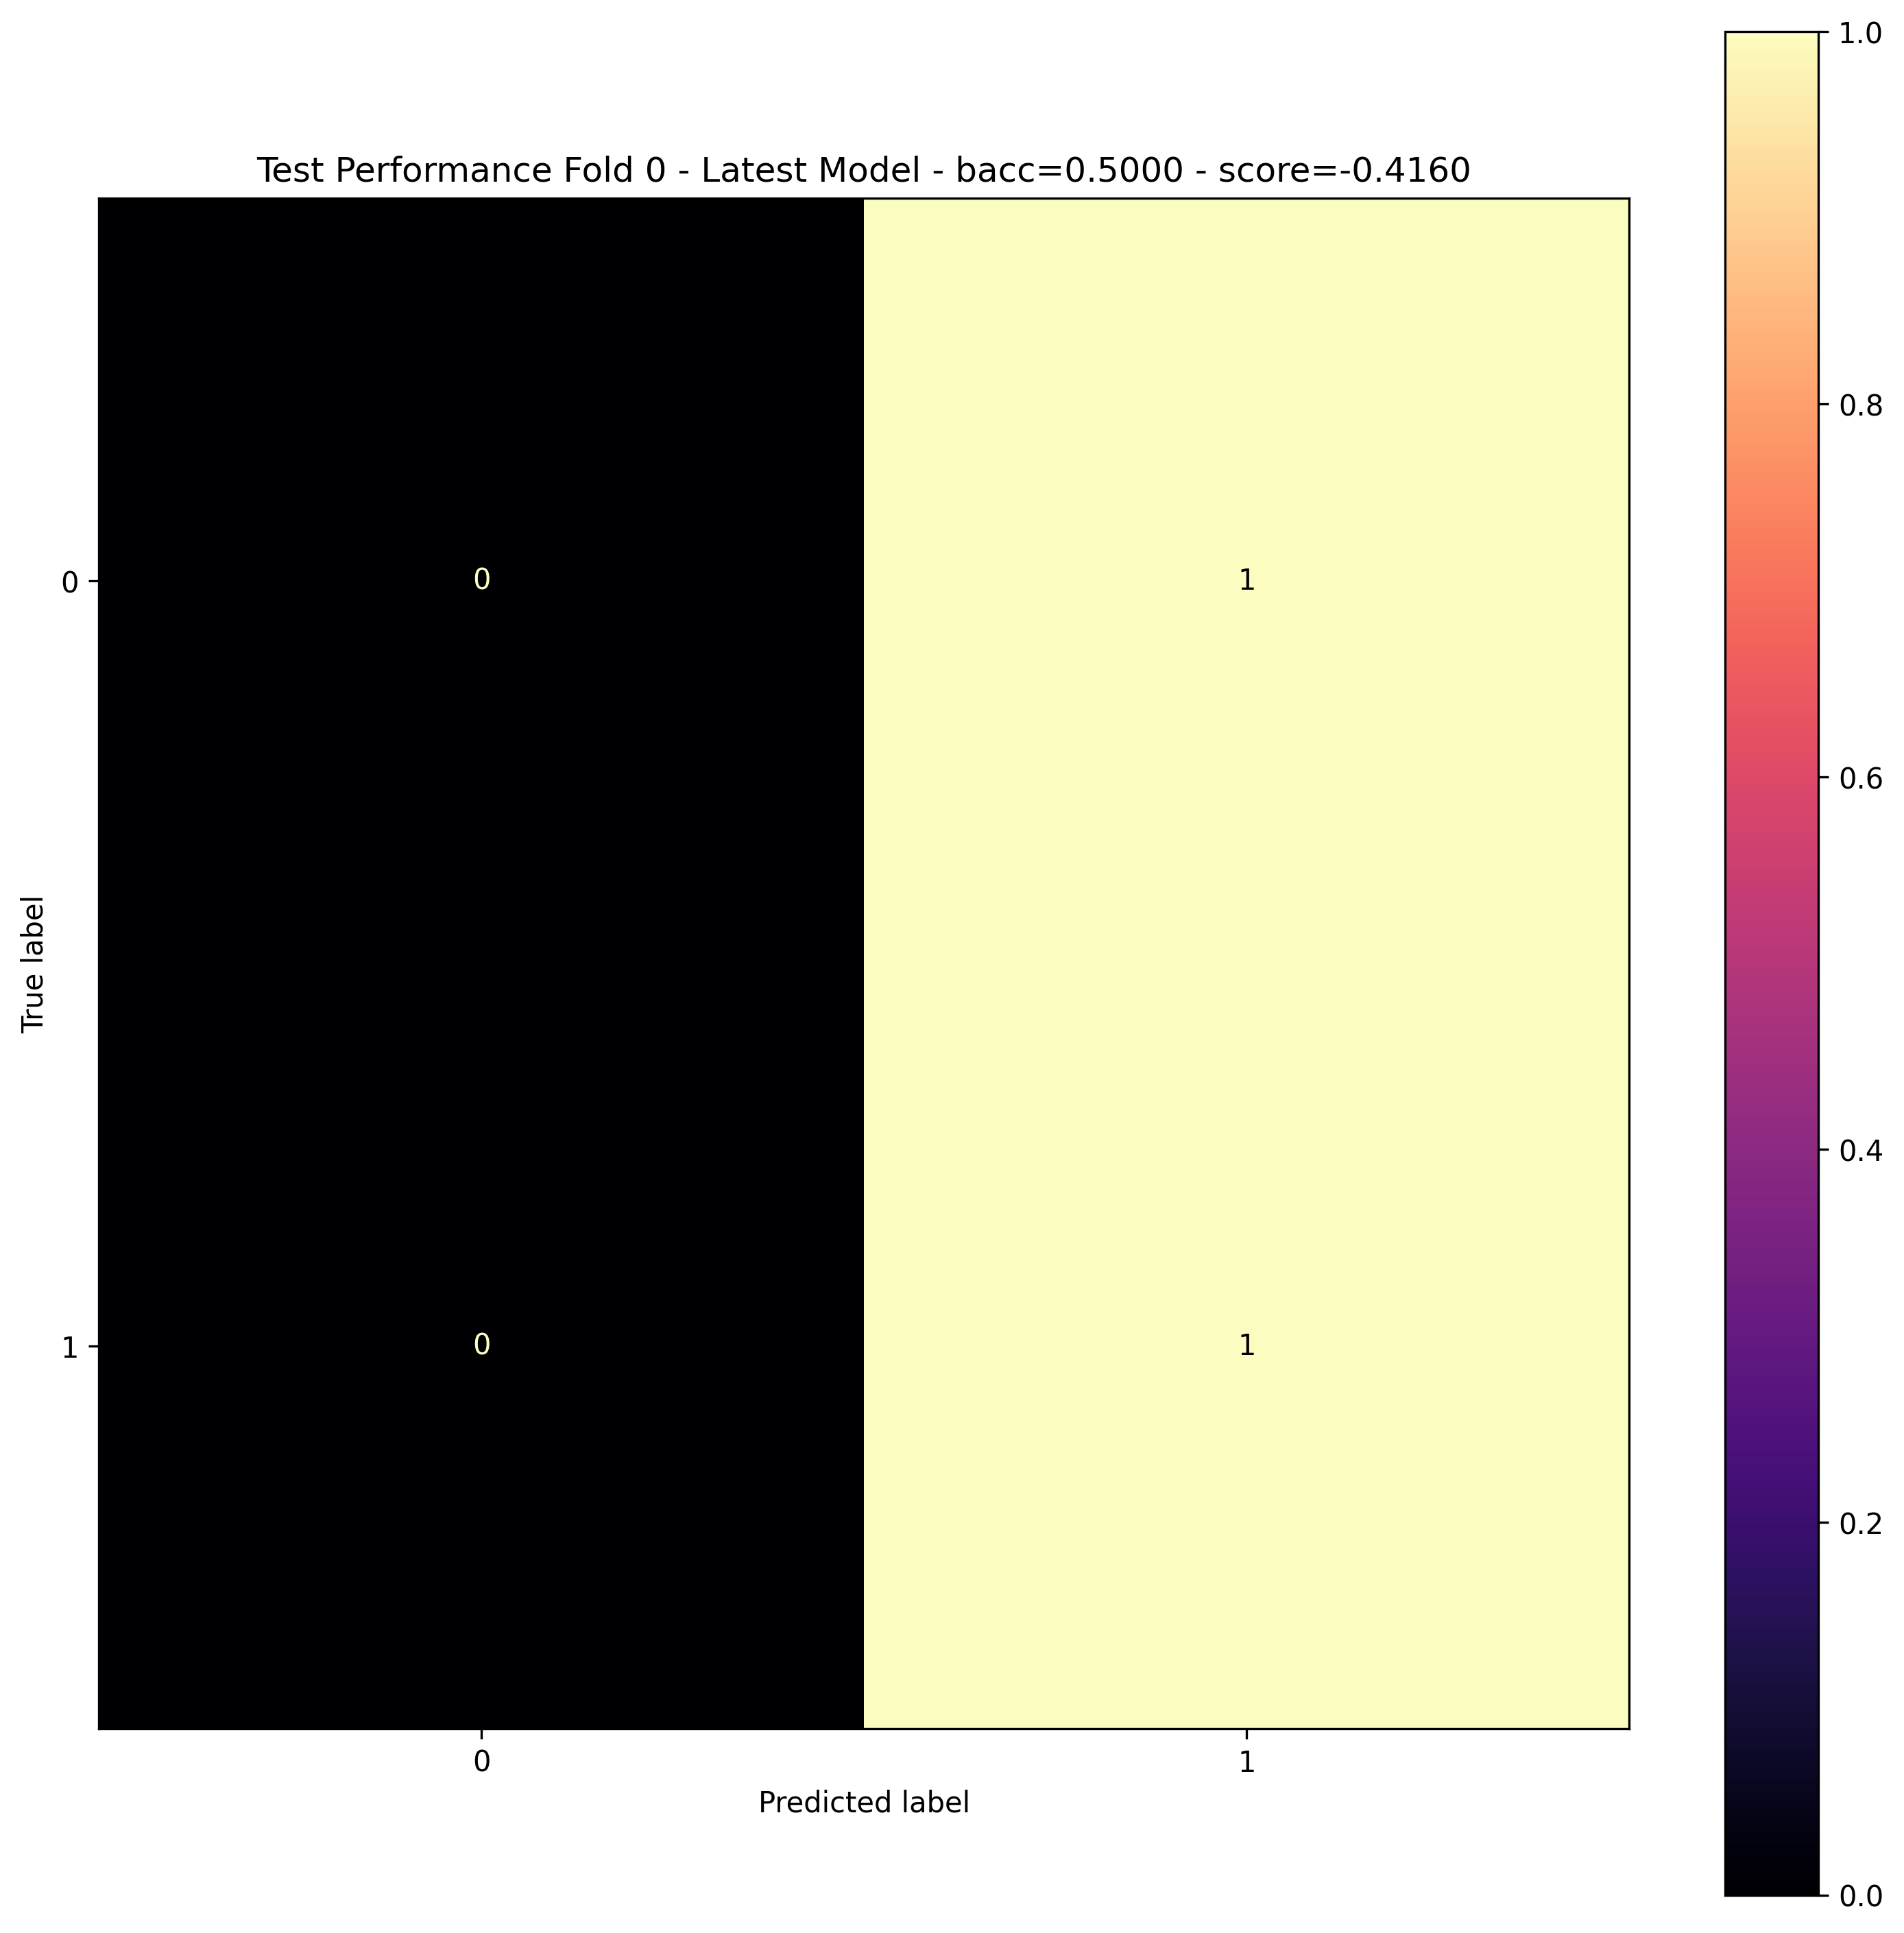

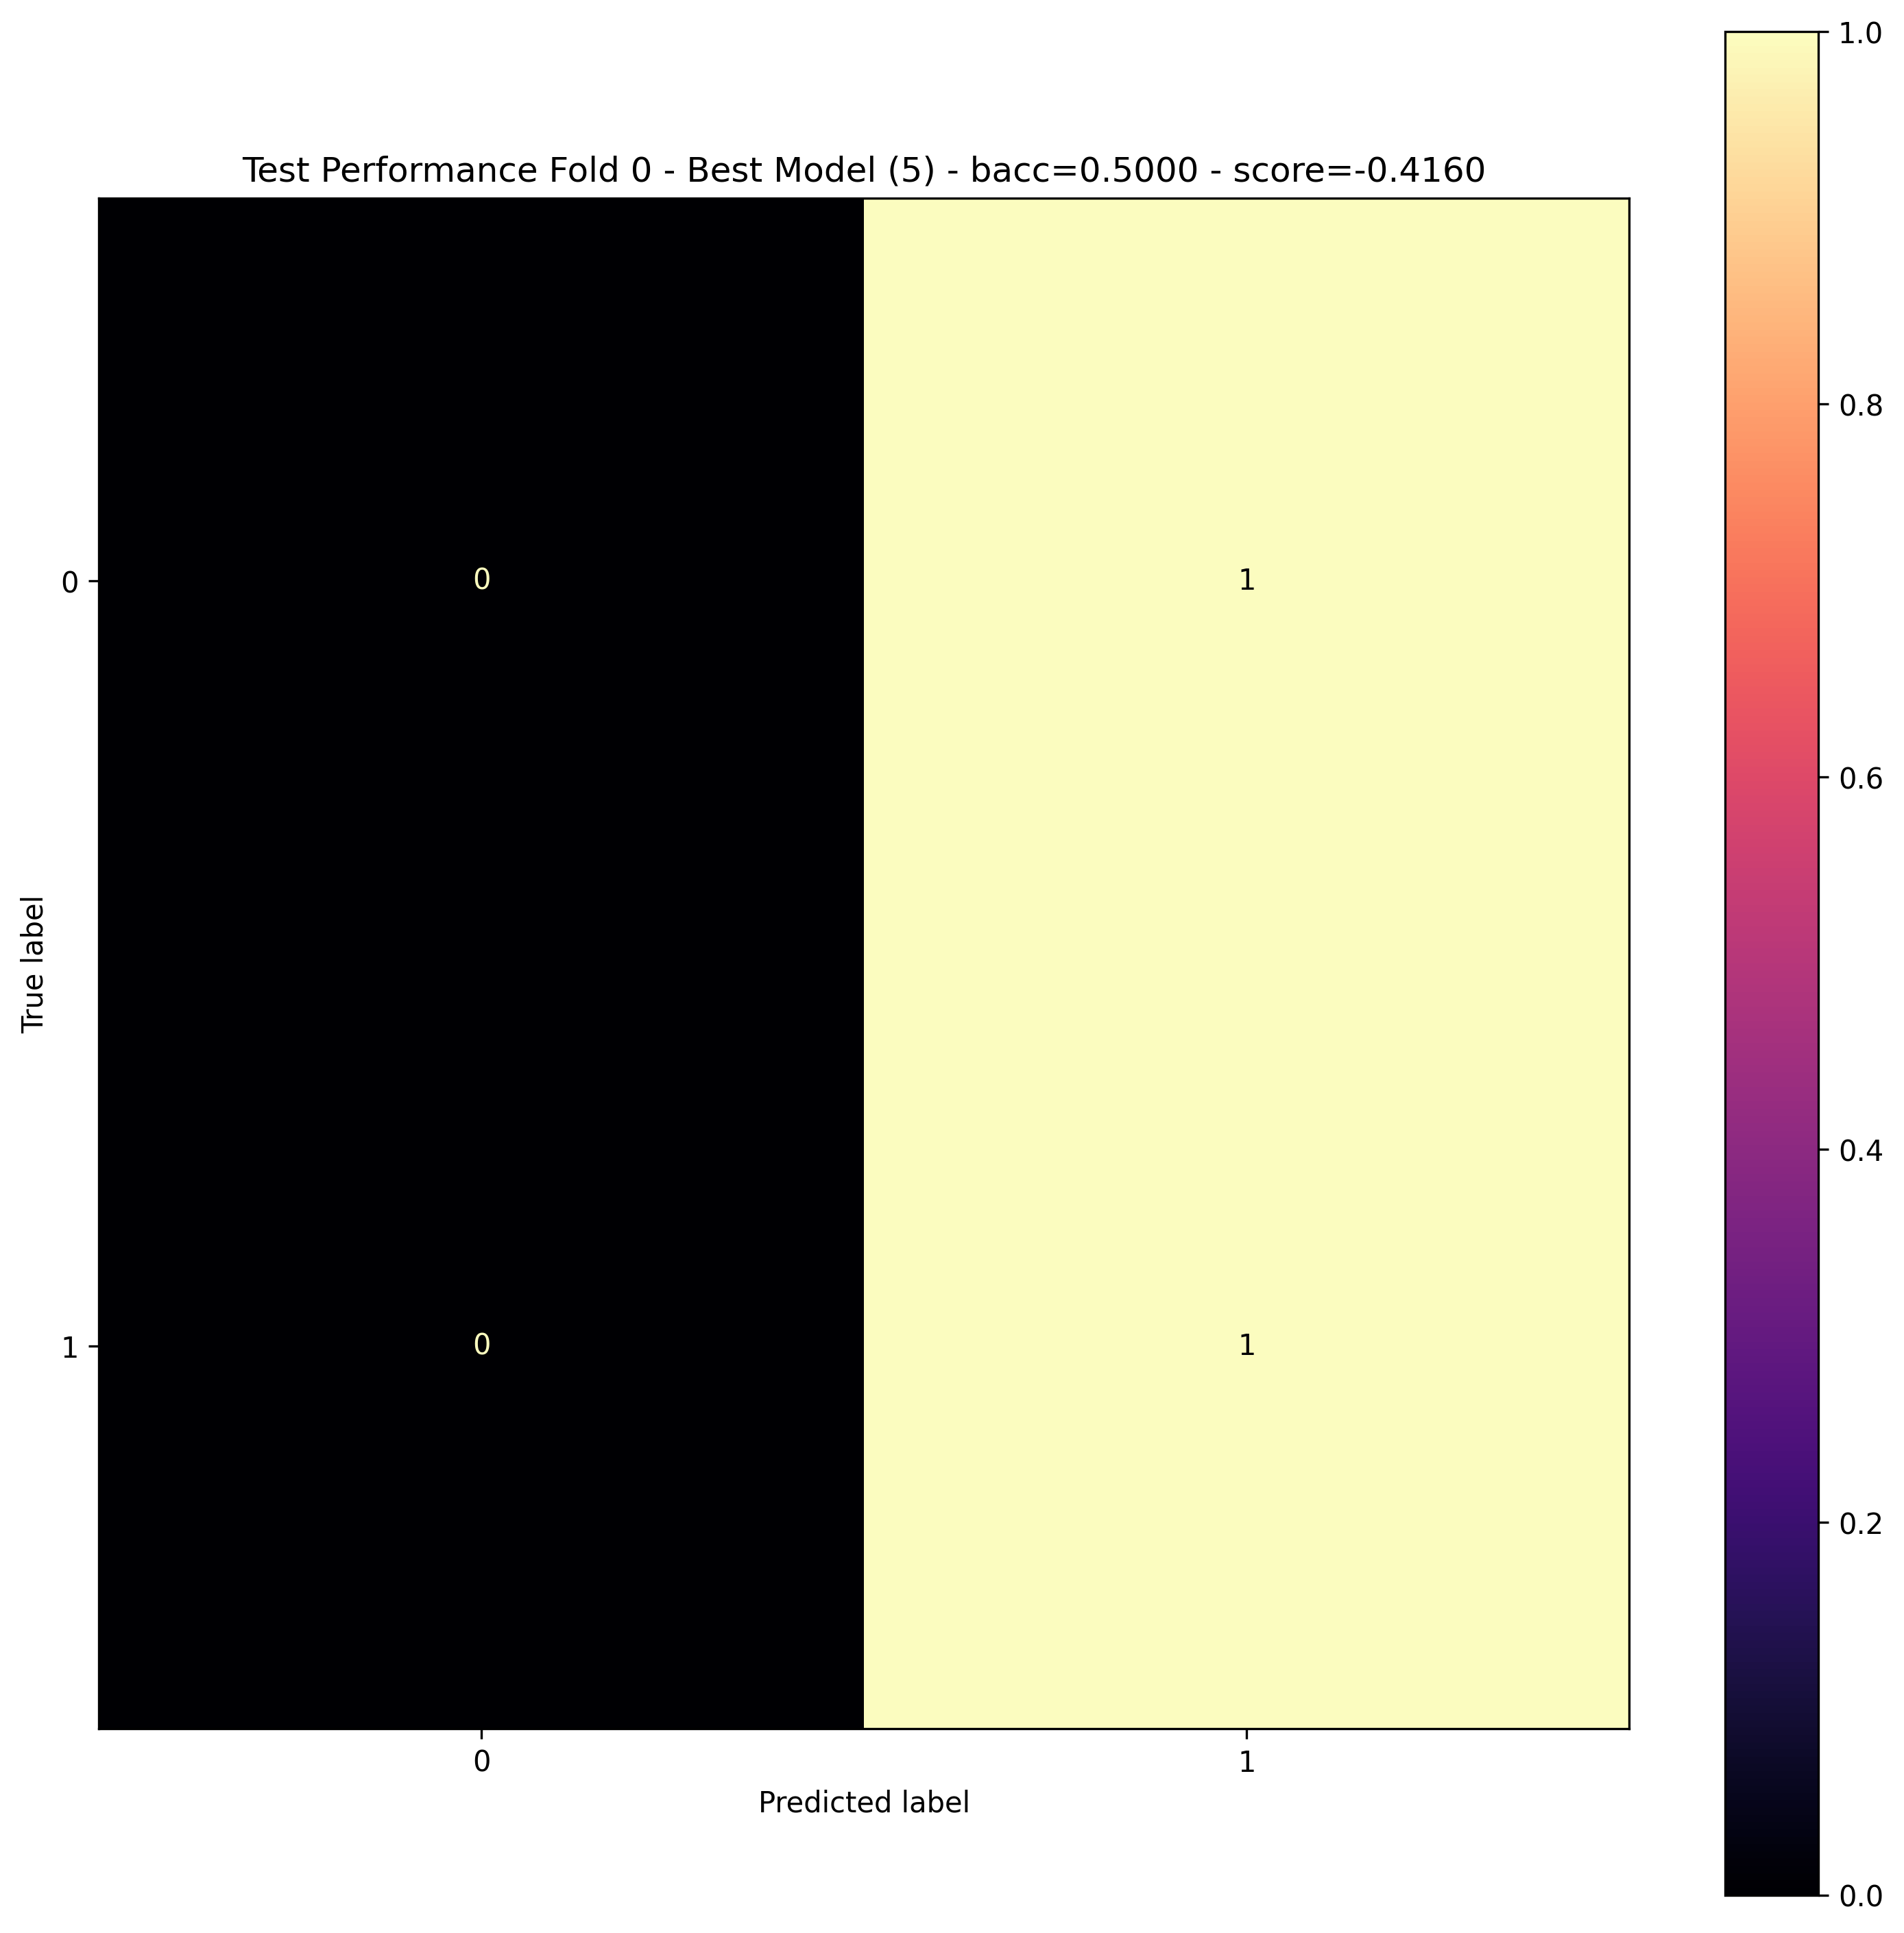

CV Folds:  12%|█████████████████████▍                                                                                                                                                     | 1/8 [00:07<00:53,  7.71s/it]

Best Model Test Metrics: avg_loss = 0.000113, num_samples = 24000, num_correct =  7008, acc = 0.292000, bacc = 0.500000, score = -0.416000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-0-best eval-score=-0.4103 test-score=-0.4160"



Executing CV for fold 1
Training fold 1


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59798, 24202]
eval label counts  = [ 8568,  3432]

loss weights                    = [ 0.50,  2.47]
eval loss weights (theoretical) = [ 0.50,  2.50]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000074, num_samples = 84000, num_correct = 36001, acc = 0.428583, bacc = 0.501479, score = -0.142833
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000118, num_samples = 12000, num_correct =  3432, acc = 0.286000, bacc = 0.500000, score = -0.428000
Training Epoch   2/5  : lr = 1.00E-03, epoc

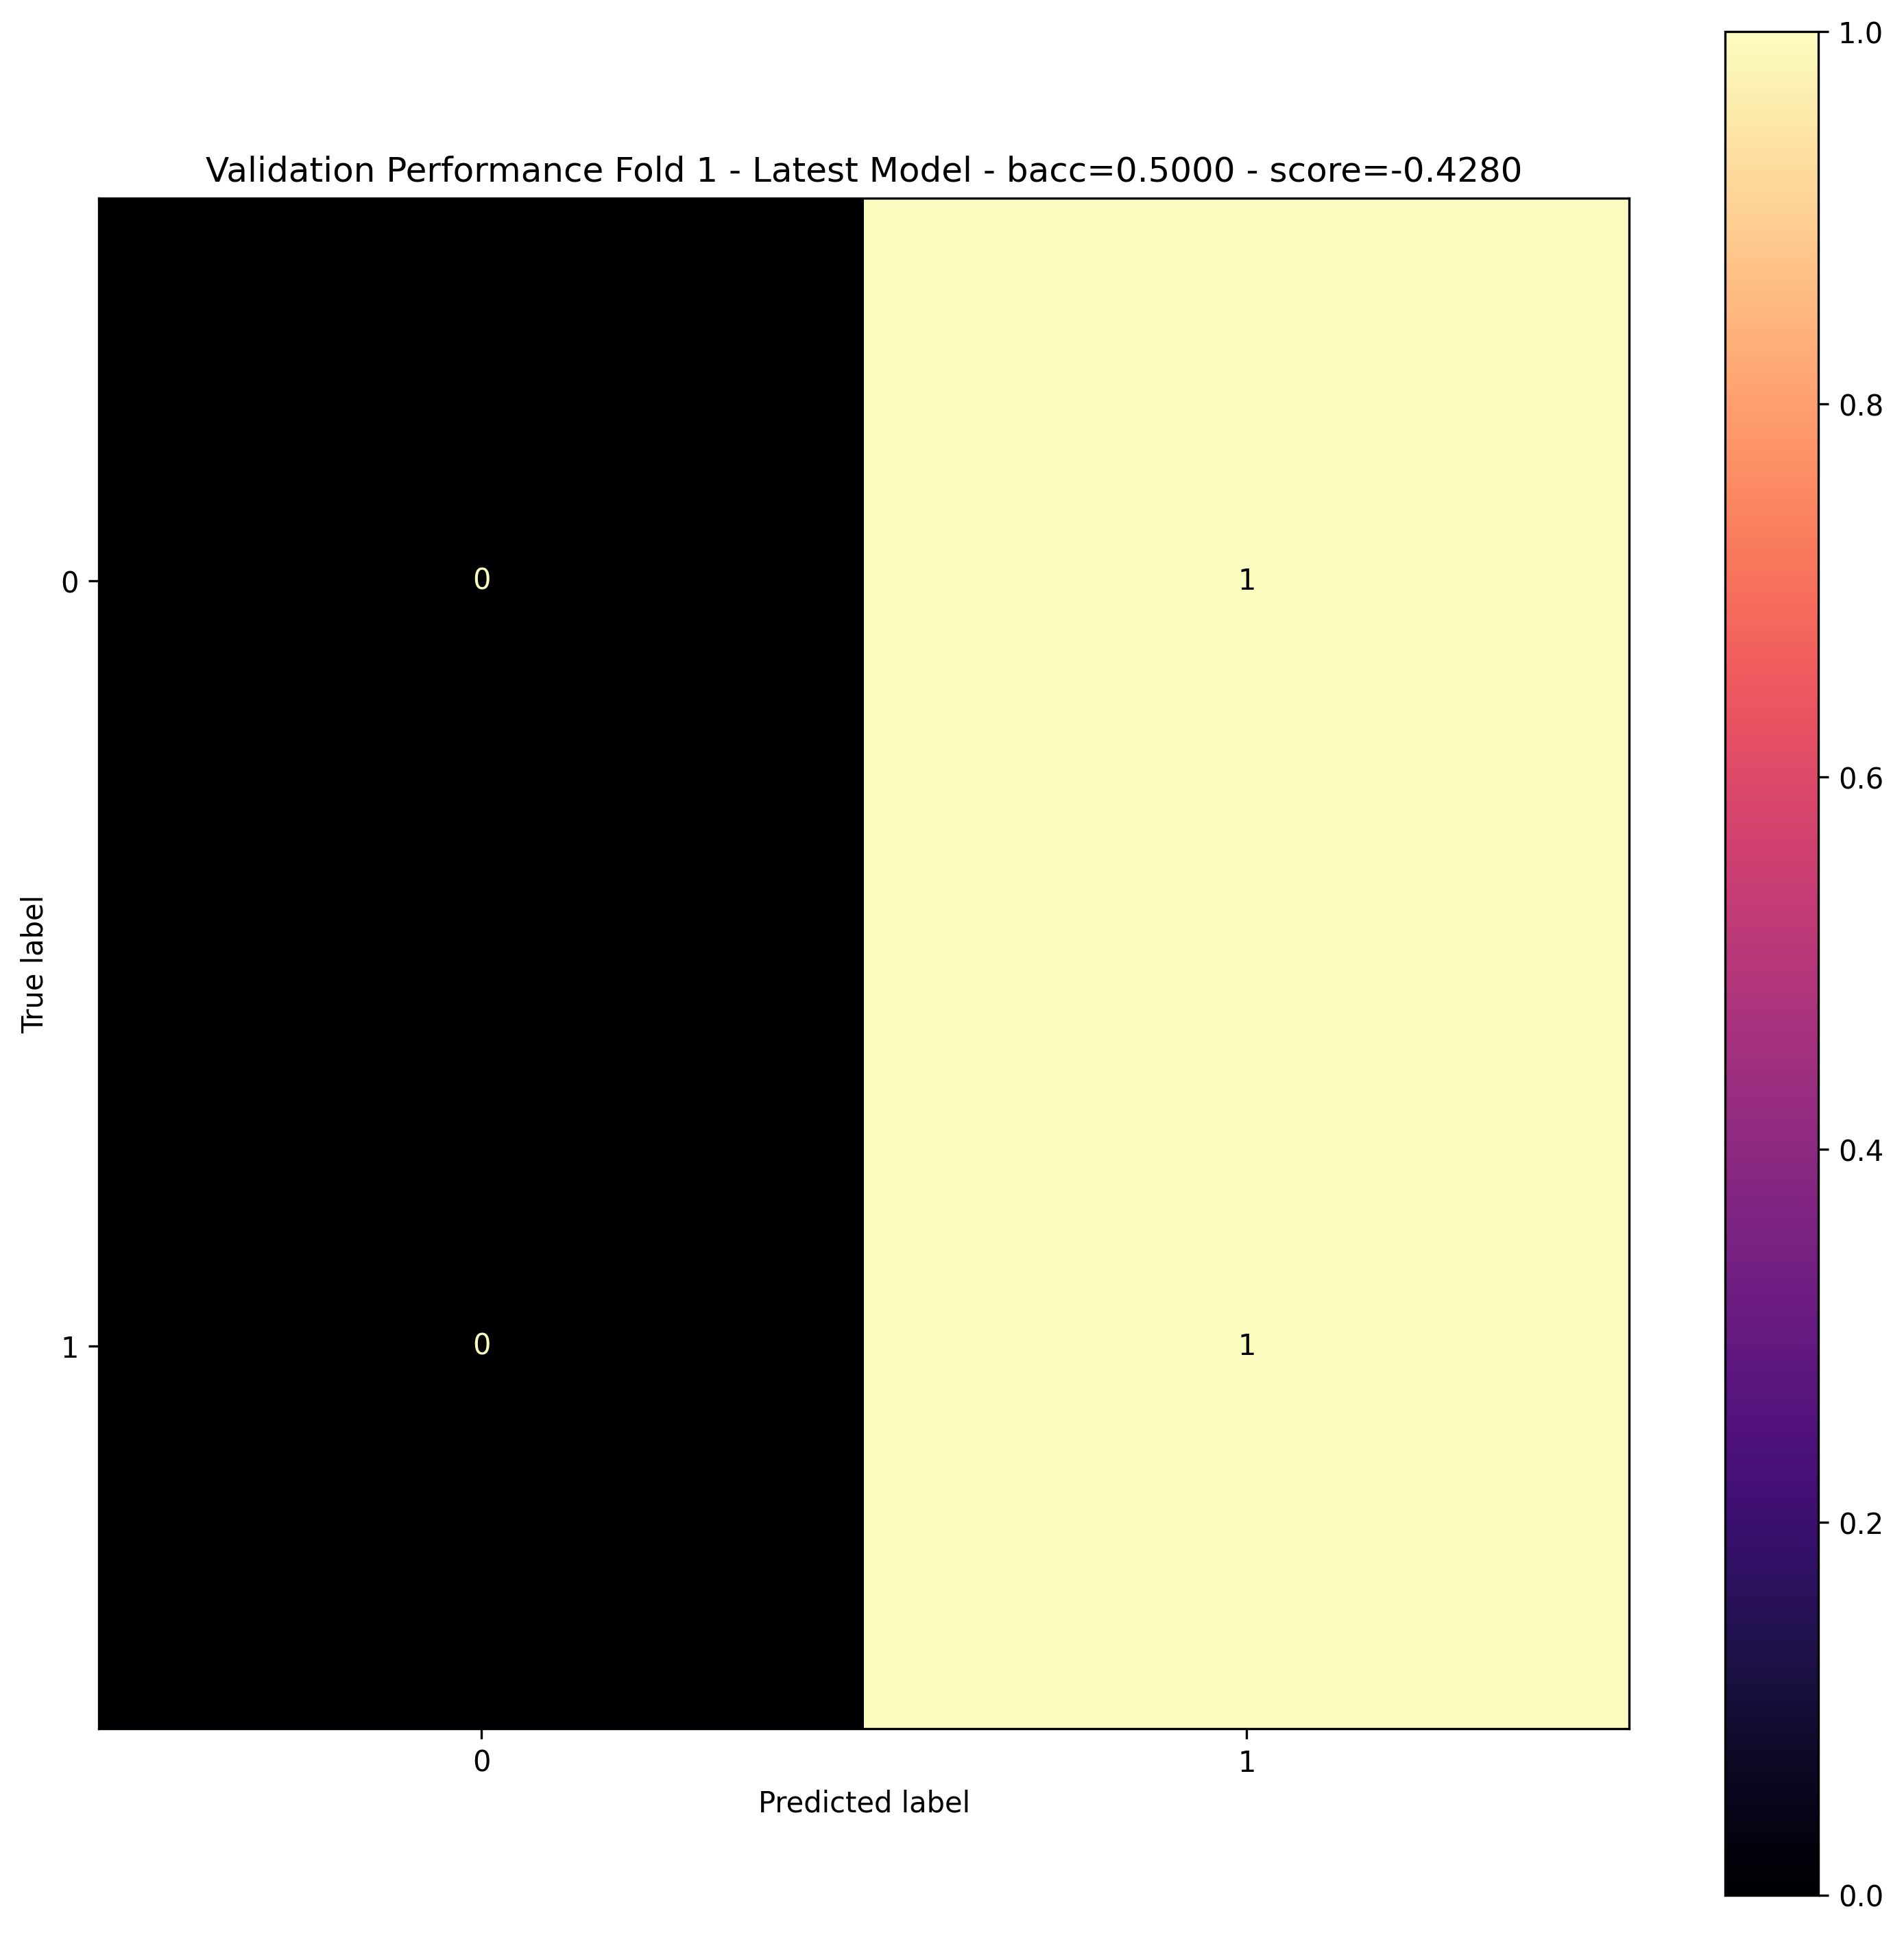

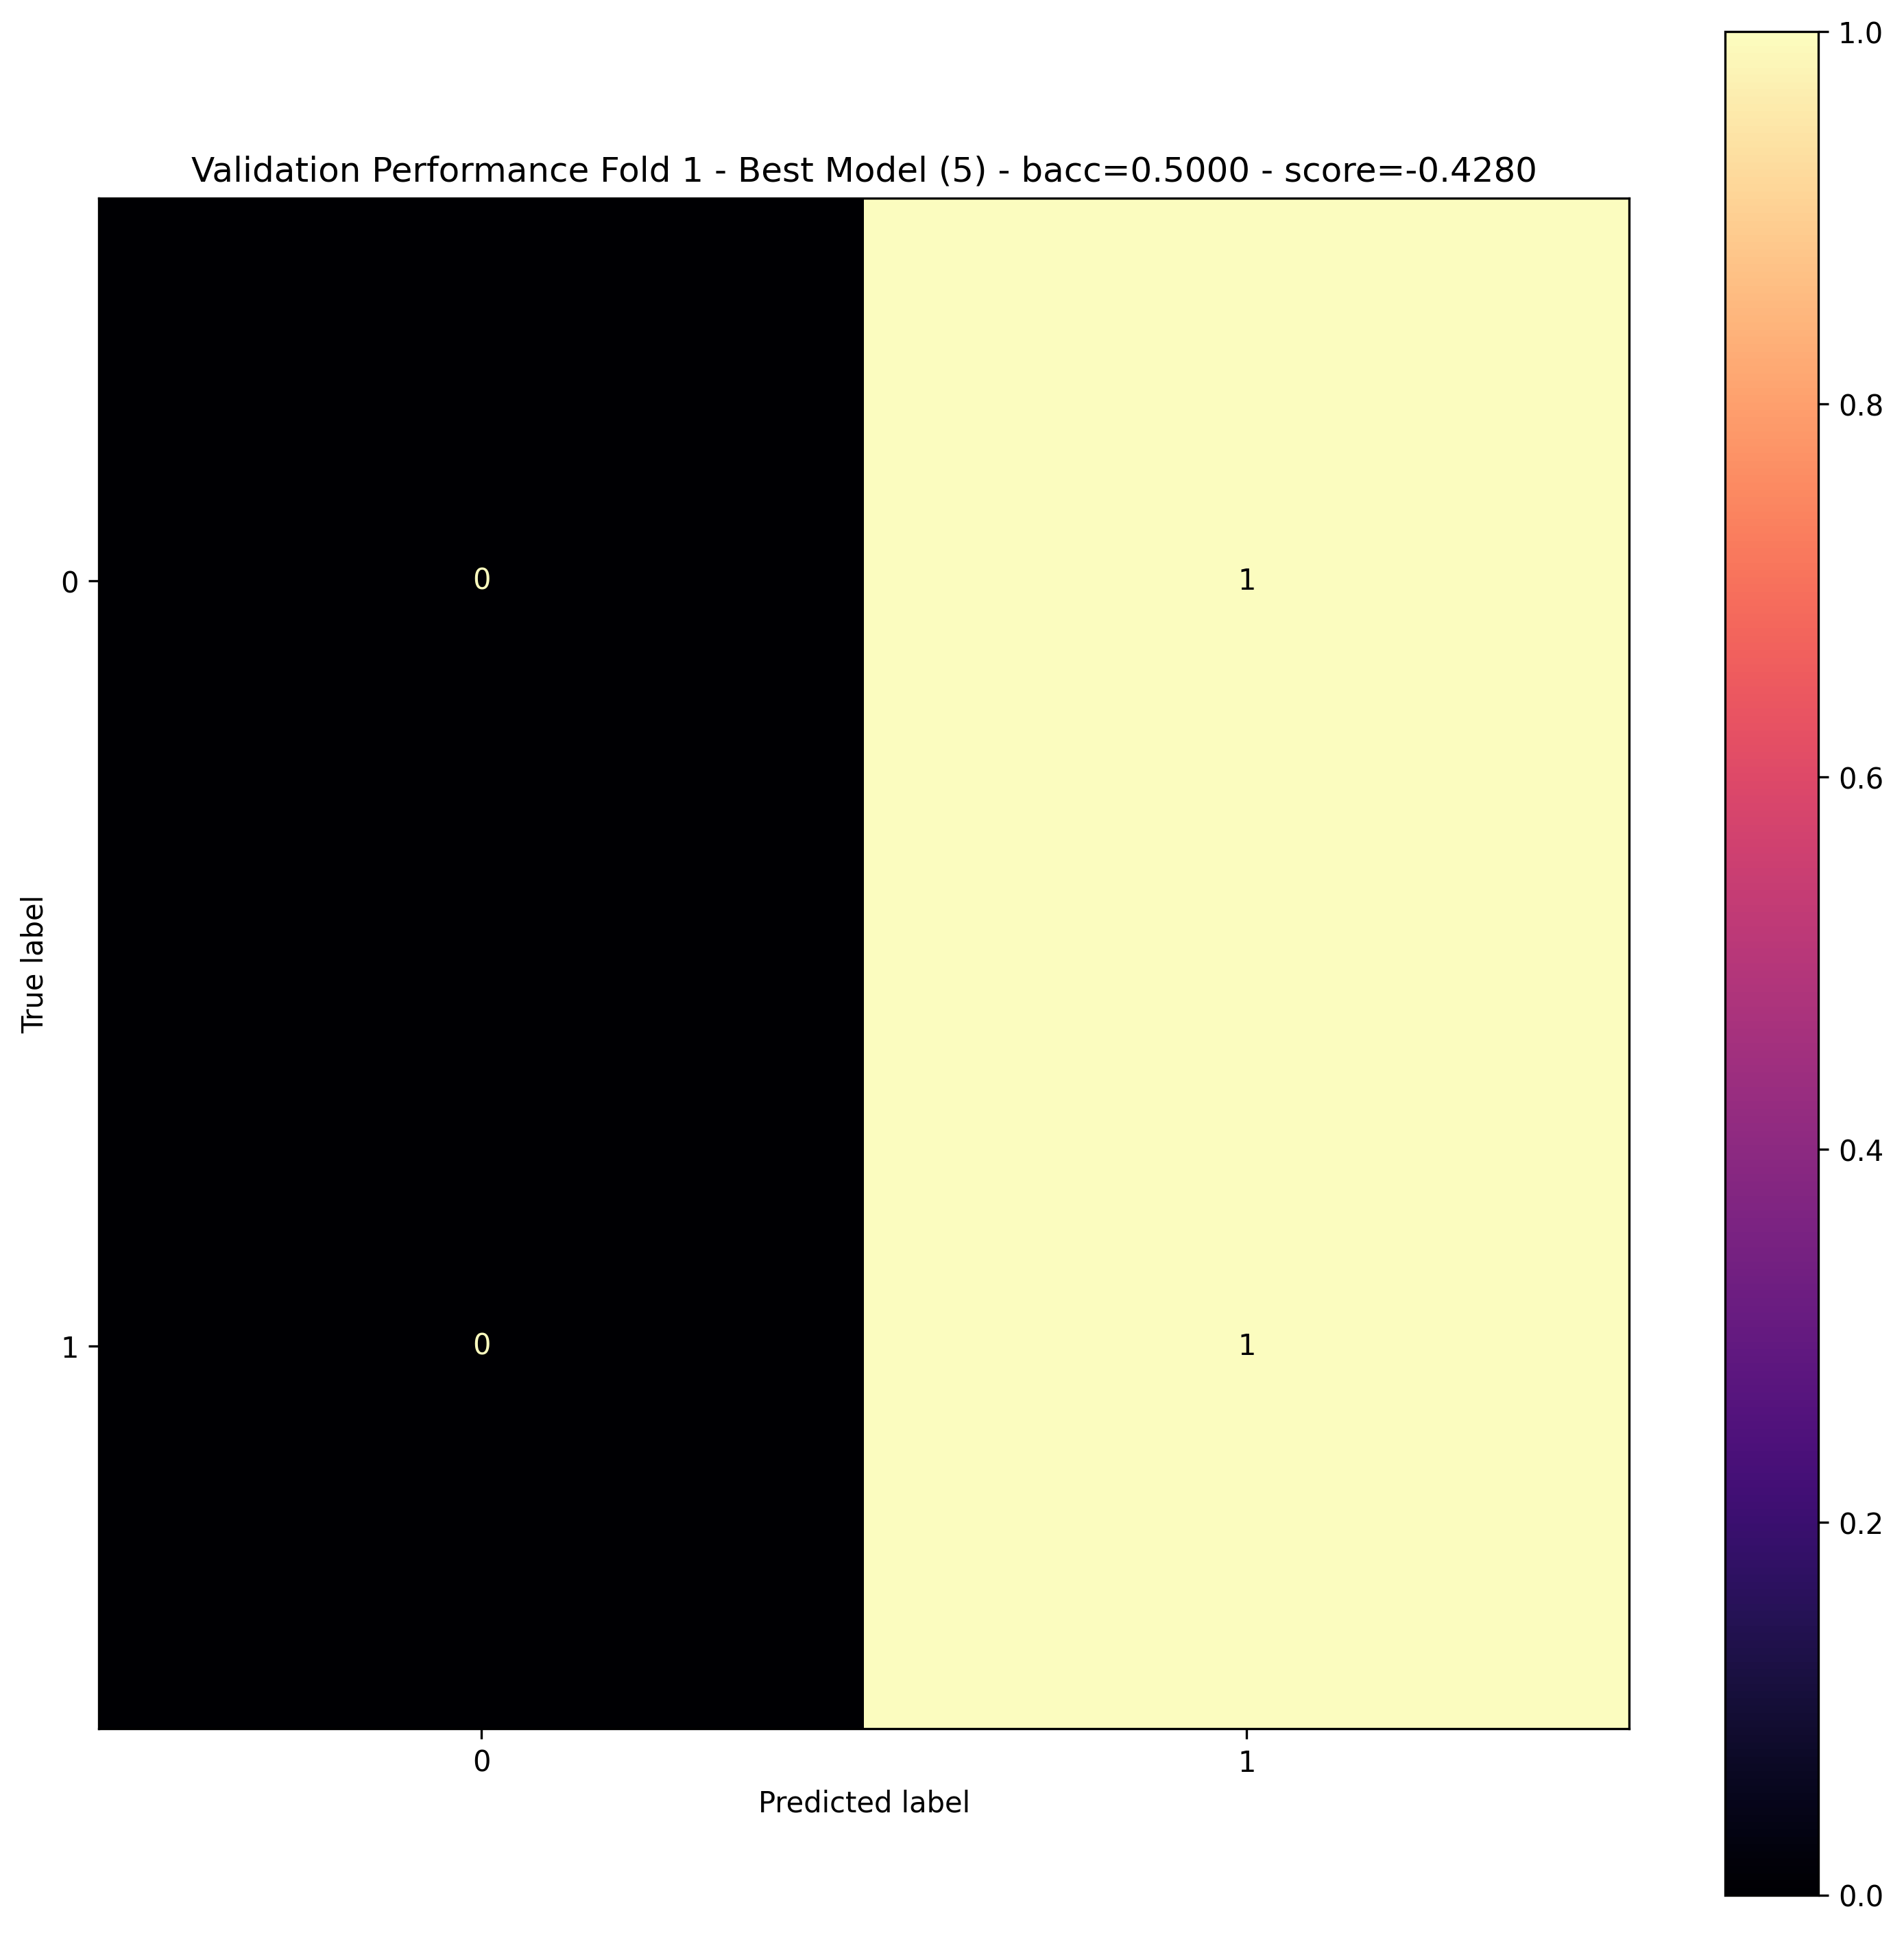


Testing fold 1


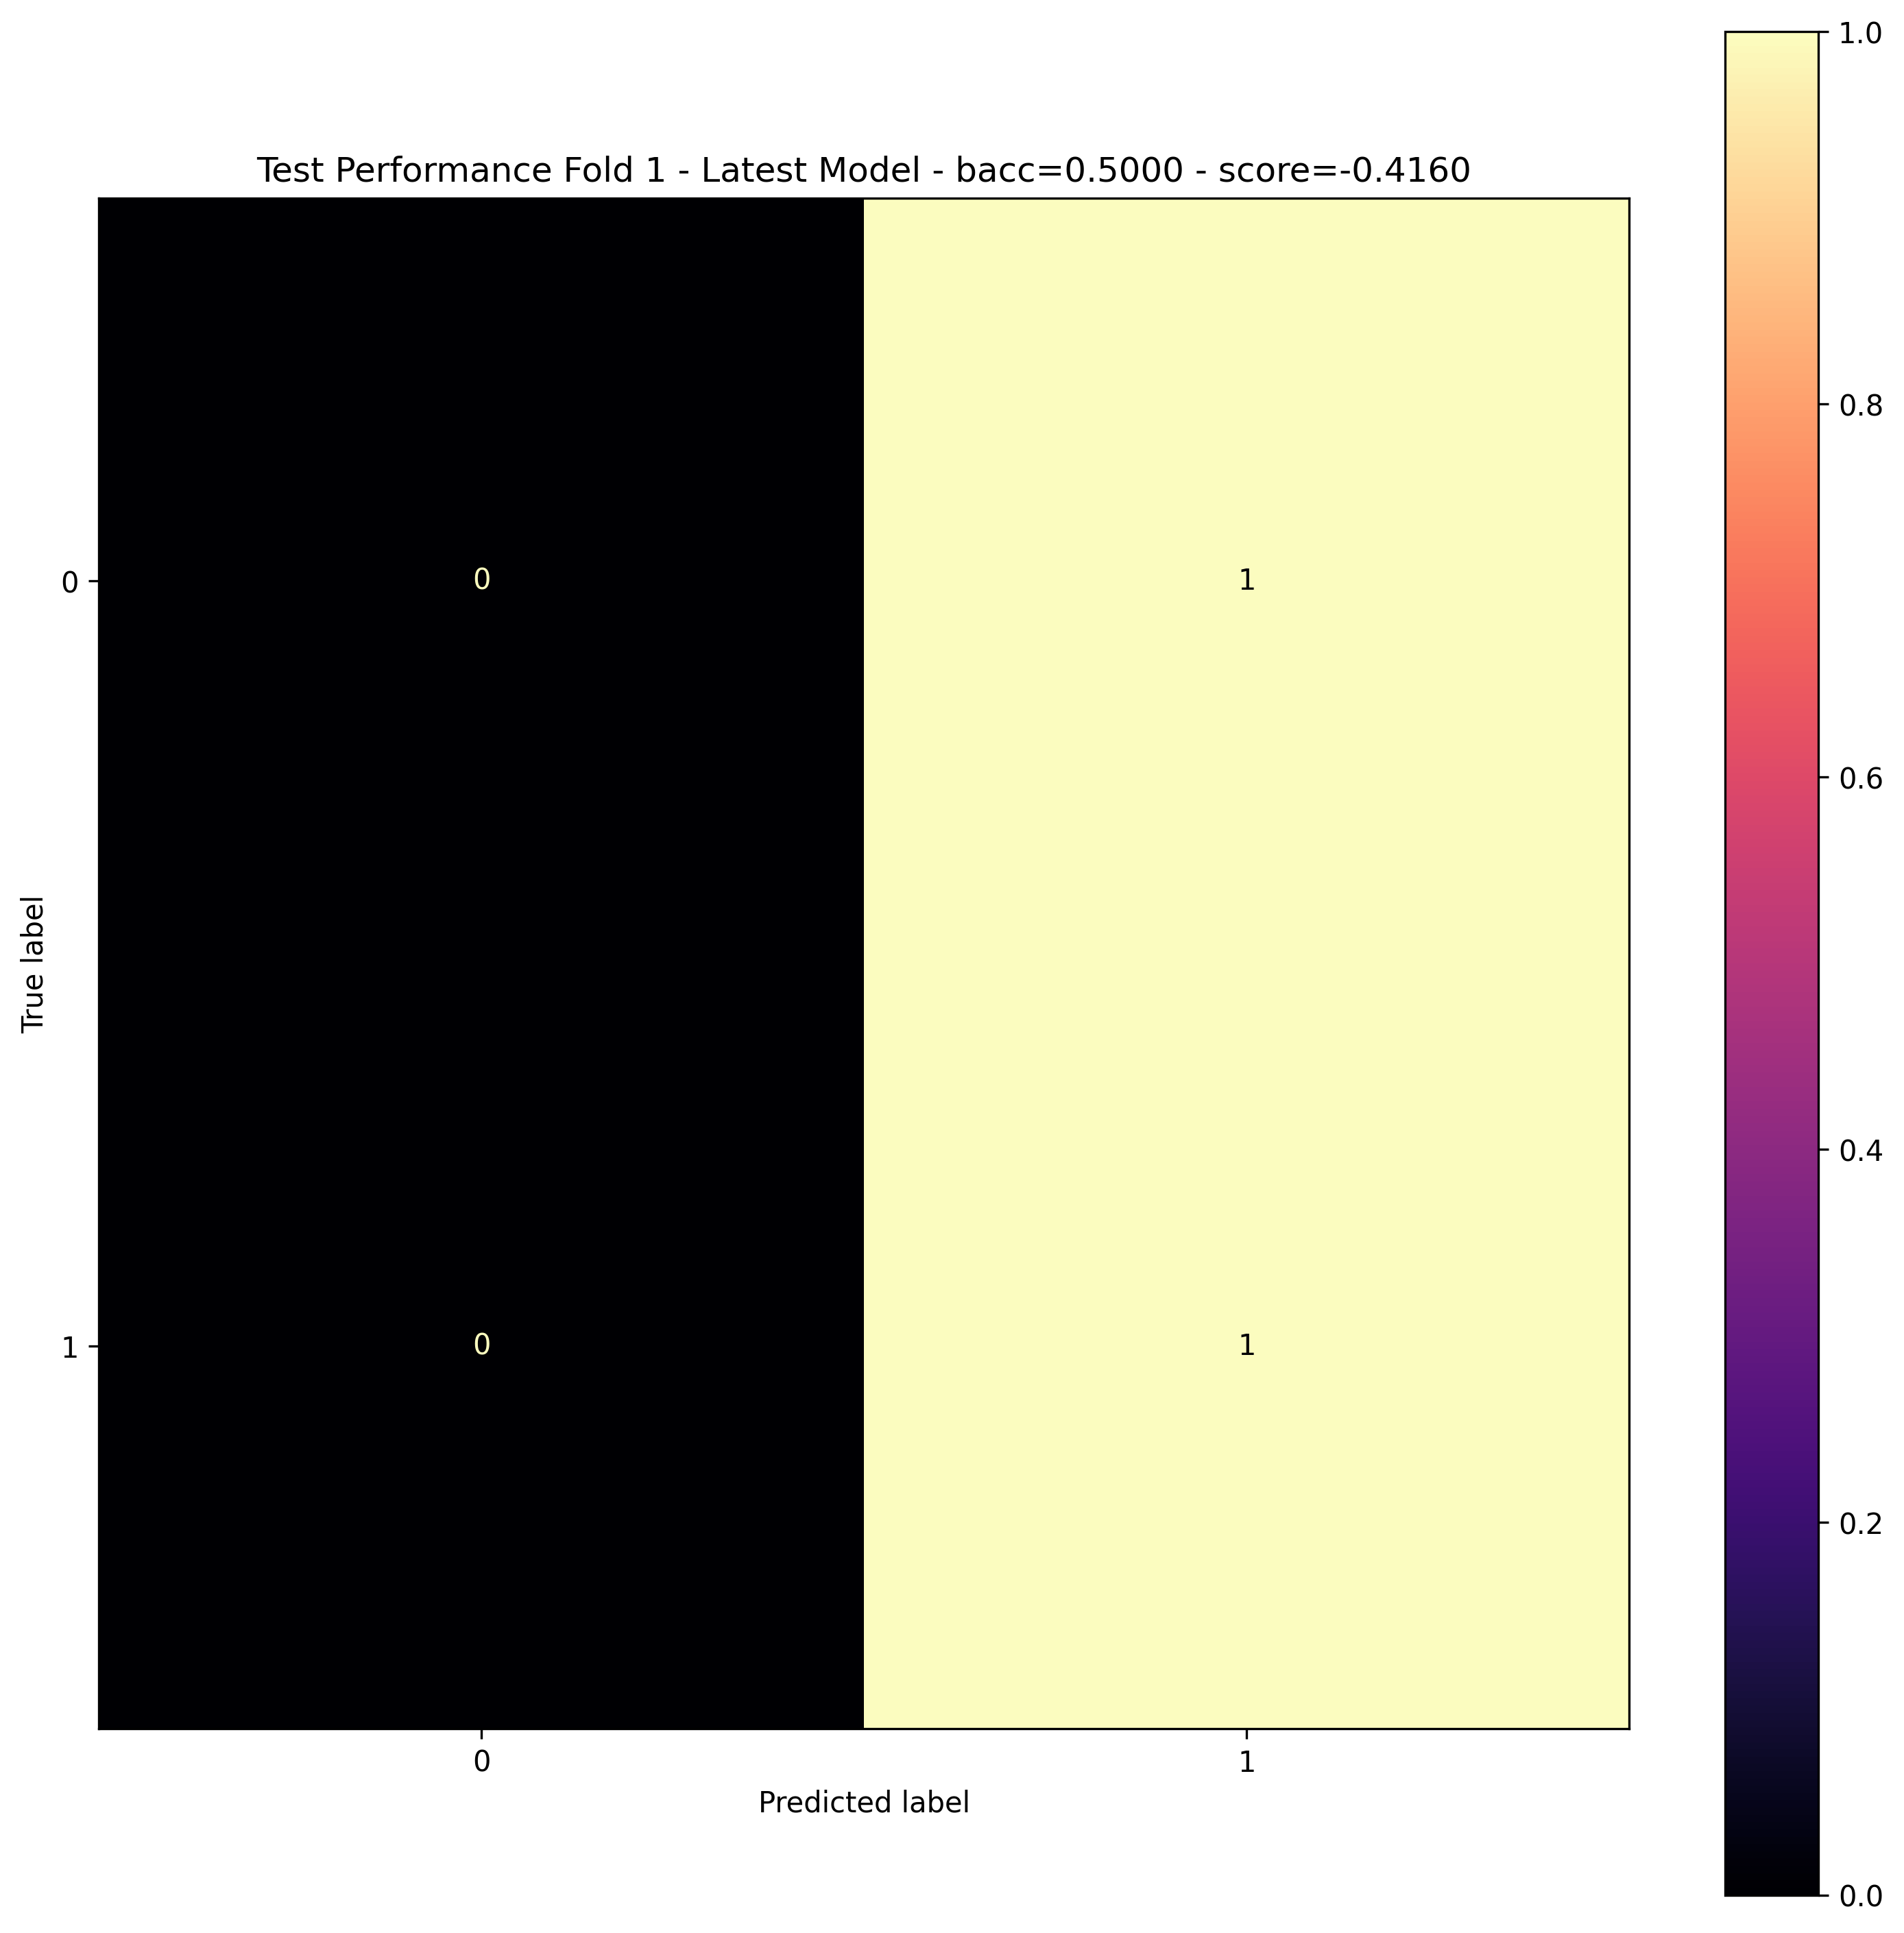

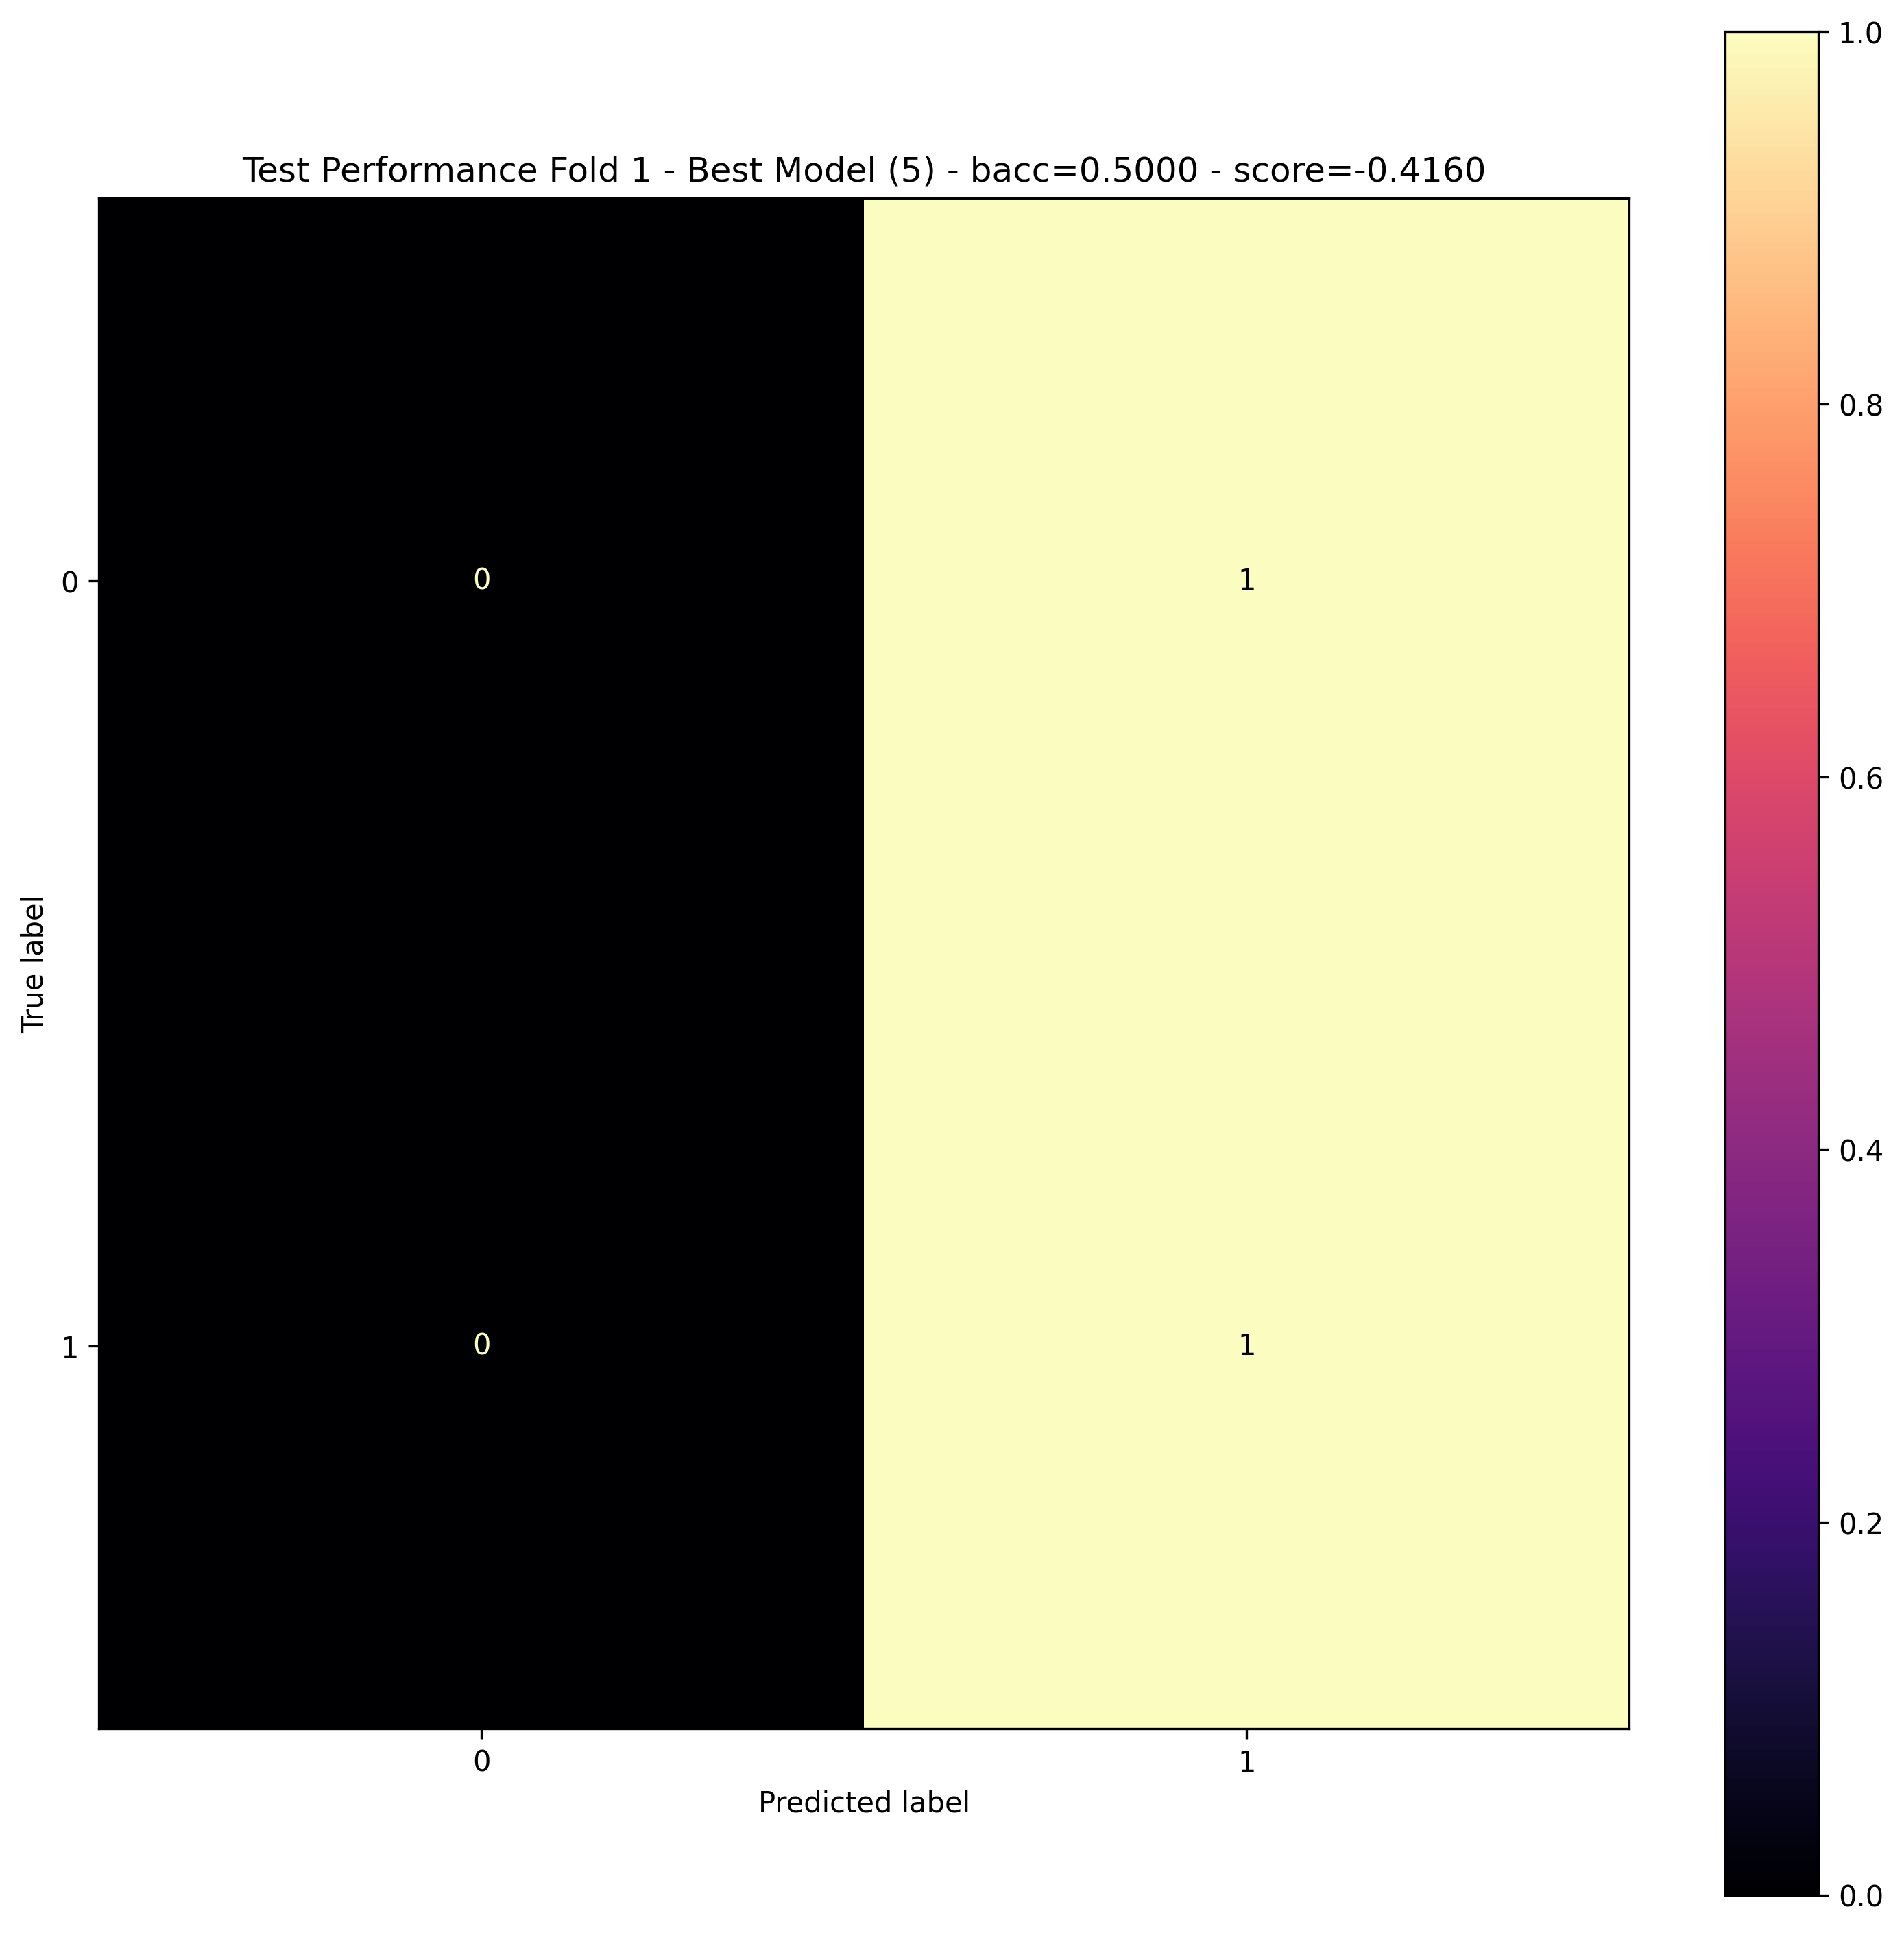

CV Folds:  25%|██████████████████████████████████████████▊                                                                                                                                | 2/8 [00:14<00:41,  6.88s/it]

Best Model Test Metrics: avg_loss = 0.000114, num_samples = 24000, num_correct =  7008, acc = 0.292000, bacc = 0.500000, score = -0.416000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-1-best eval-score=-0.4280 test-score=-0.4160"



Executing CV for fold 2
Training fold 2


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59817, 24183]
eval label counts  = [ 8549,  3451]

loss weights                    = [ 0.50,  2.47]
eval loss weights (theoretical) = [ 0.50,  2.48]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000073, num_samples = 84000, num_correct = 34847, acc = 0.414845, bacc = 0.500753, score = -0.170310
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000121, num_samples = 12000, num_correct =  3451, acc = 0.287583, bacc = 0.500000, score = -0.424833
Training Epoch   2/5  : lr = 1.00E-03, epoc

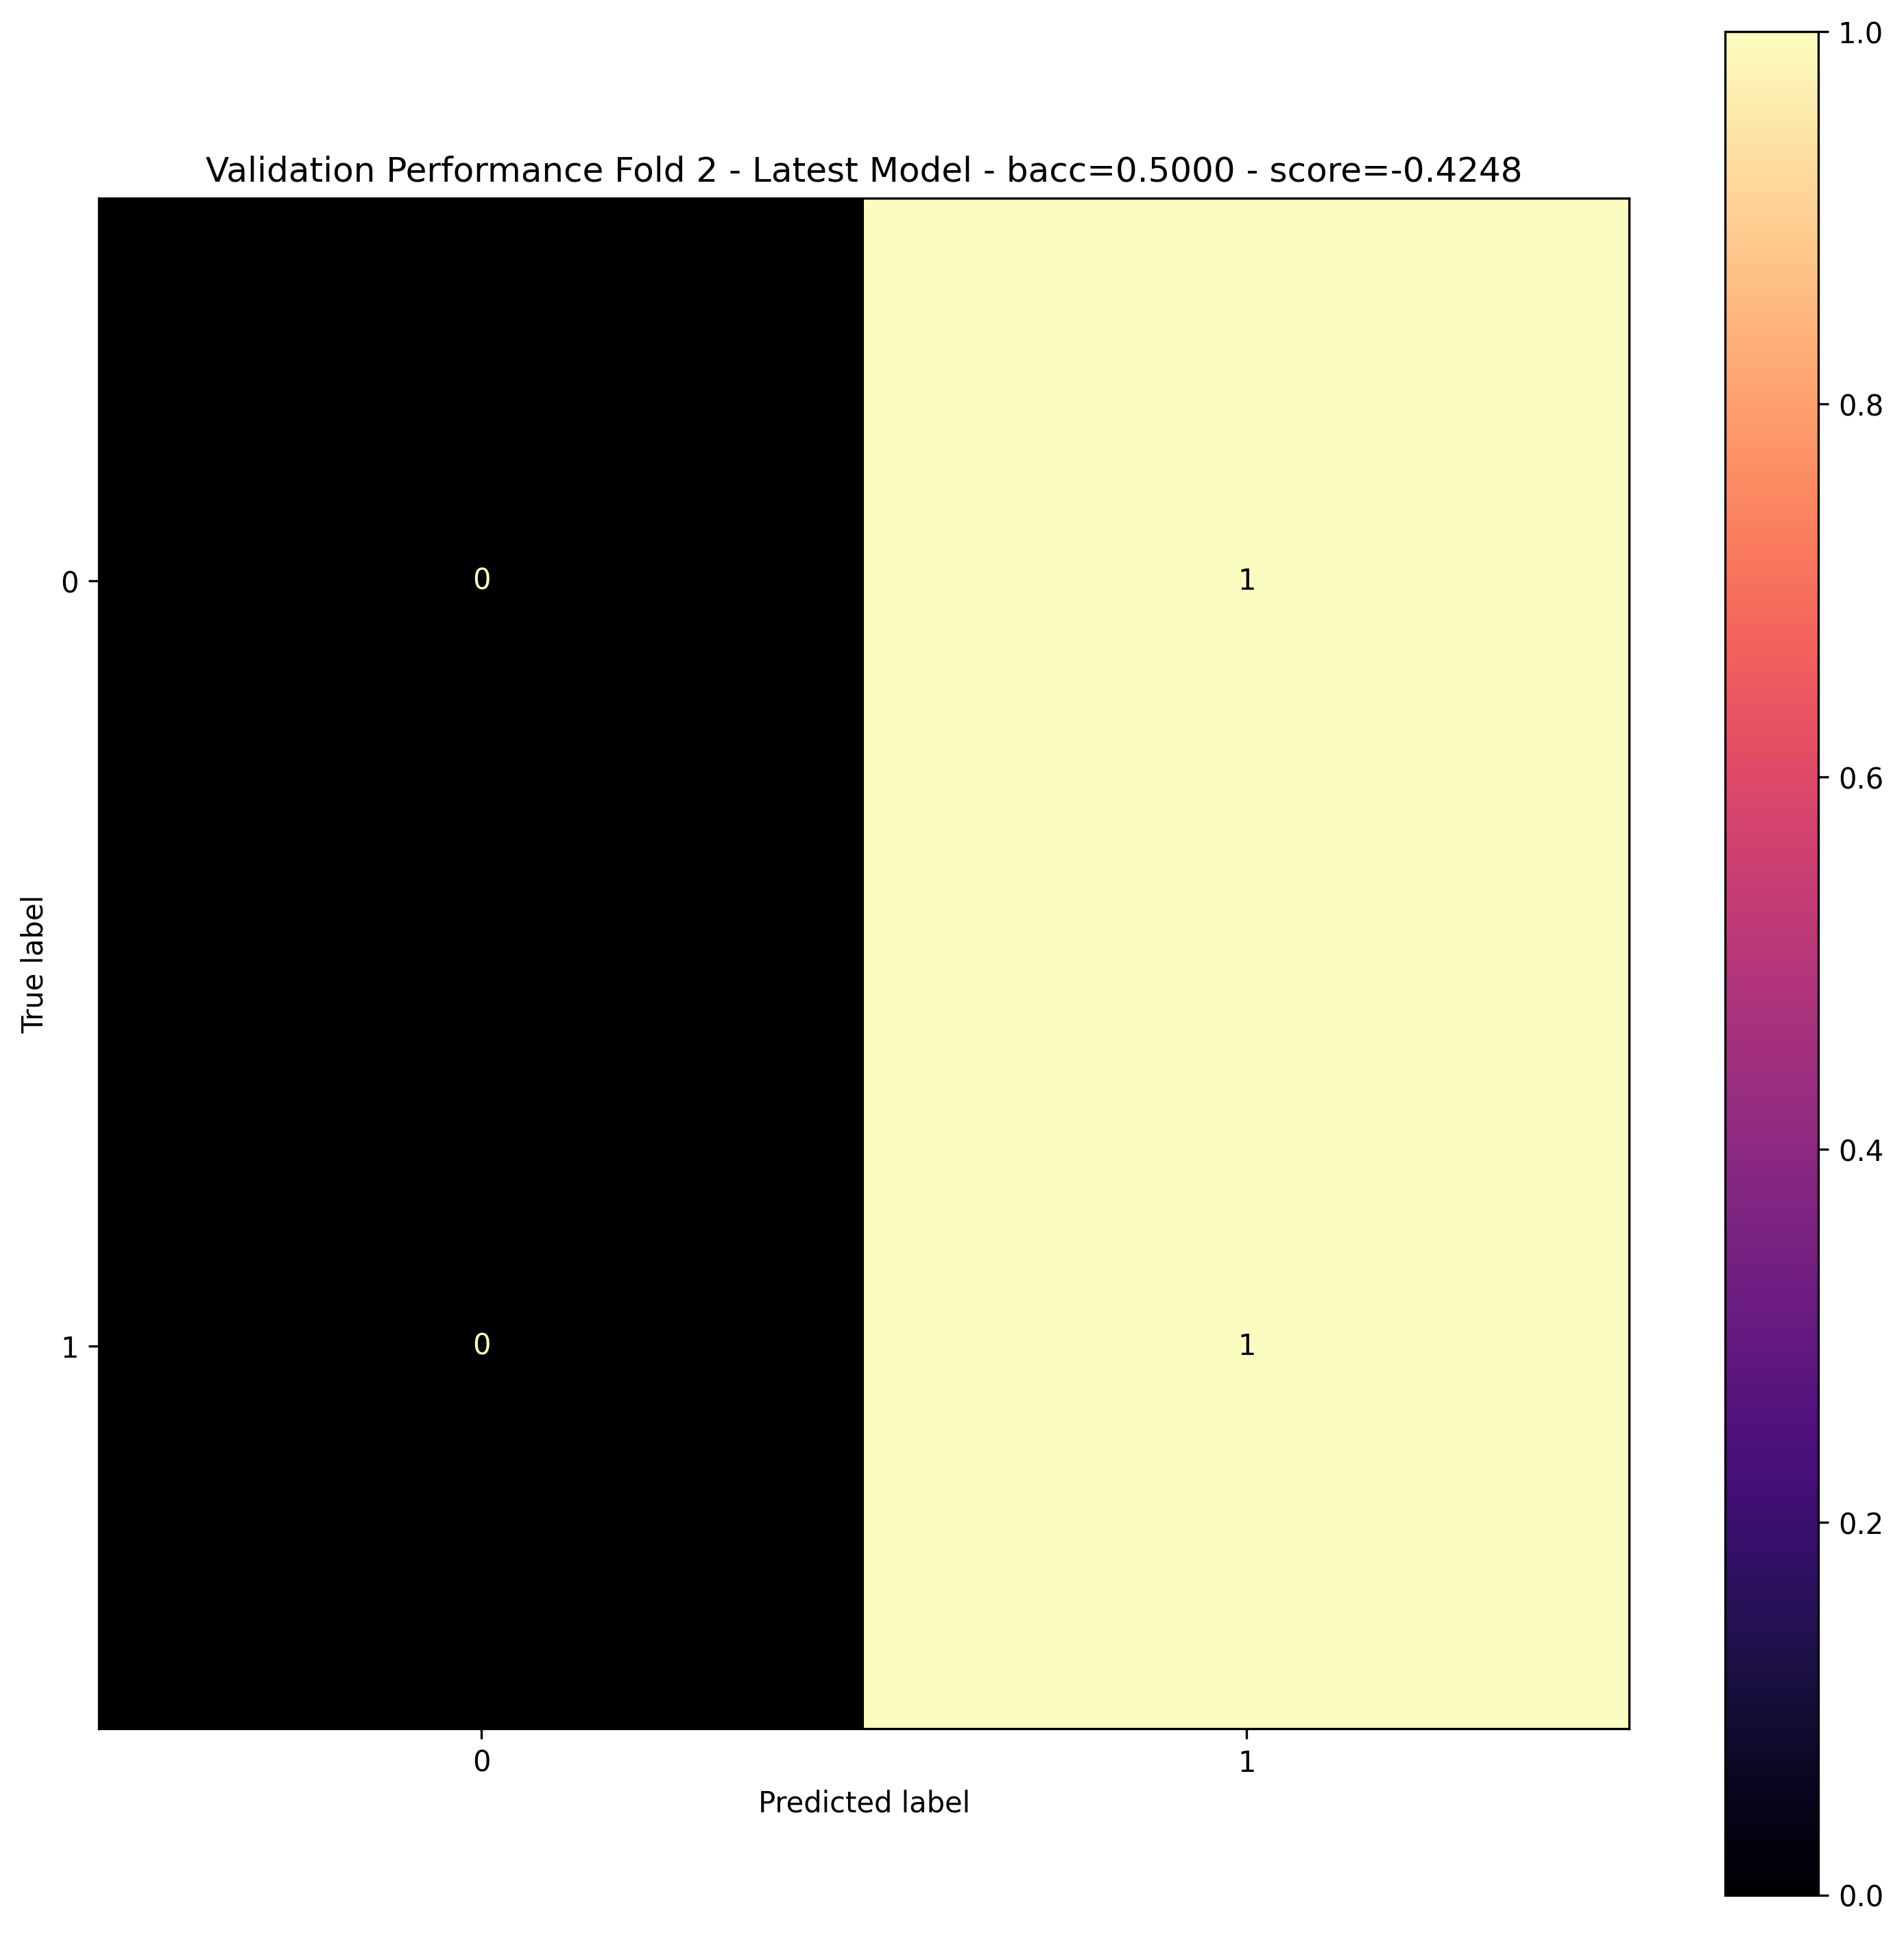

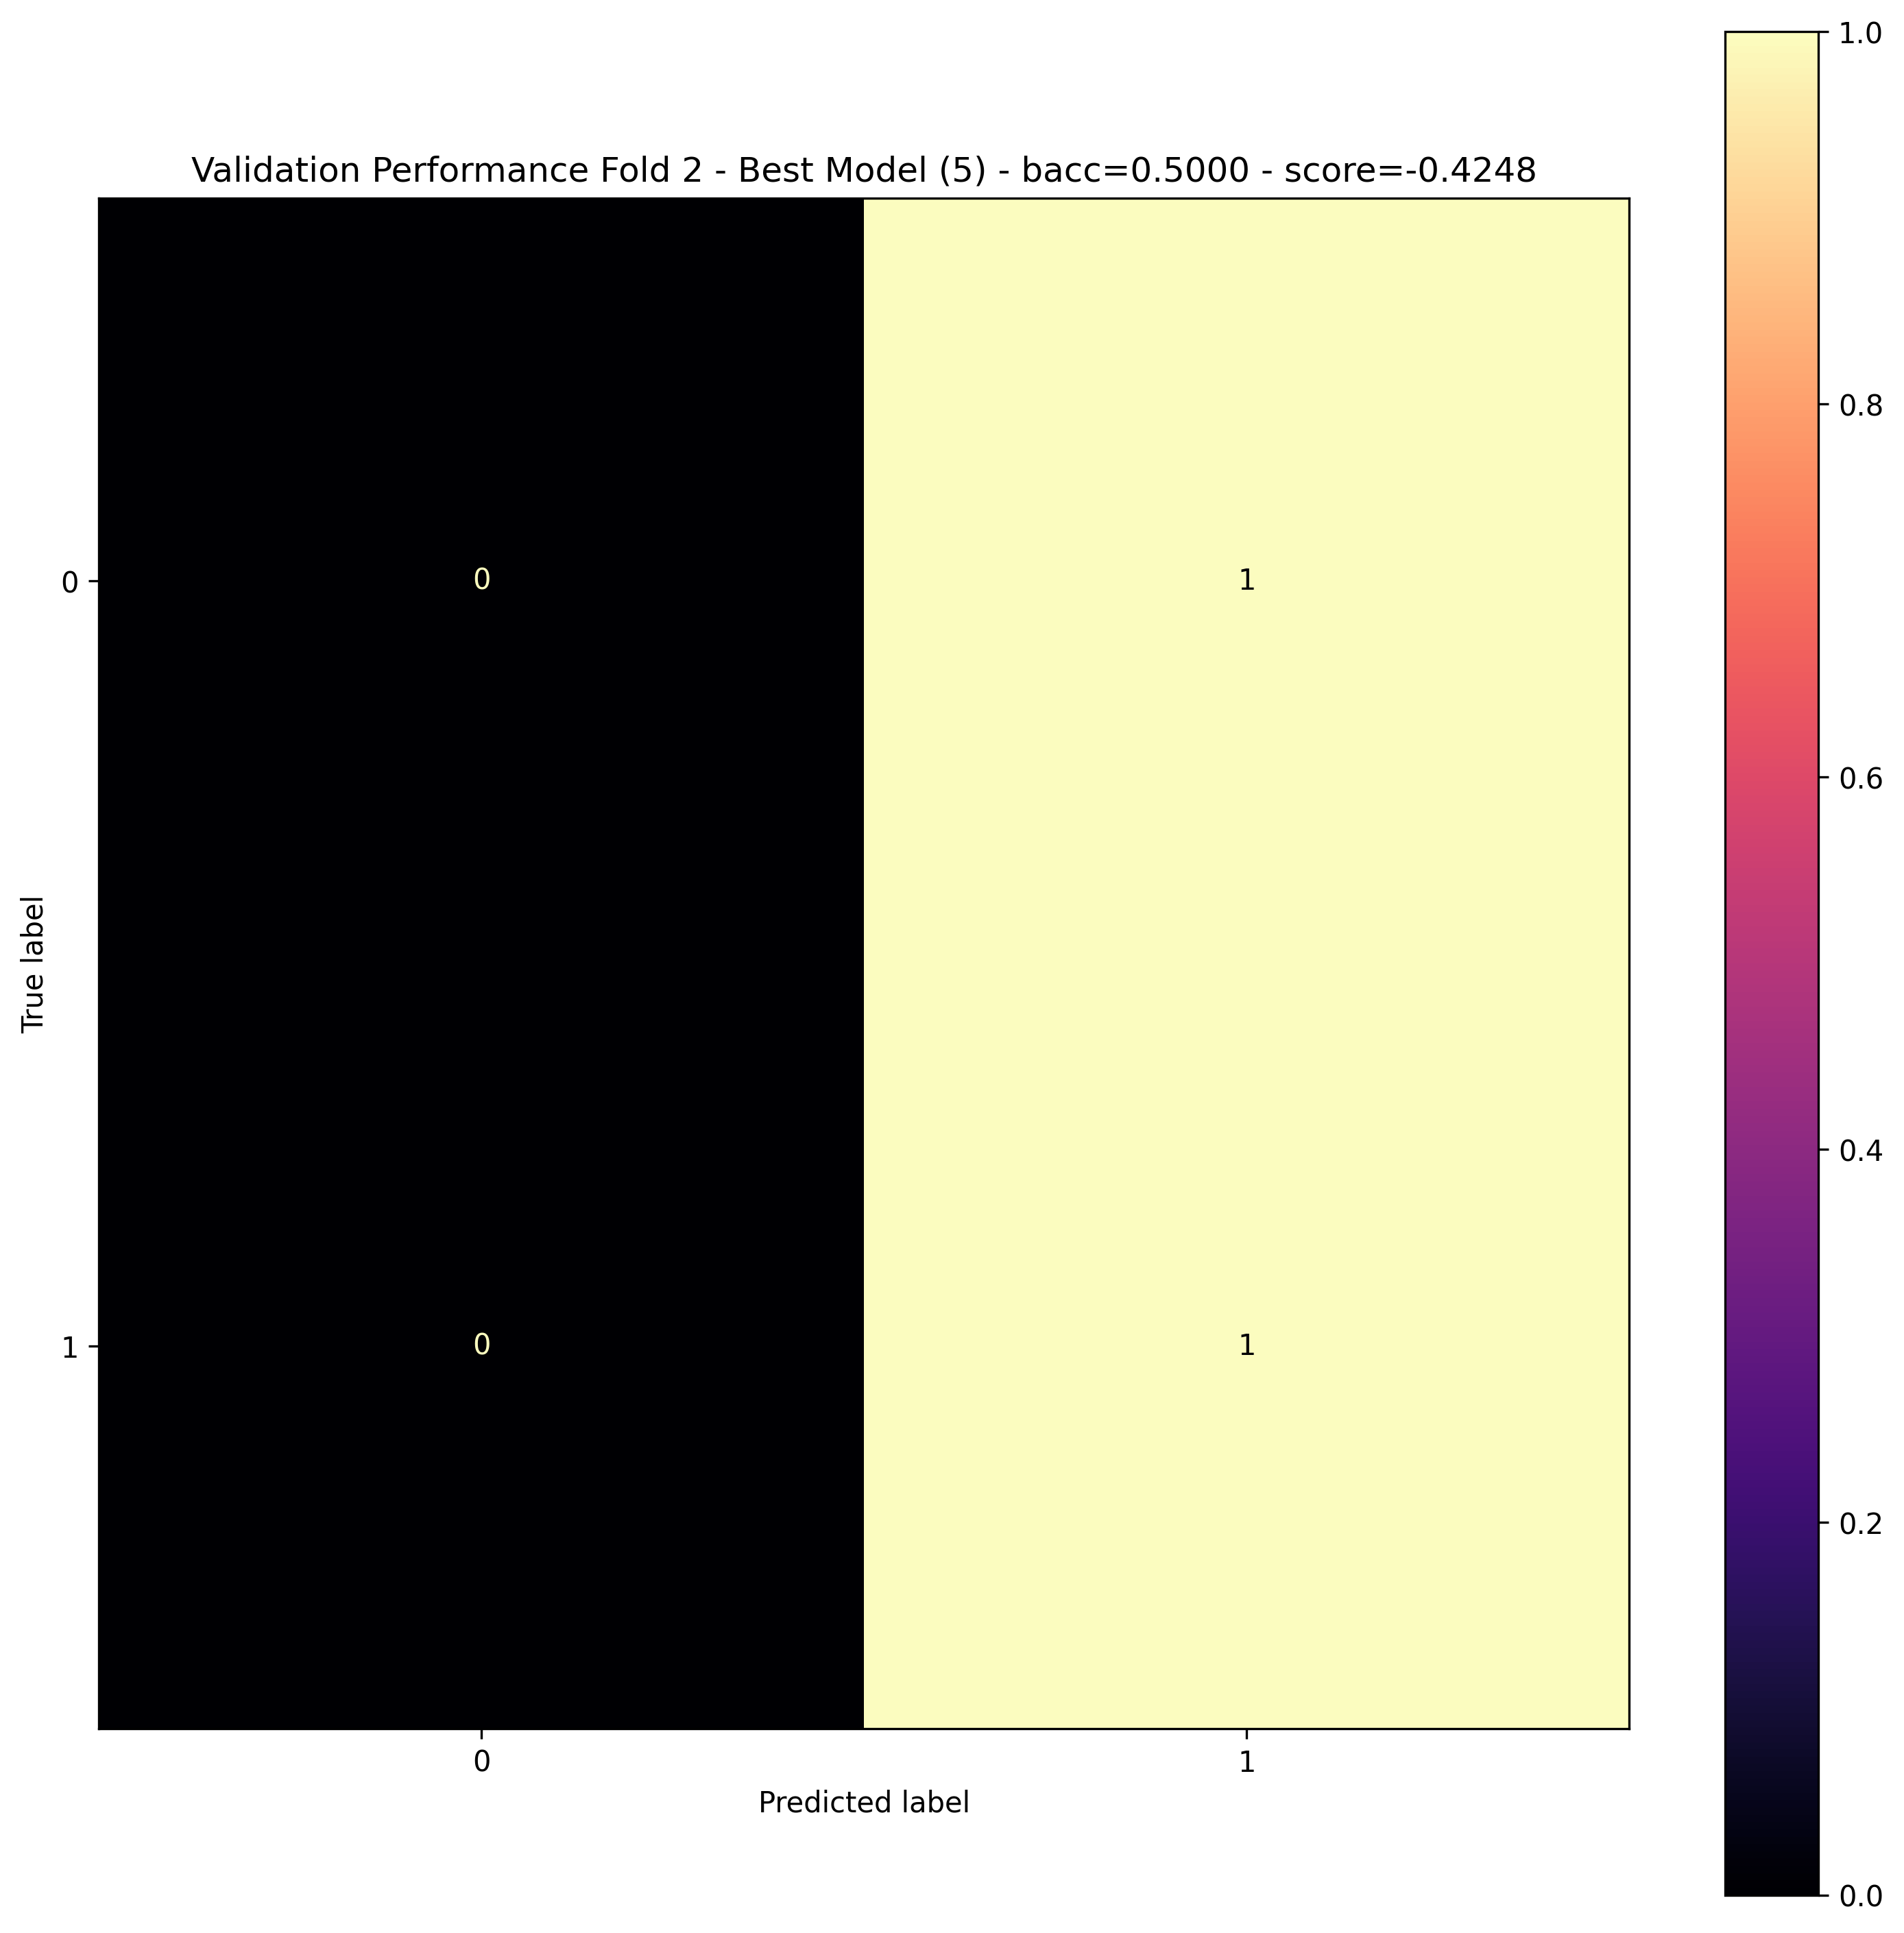


Testing fold 2


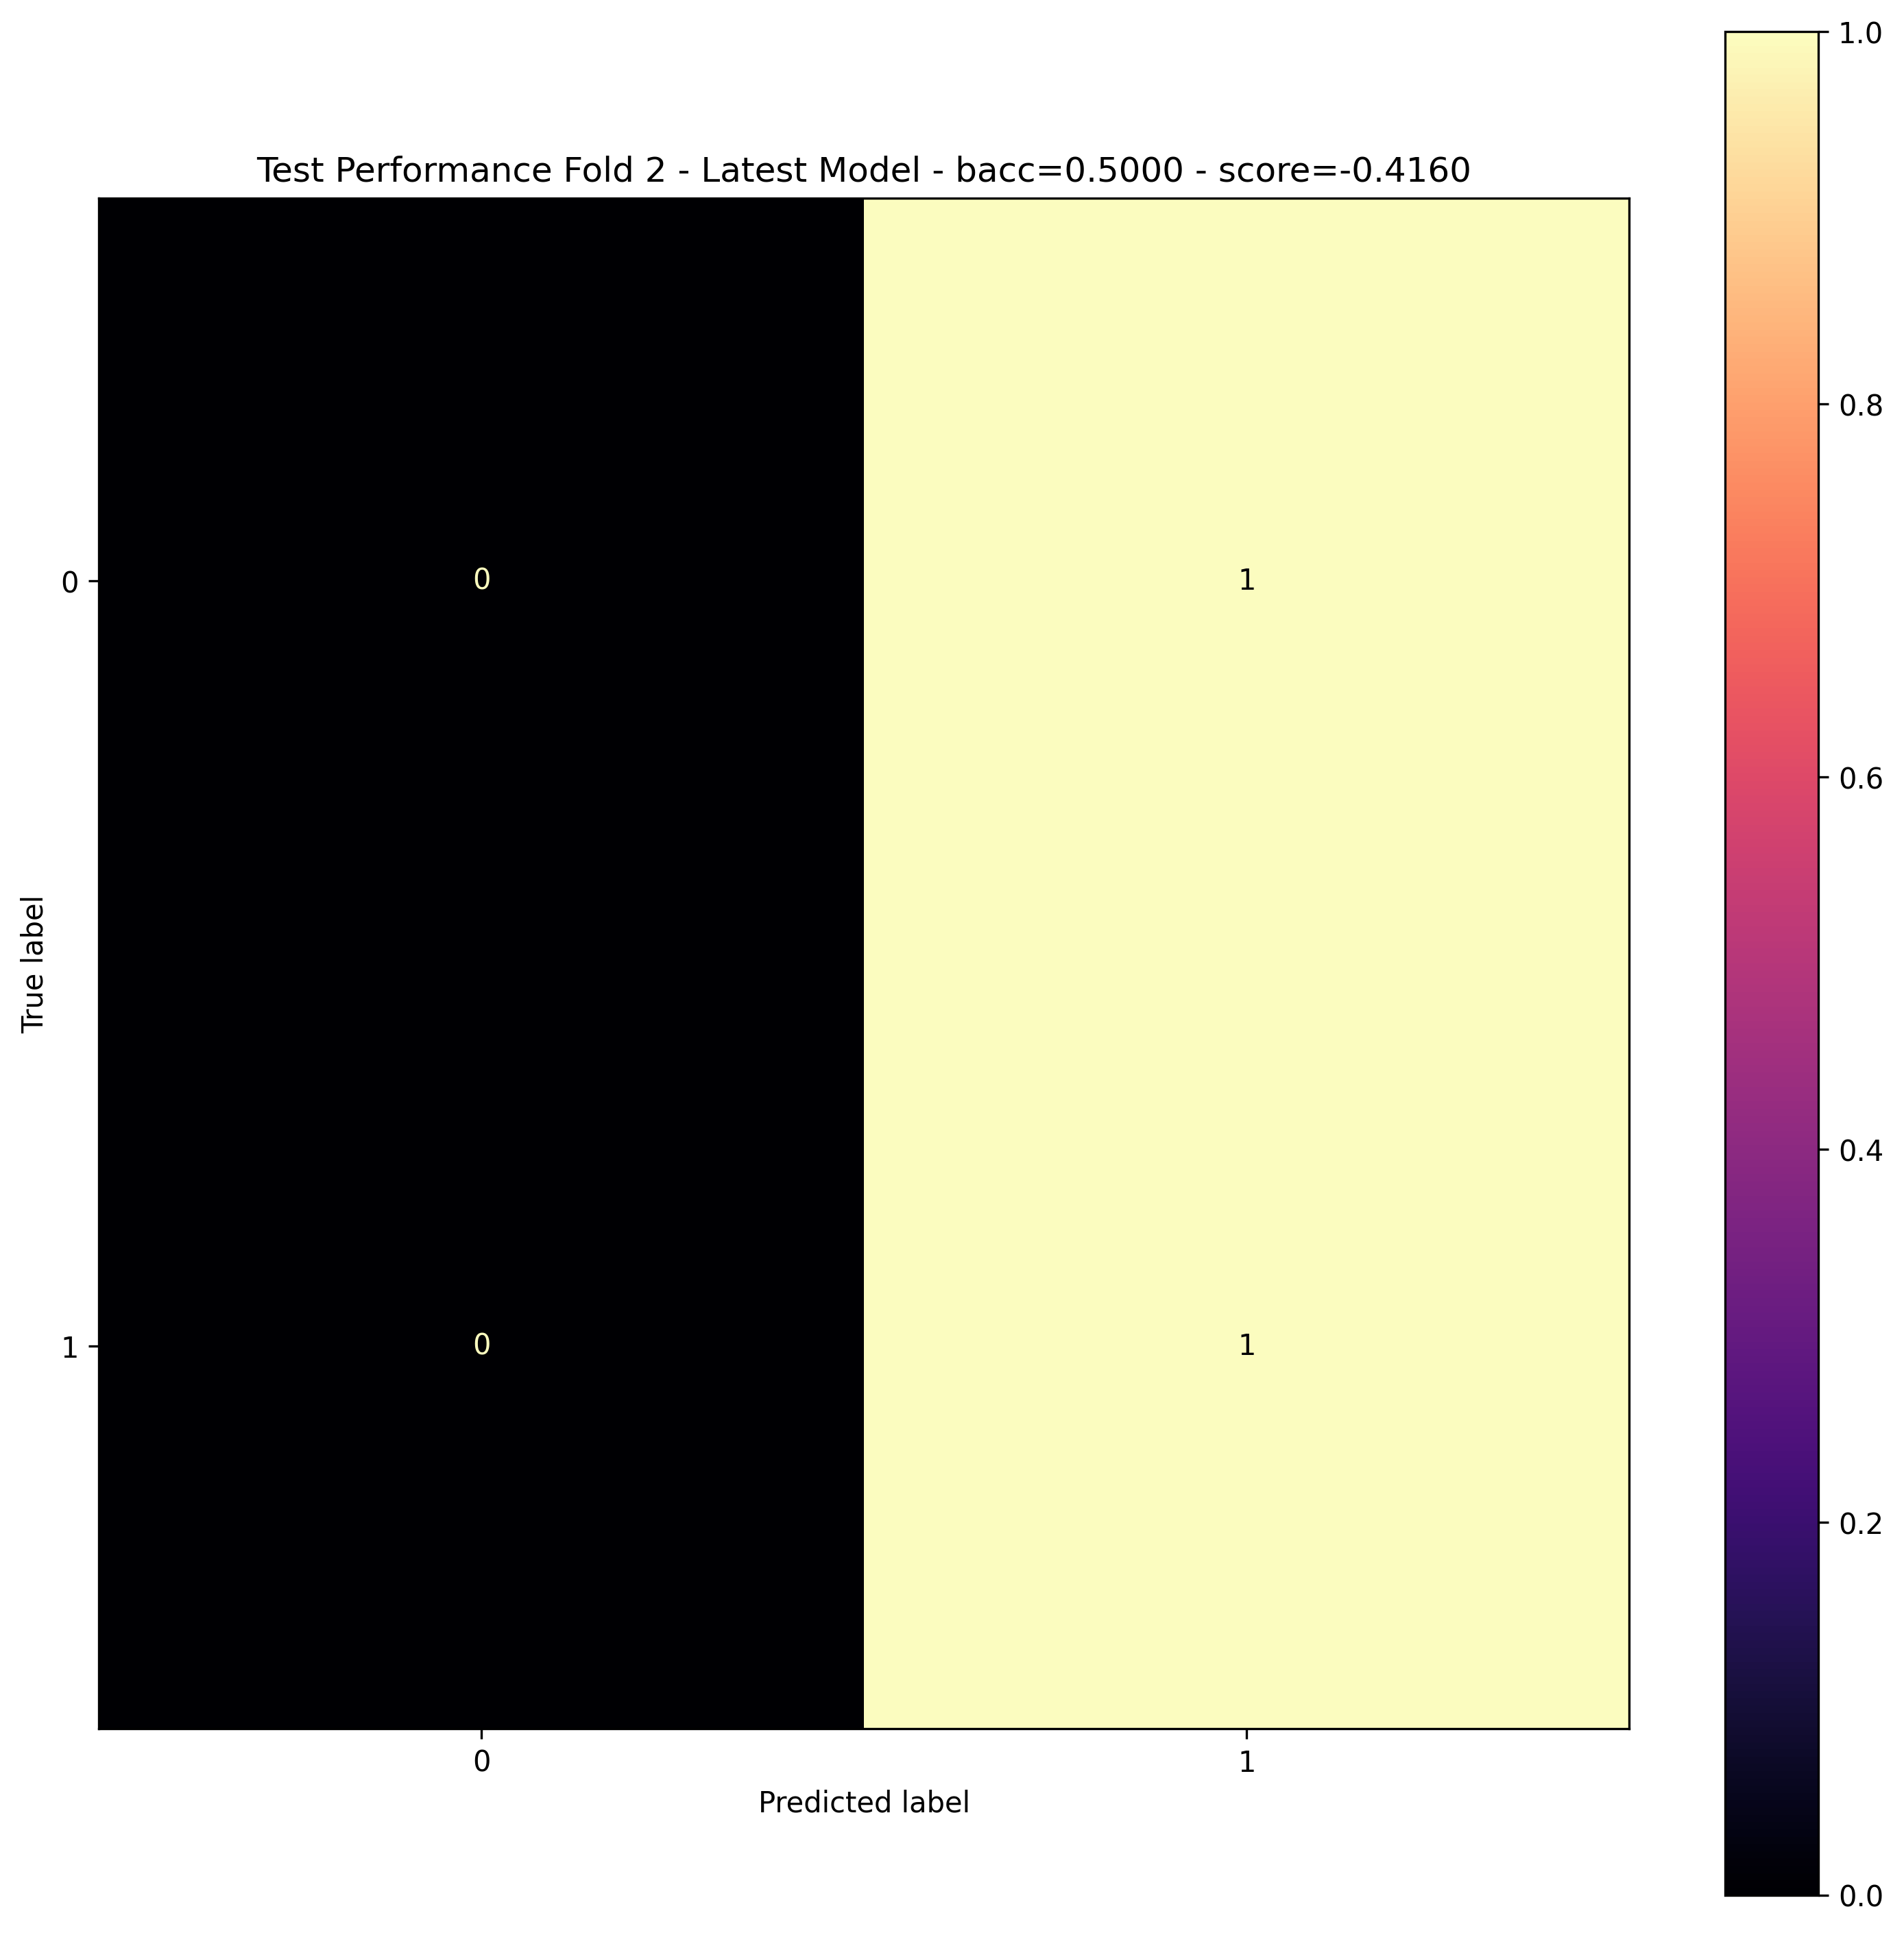

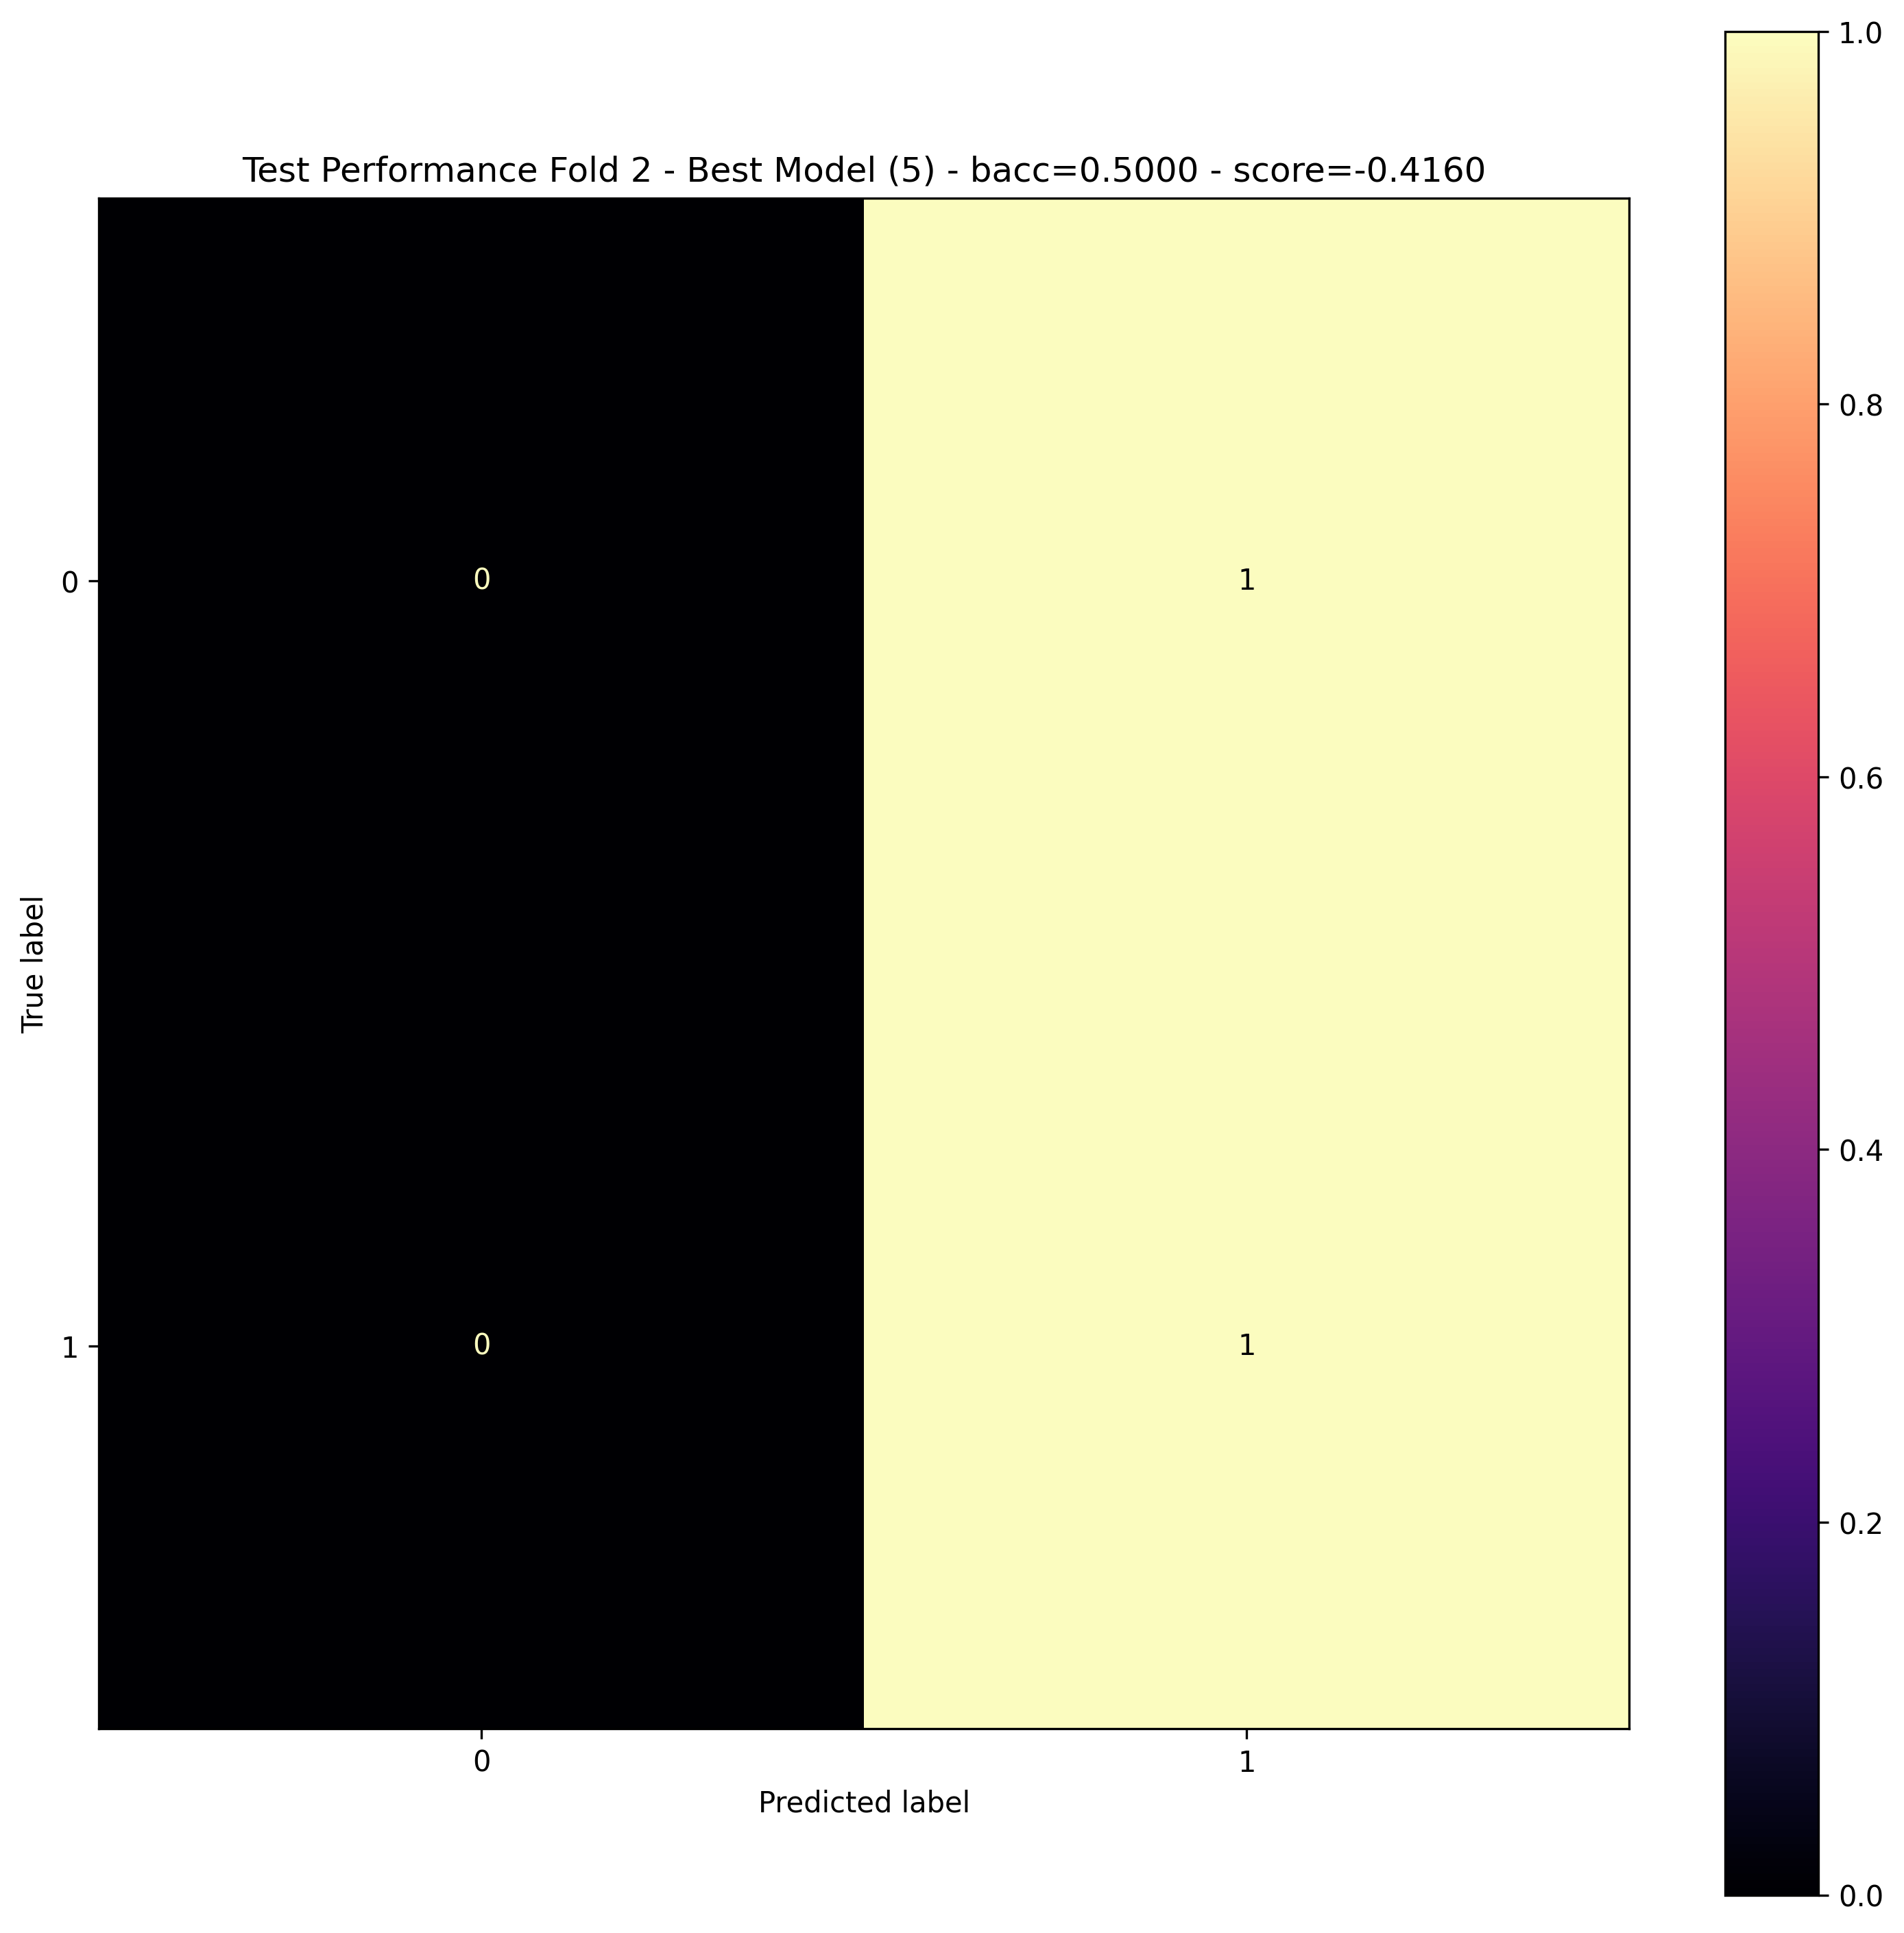

CV Folds:  38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 3/8 [00:20<00:33,  6.68s/it]

Best Model Test Metrics: avg_loss = 0.000114, num_samples = 24000, num_correct =  7008, acc = 0.292000, bacc = 0.500000, score = -0.416000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-2-best eval-score=-0.4248 test-score=-0.4160"



Executing CV for fold 3
Training fold 3


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59829, 24171]
eval label counts  = [ 8537,  3463]

loss weights                    = [ 0.50,  2.48]
eval loss weights (theoretical) = [ 0.50,  2.47]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000070, num_samples = 84000, num_correct = 24171, acc = 0.287750, bacc = 0.500000, score = -0.424500
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000141, num_samples = 12000, num_correct =  3463, acc = 0.288583, bacc = 0.500000, score = -0.422833
Training Epoch   2/5  : lr = 1.00E-03, epoc

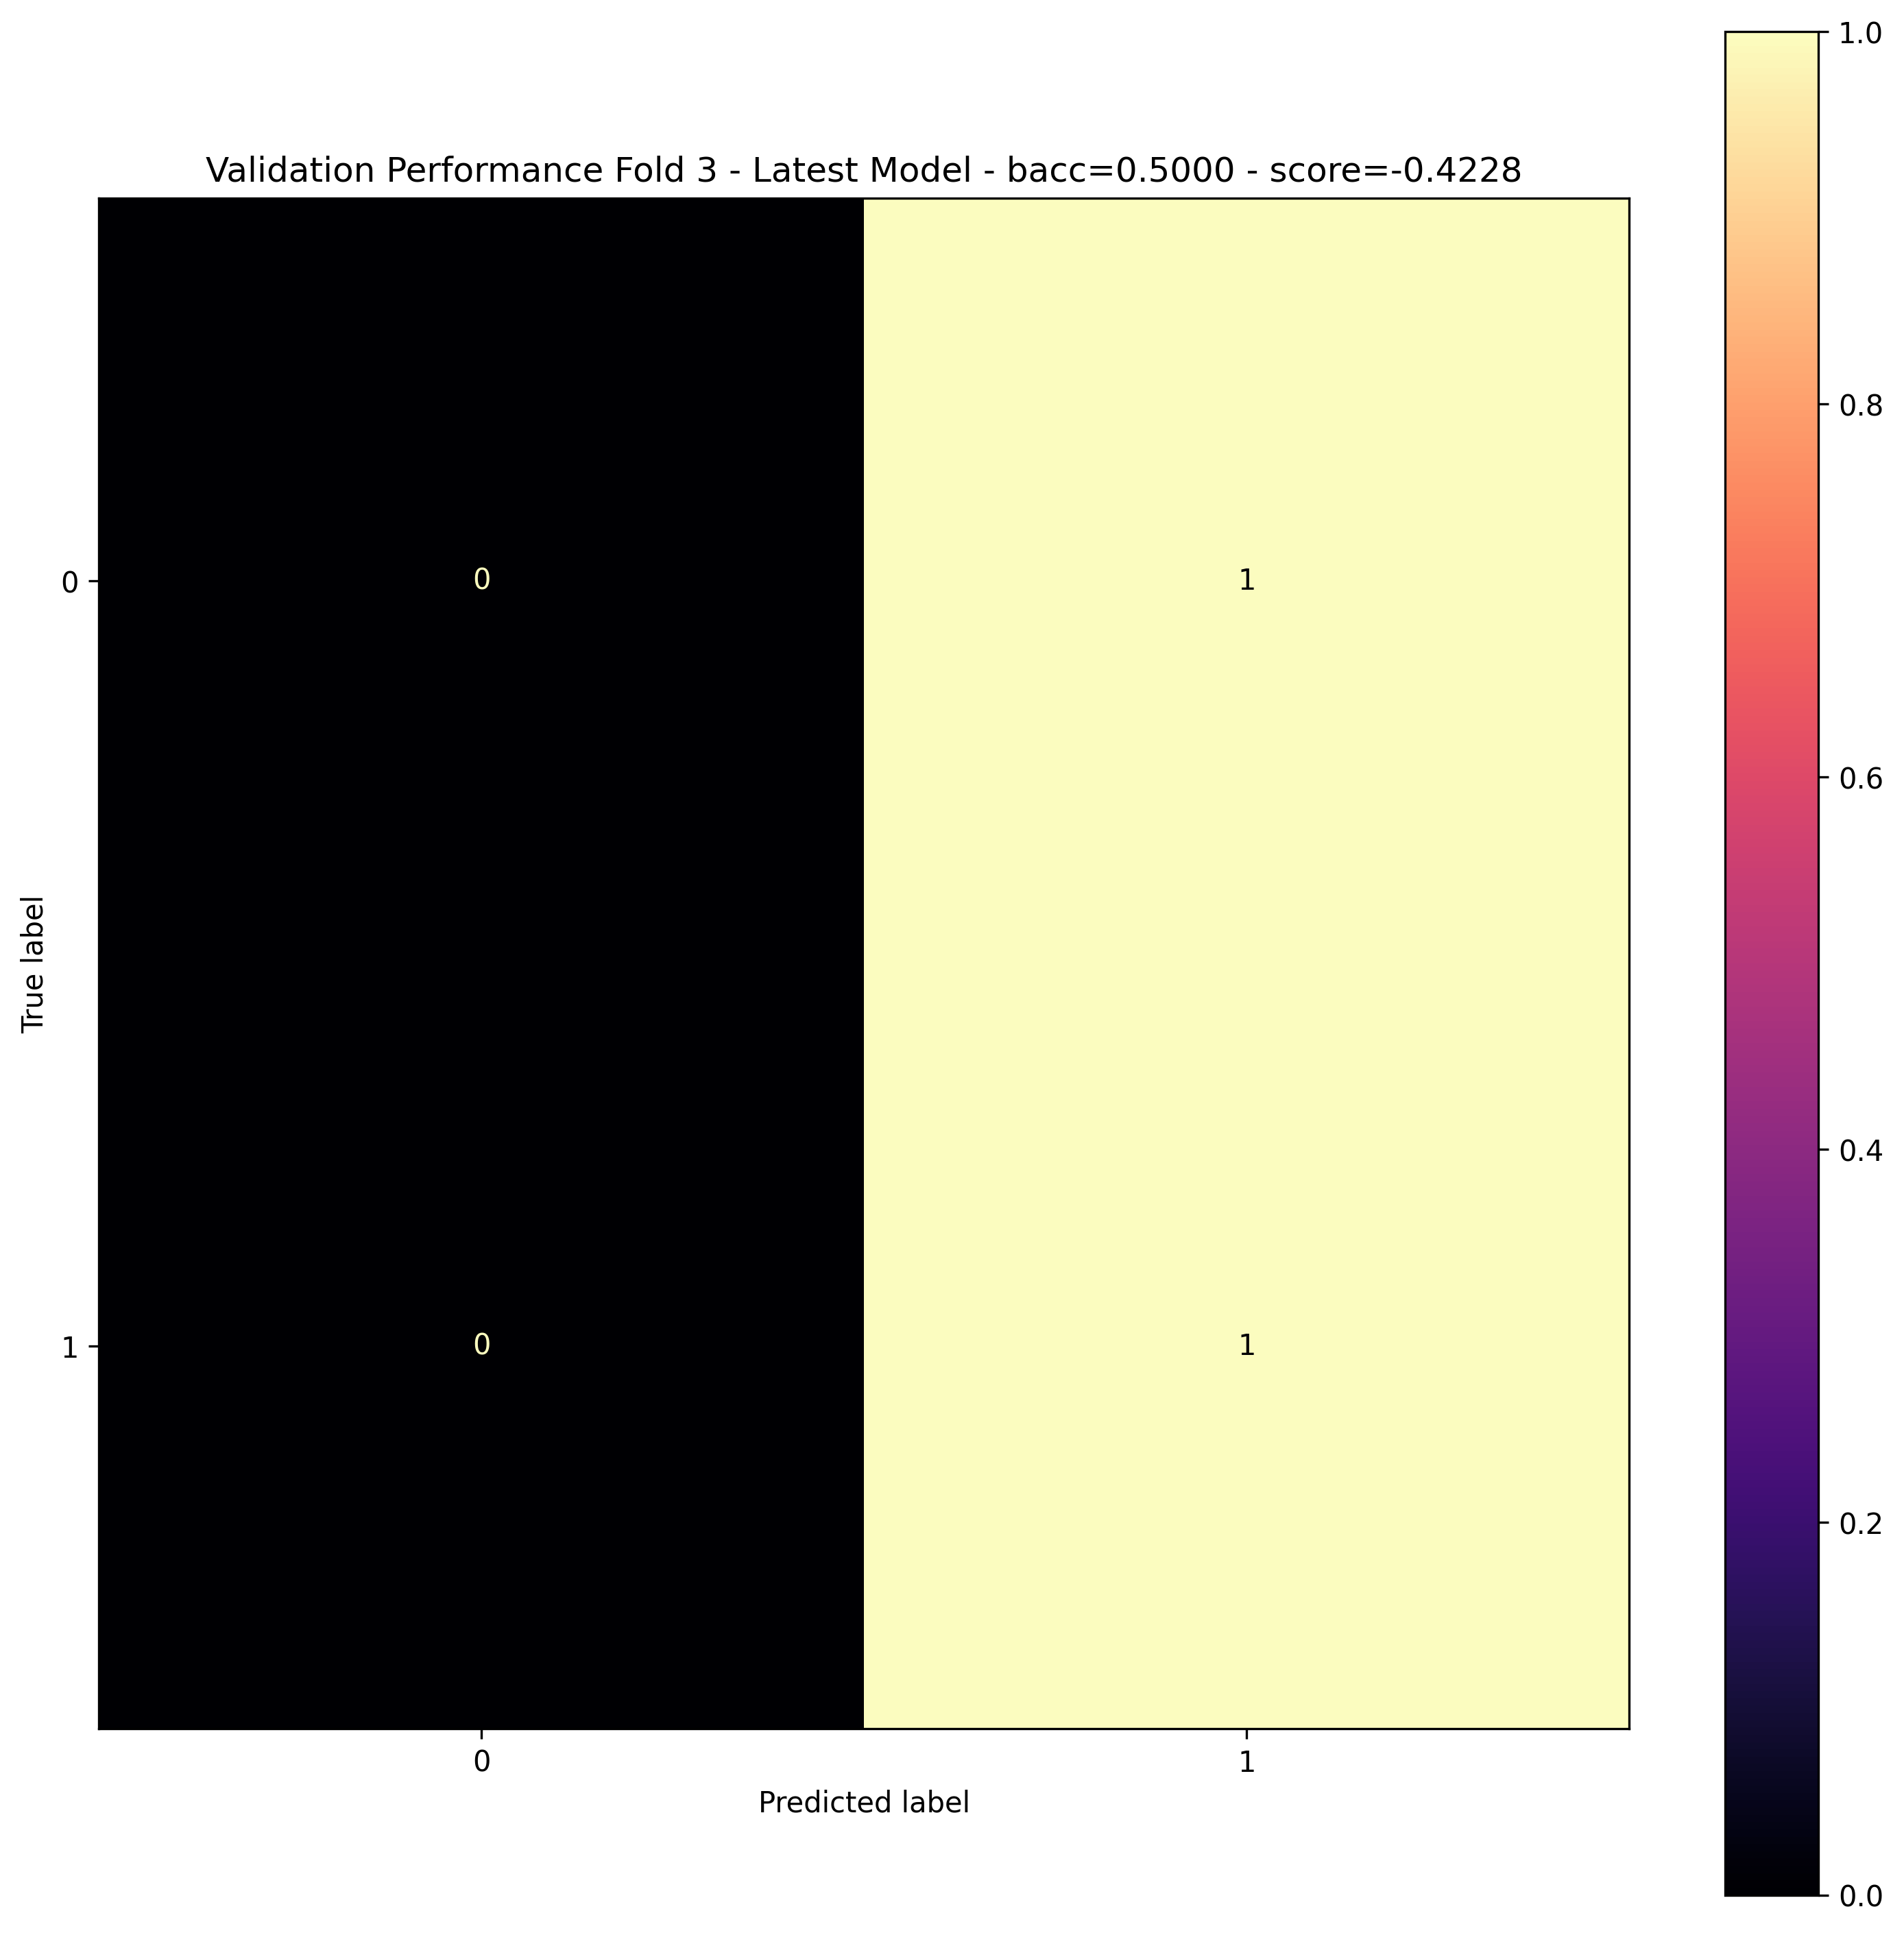

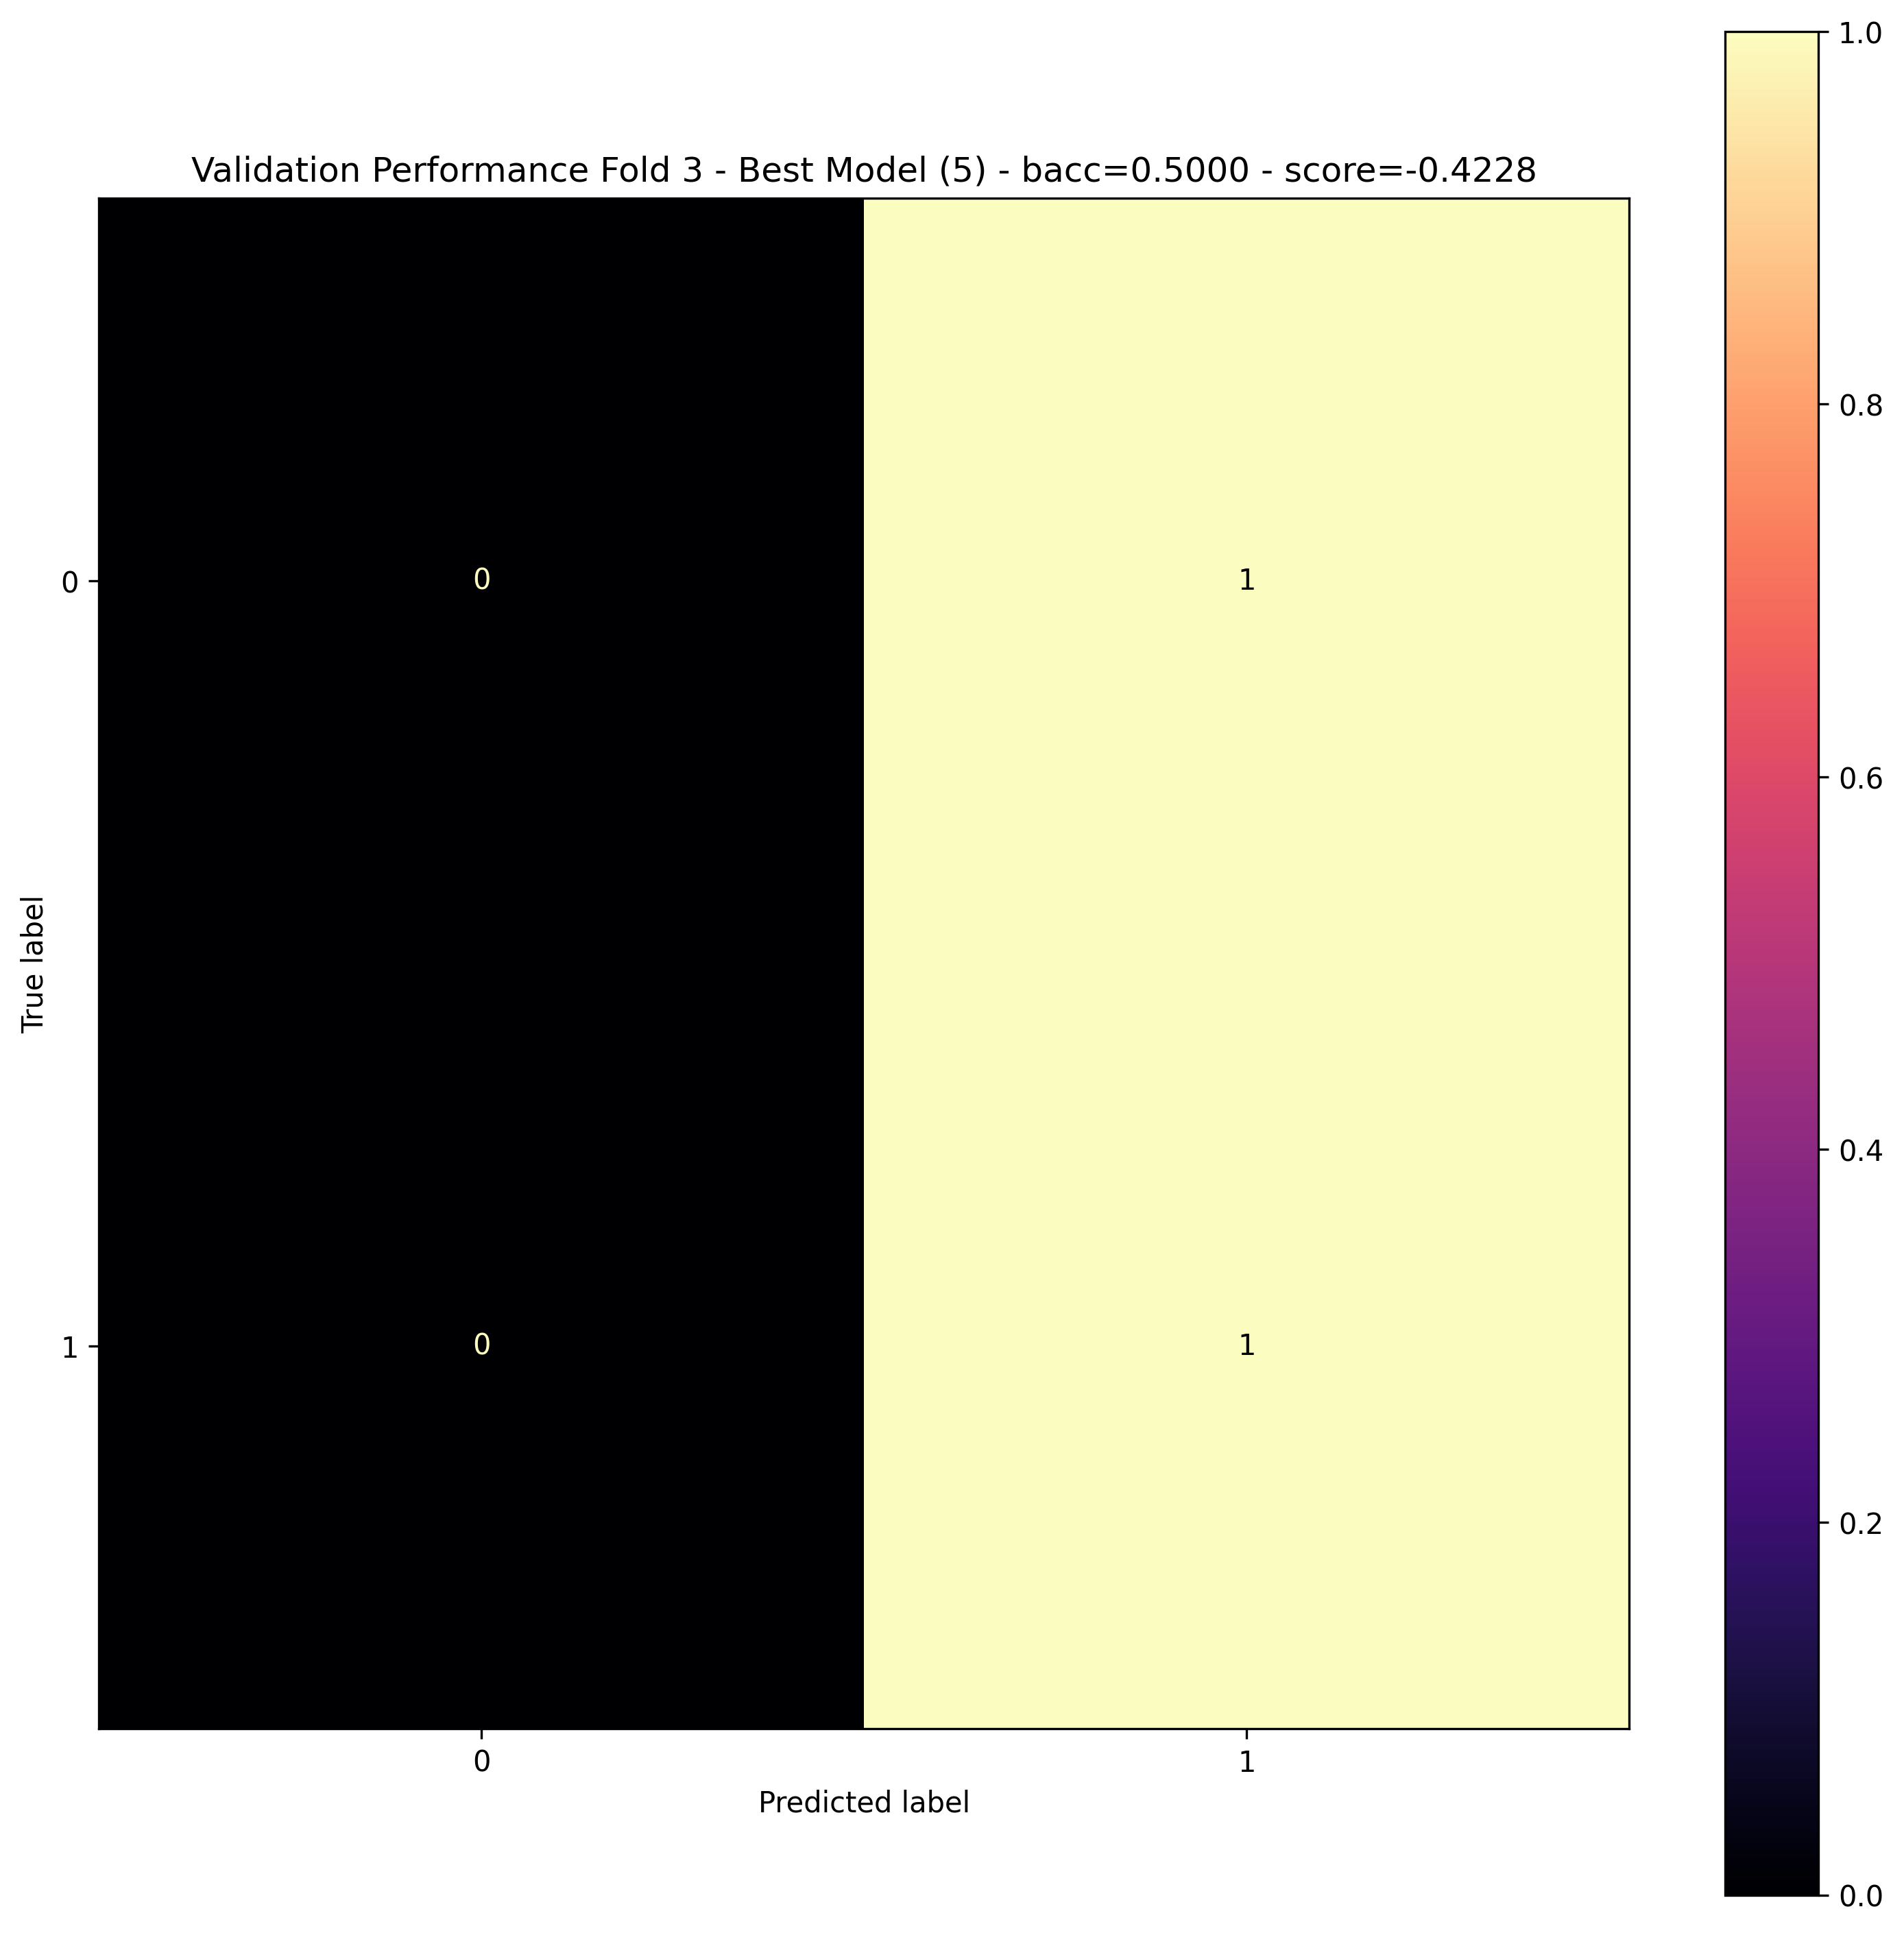


Testing fold 3


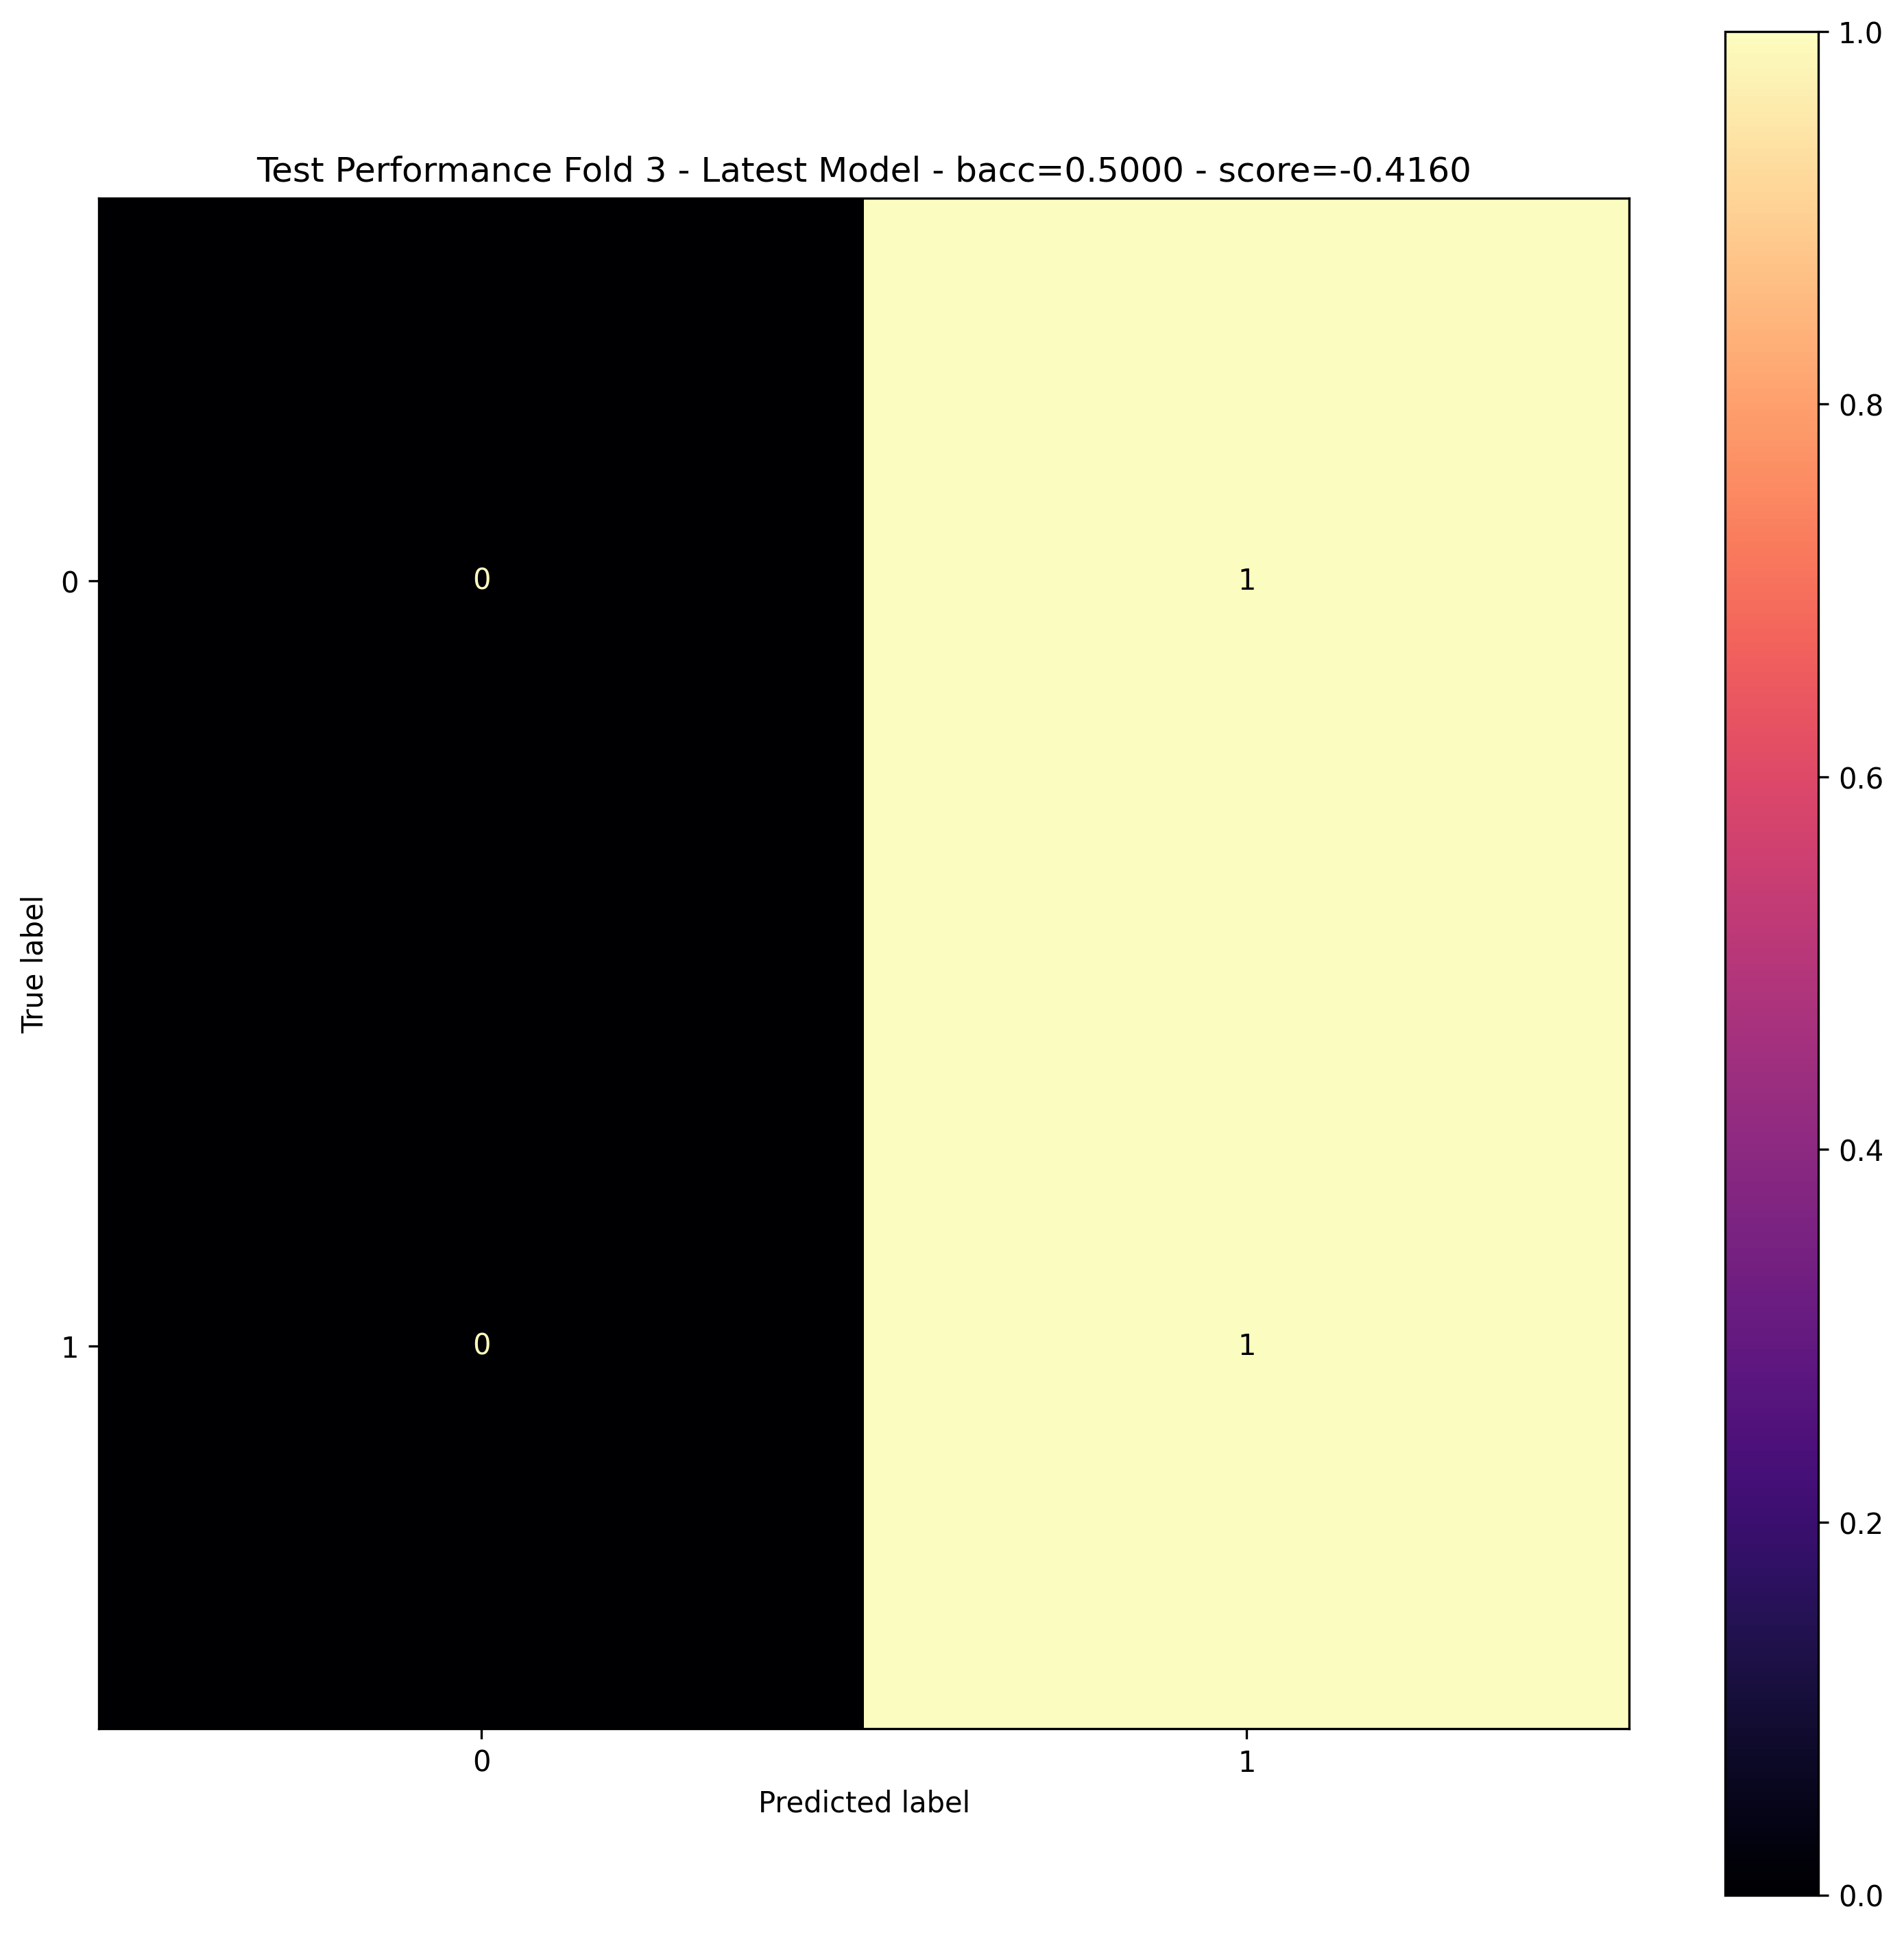

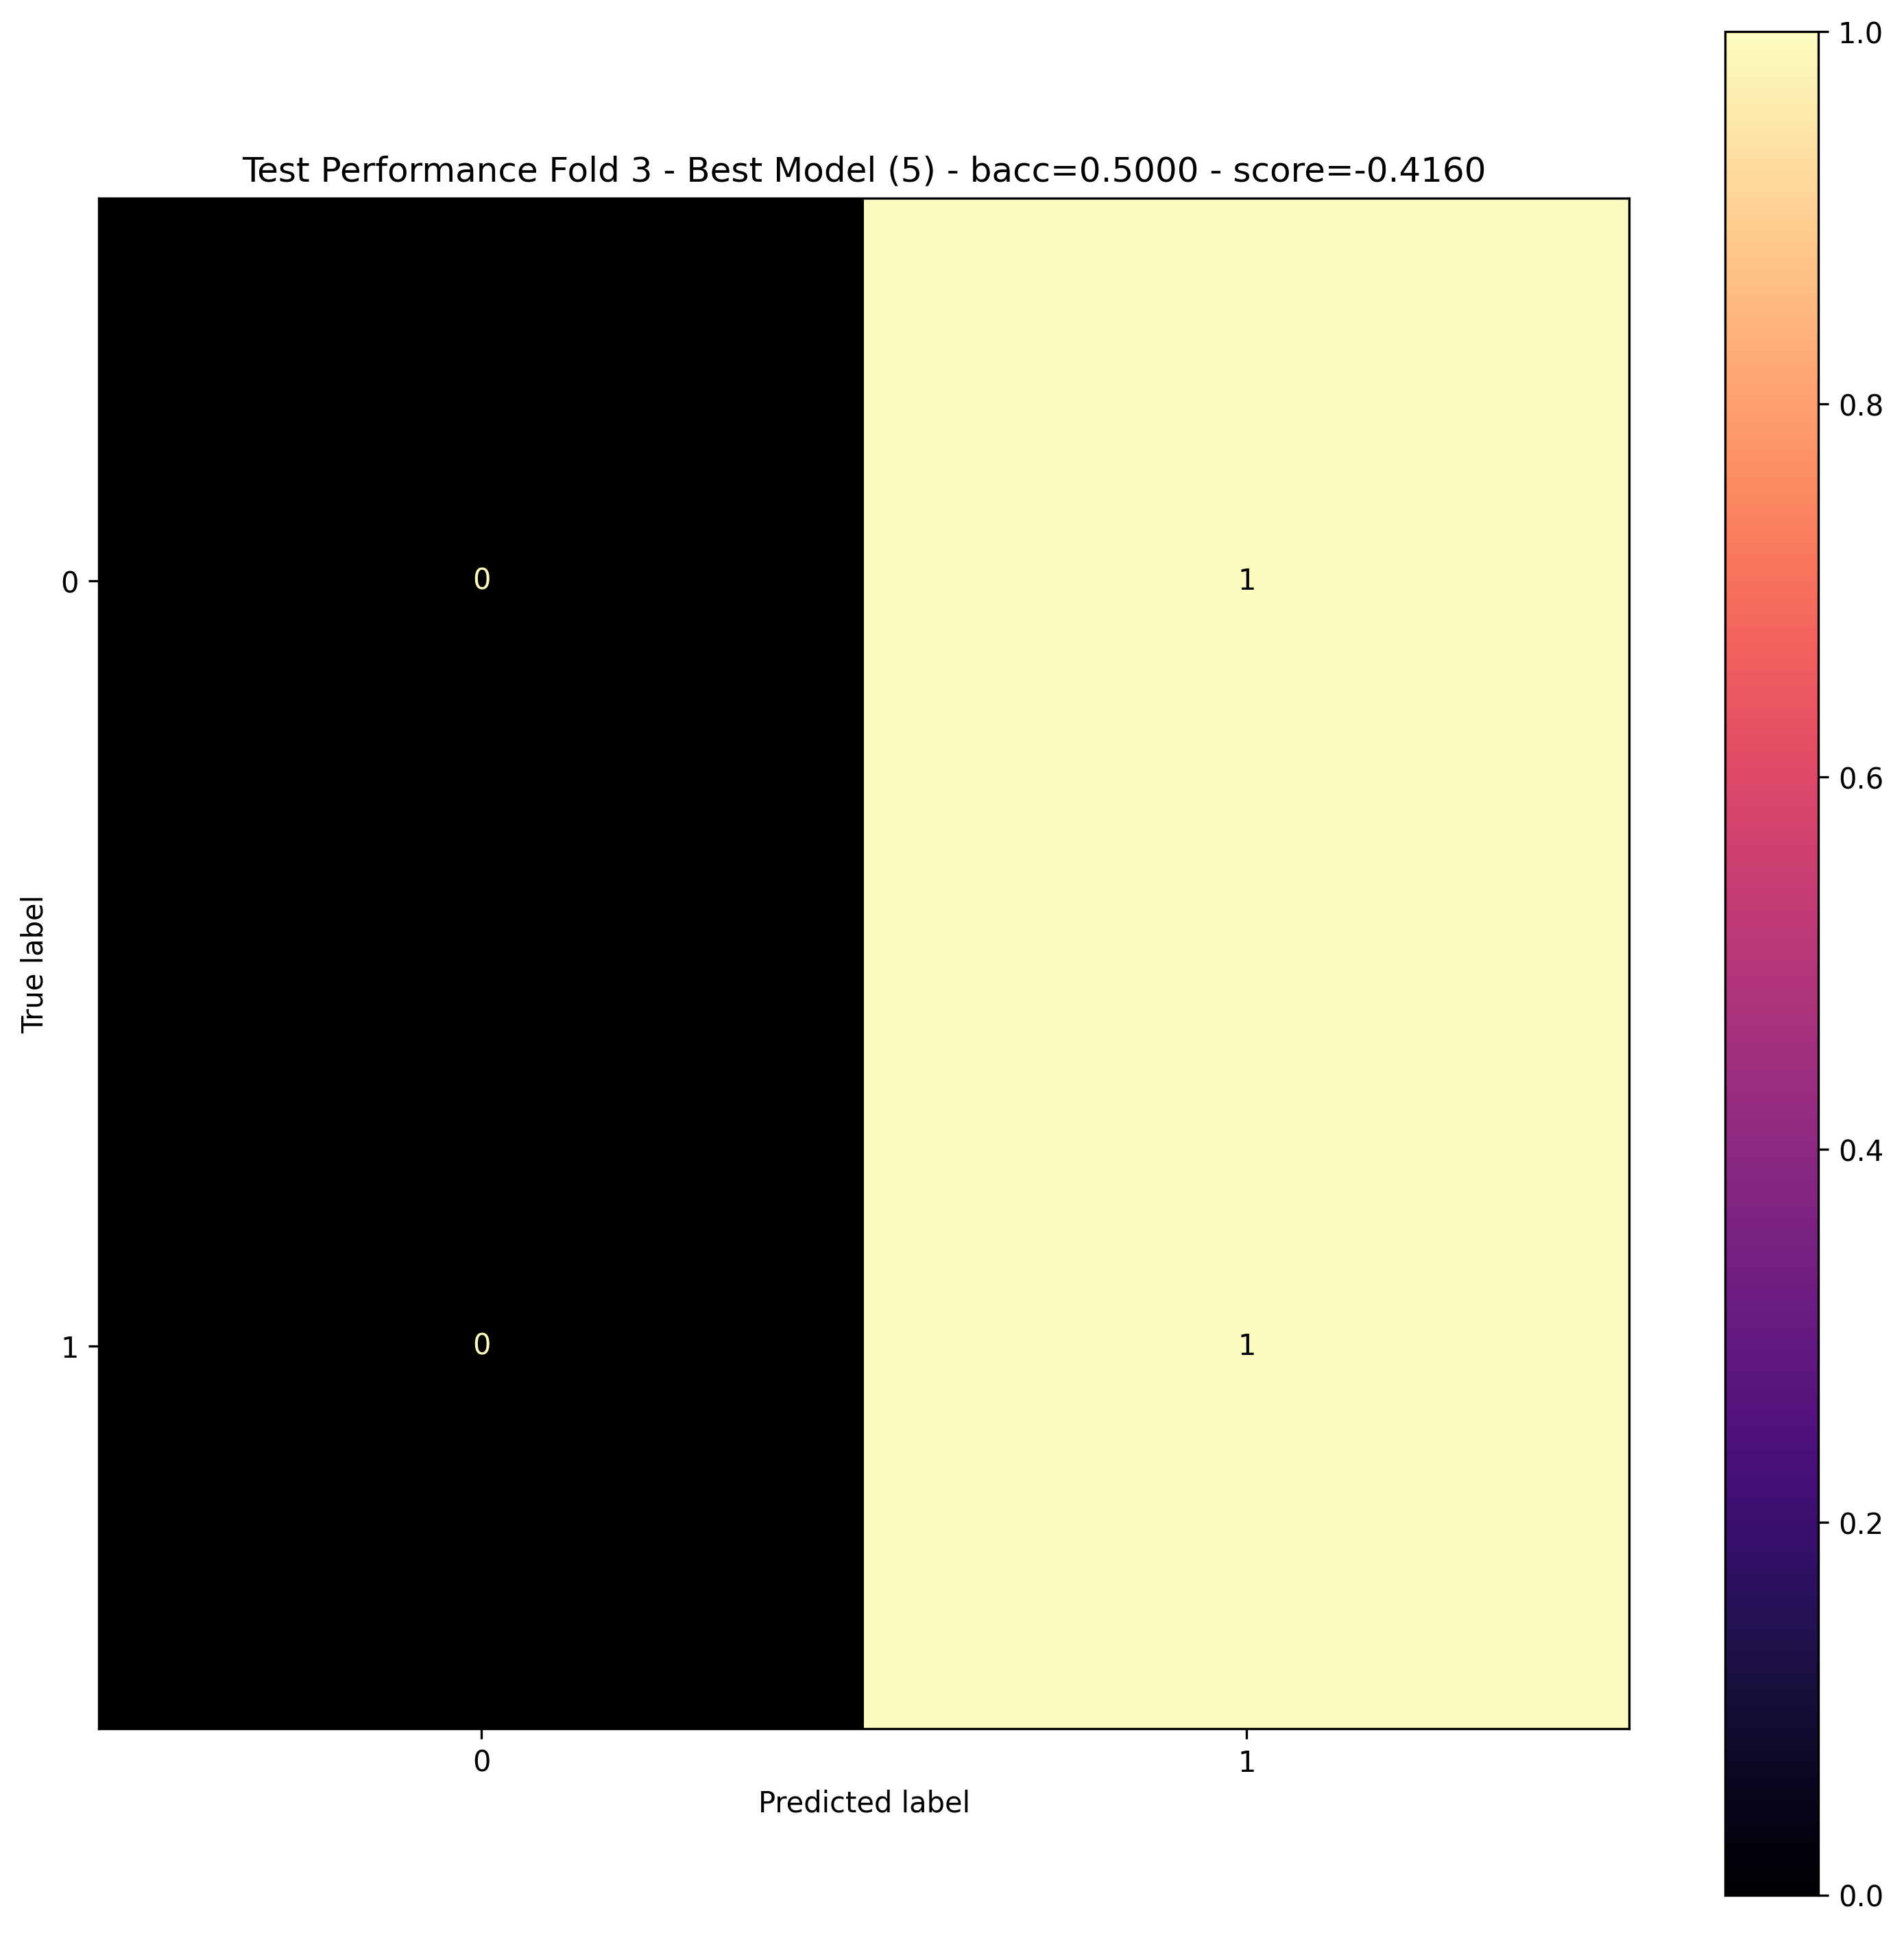

CV Folds:  50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 4/8 [00:26<00:26,  6.58s/it]

Best Model Test Metrics: avg_loss = 0.000113, num_samples = 24000, num_correct =  7008, acc = 0.292000, bacc = 0.500000, score = -0.416000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-3-best eval-score=-0.4228 test-score=-0.4160"



Executing CV for fold 4
Training fold 4


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59834, 24166]
eval label counts  = [ 8532,  3468]

loss weights                    = [ 0.50,  2.48]
eval loss weights (theoretical) = [ 0.50,  2.46]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000072, num_samples = 84000, num_correct = 24372, acc = 0.290143, bacc = 0.499822, score = -0.419714
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000128, num_samples = 12000, num_correct =  3468, acc = 0.289000, bacc = 0.500000, score = -0.422000
Training Epoch   2/5  : lr = 1.00E-03, epoc

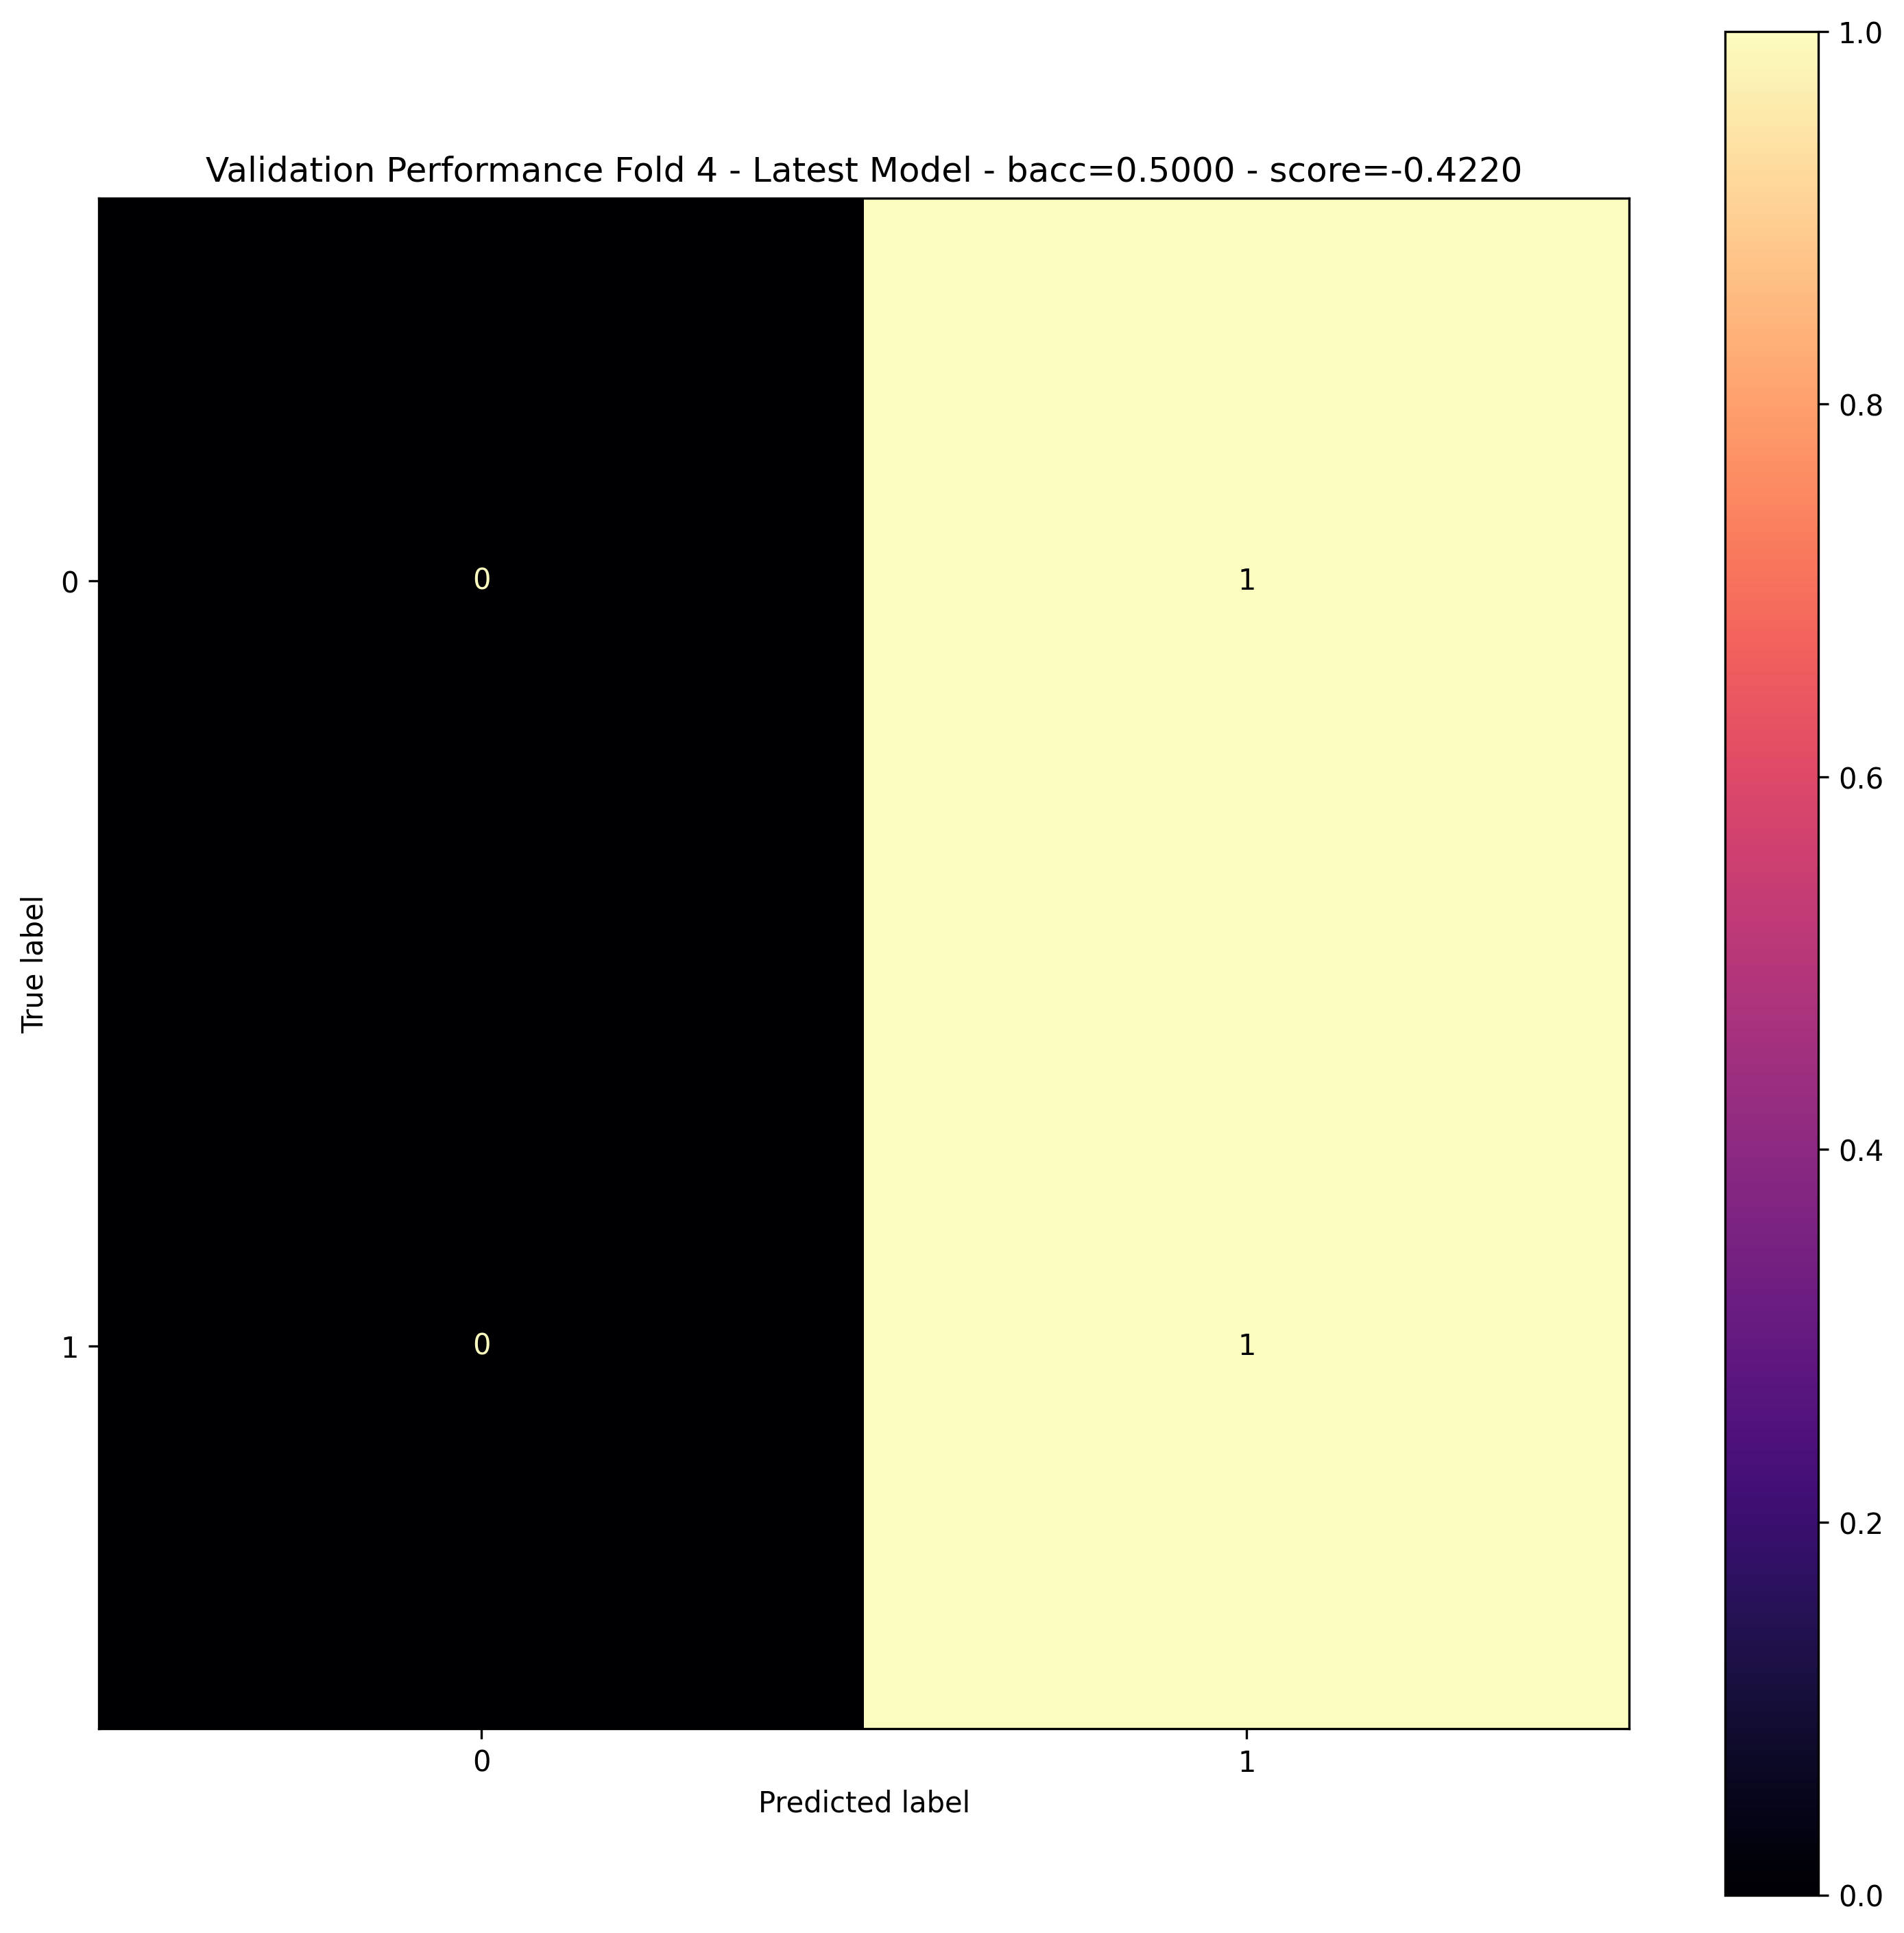

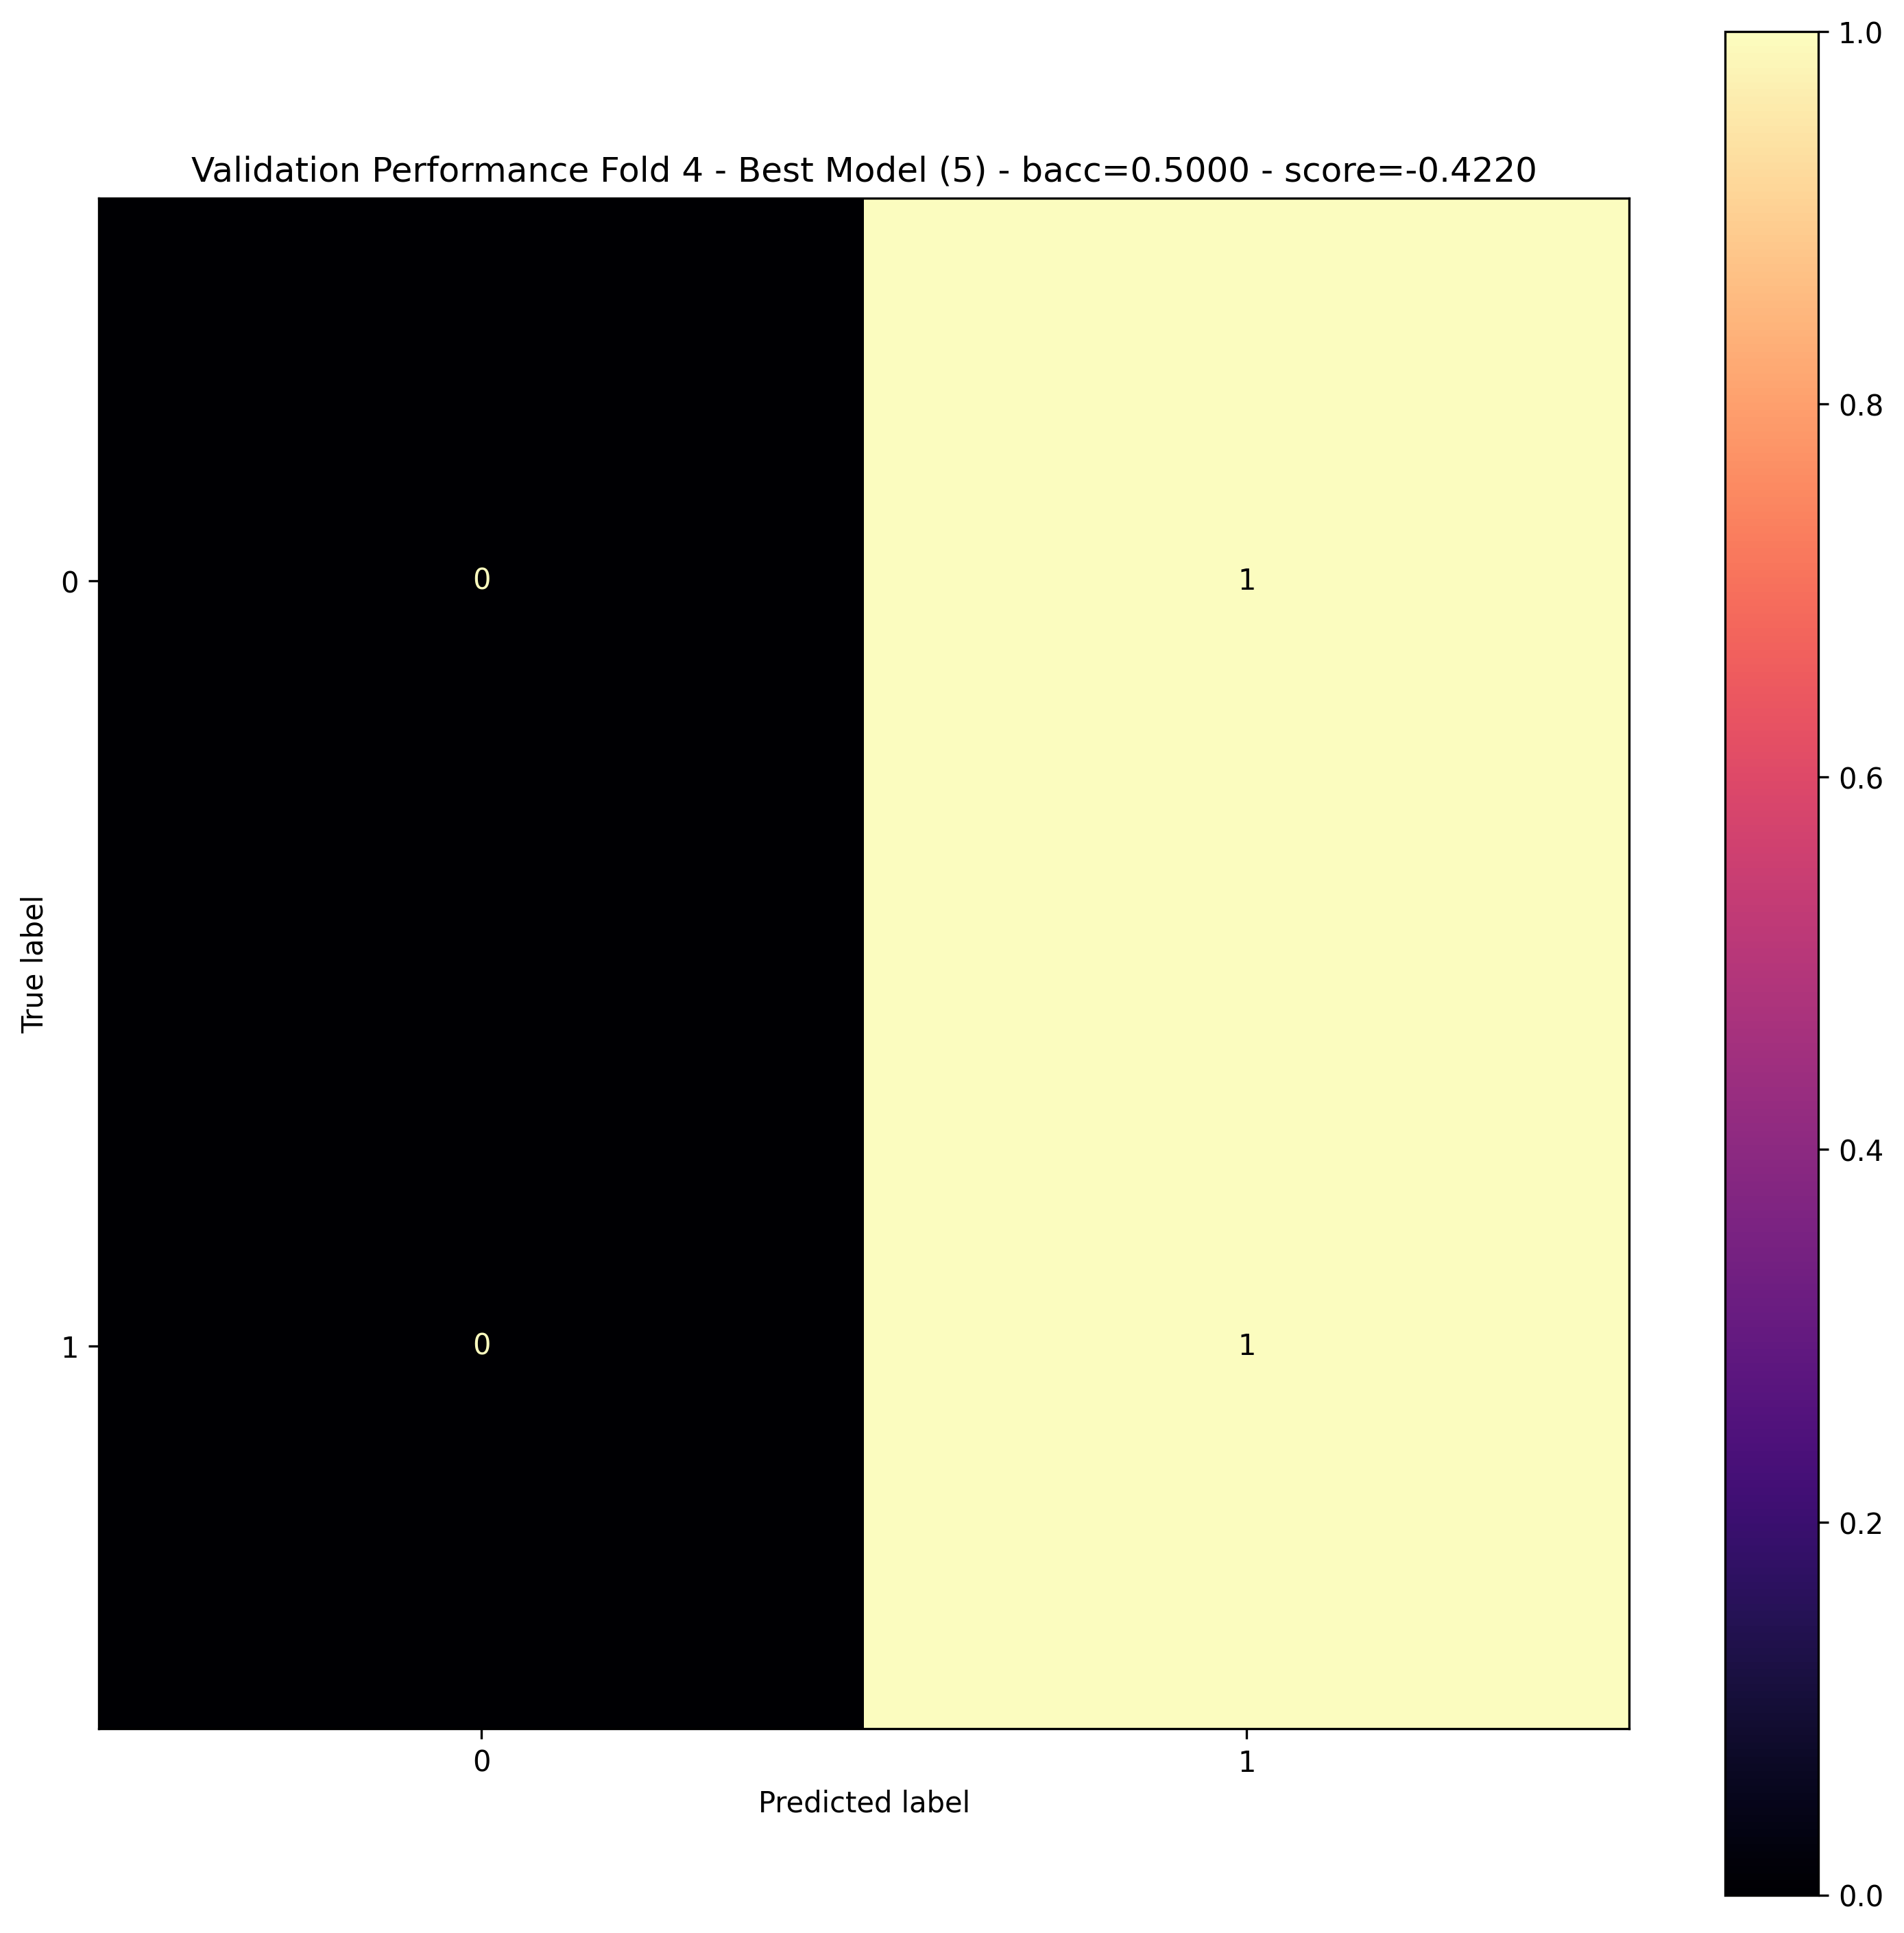


Testing fold 4


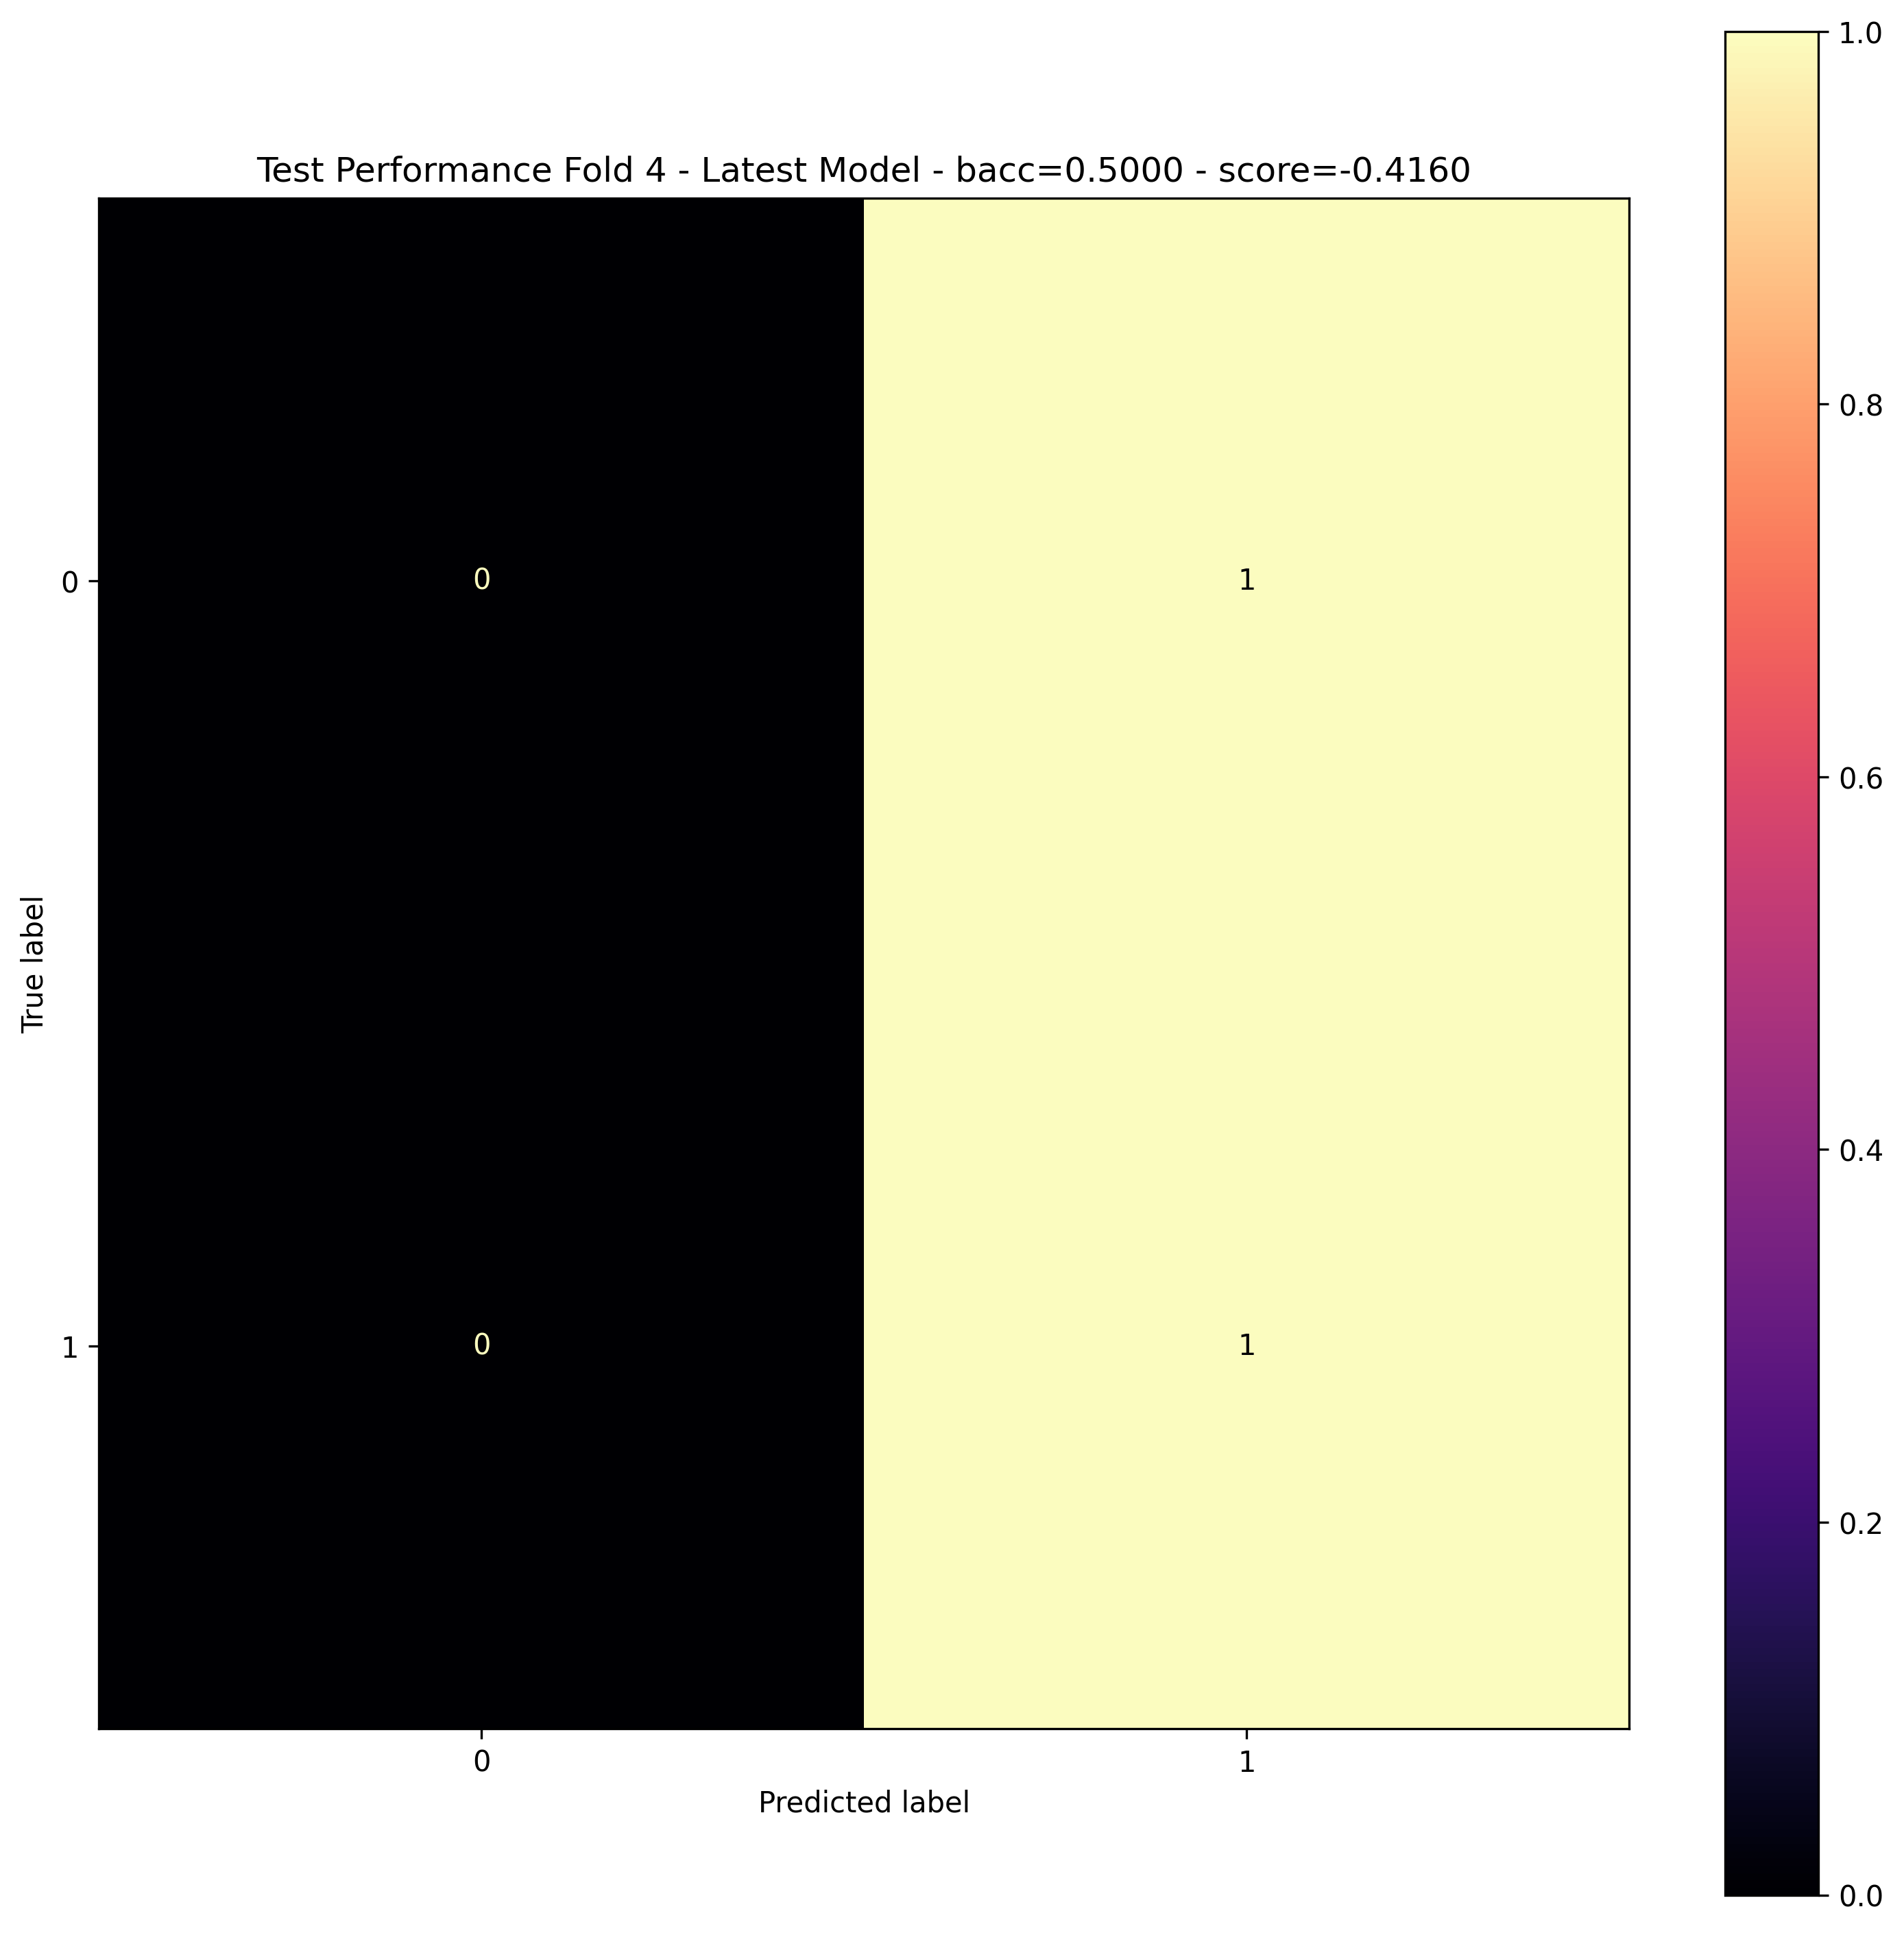

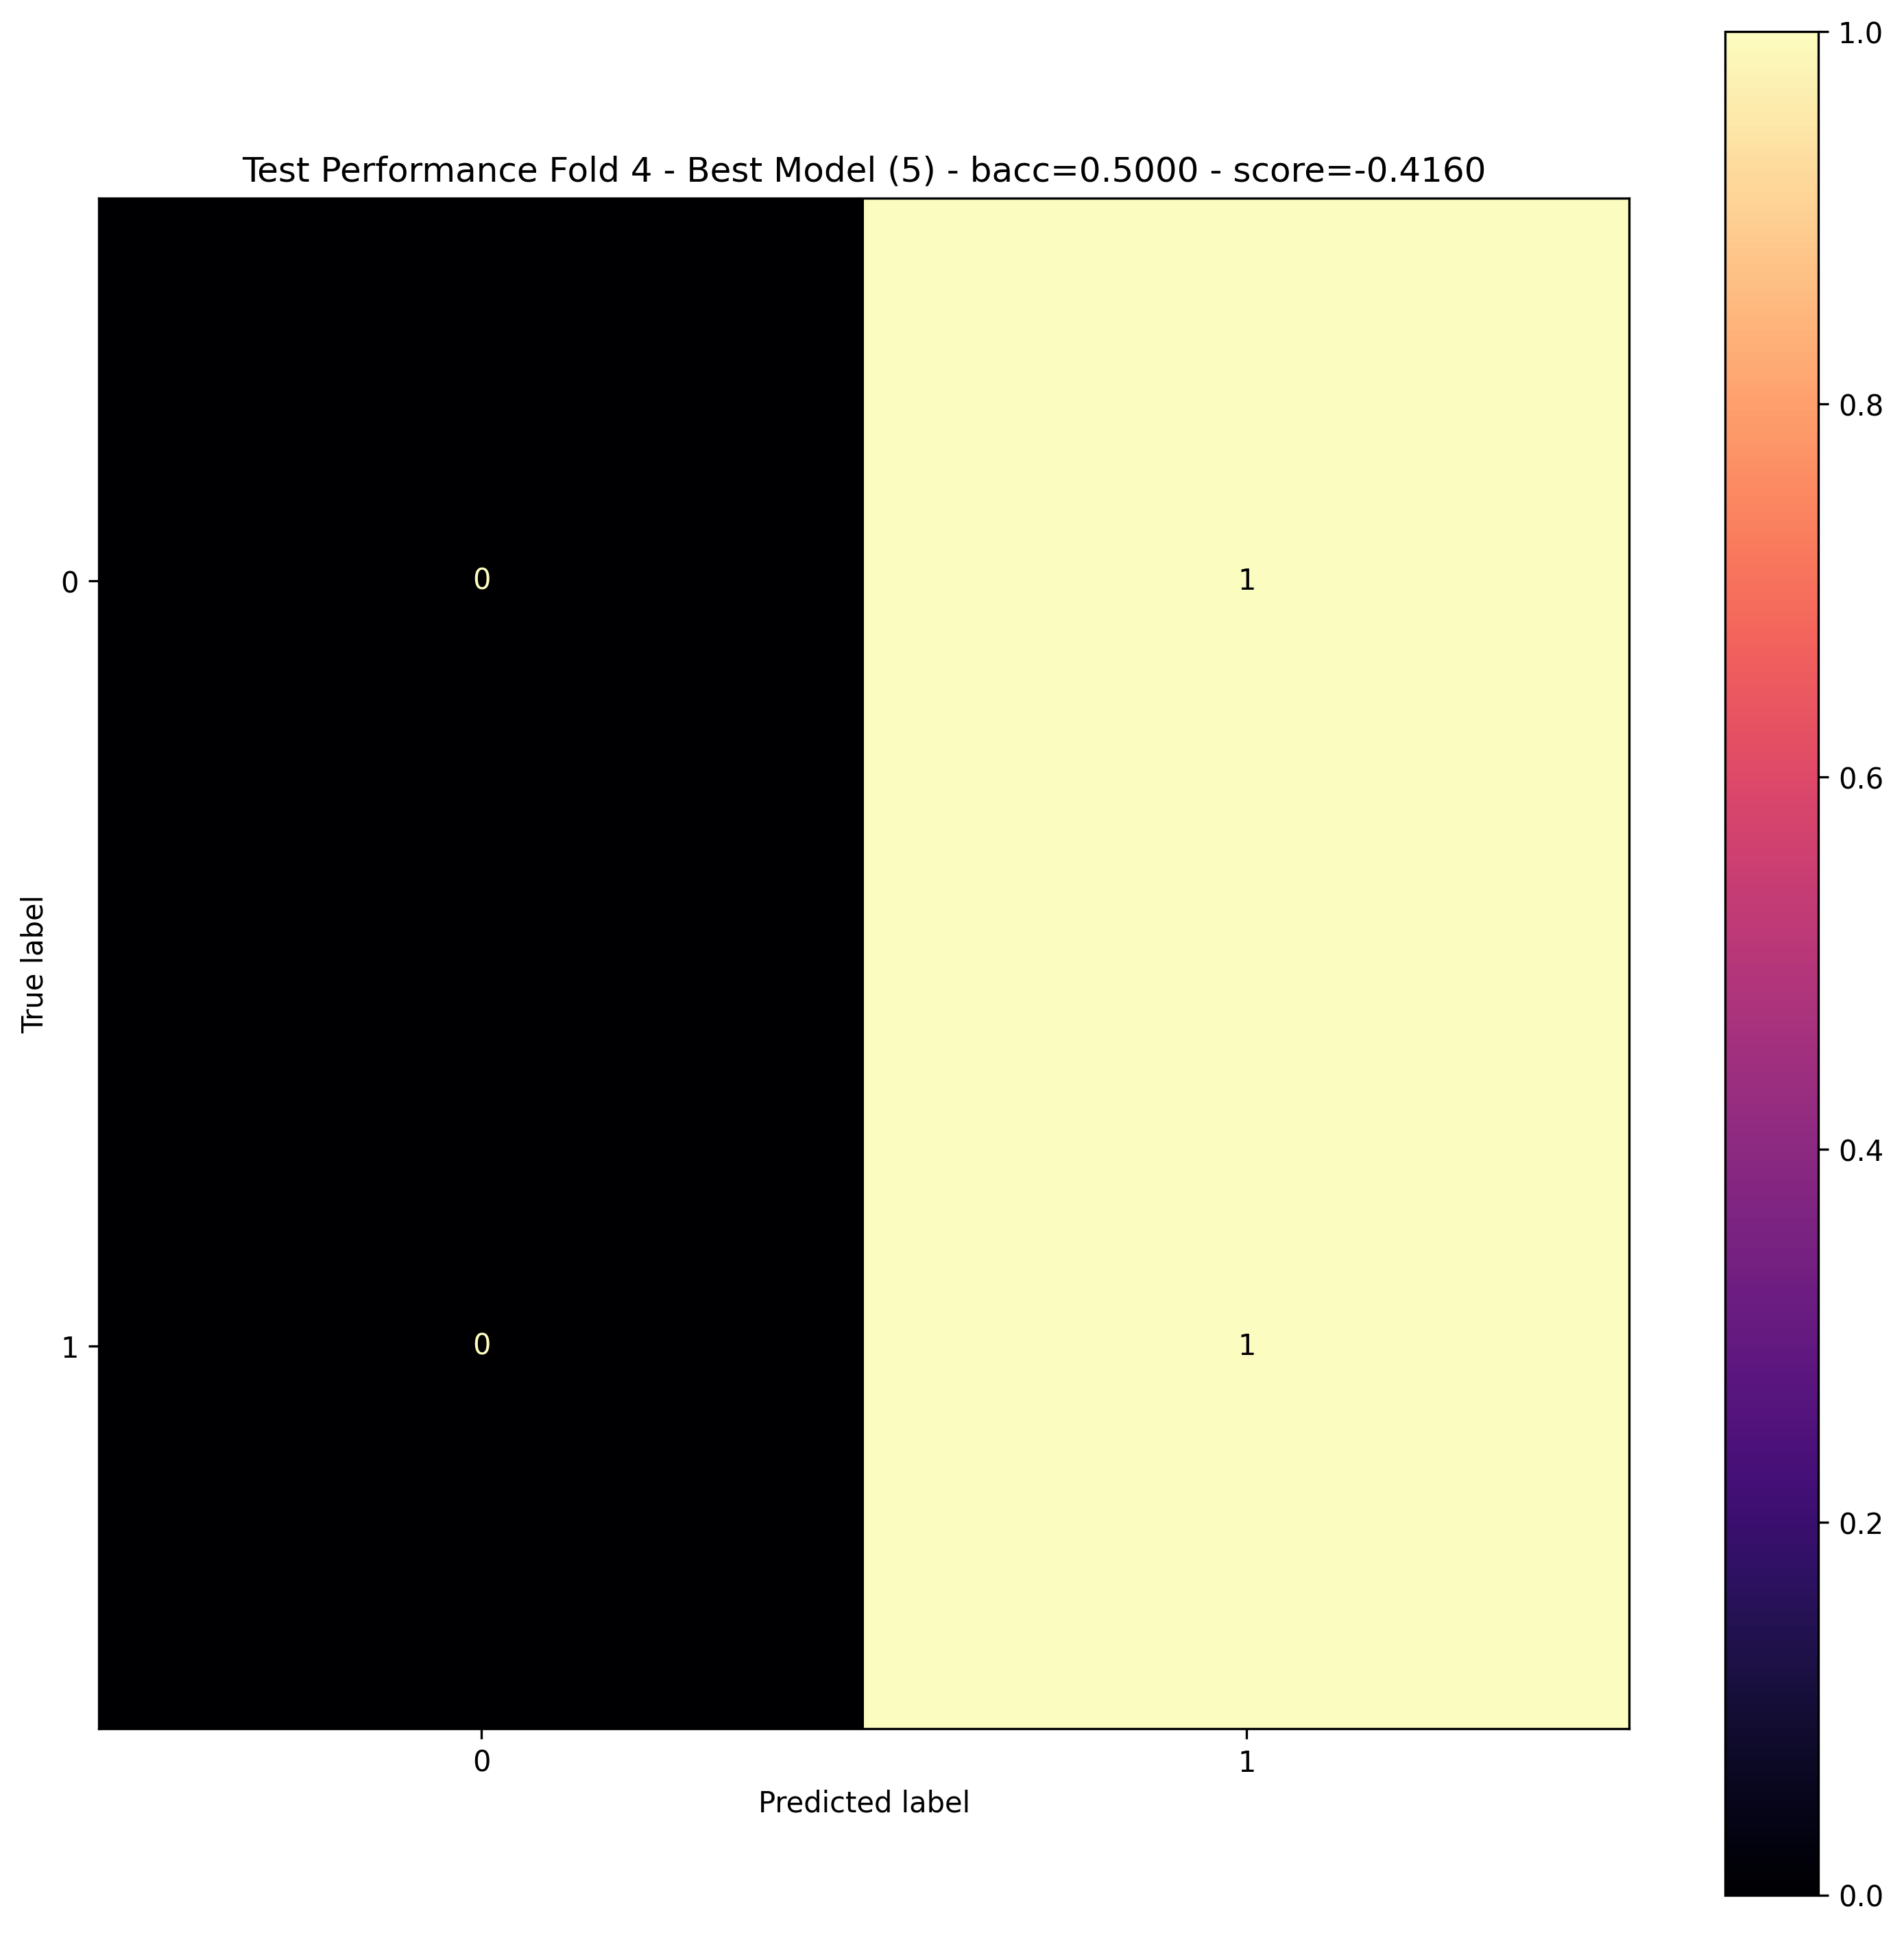

CV Folds:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5/8 [00:33<00:19,  6.54s/it]

Best Model Test Metrics: avg_loss = 0.000113, num_samples = 24000, num_correct =  7008, acc = 0.292000, bacc = 0.500000, score = -0.416000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-4-best eval-score=-0.4220 test-score=-0.4160"



Executing CV for fold 5
Training fold 5


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59822, 24178]
eval label counts  = [ 8544,  3456]

loss weights                    = [ 0.50,  2.47]
eval loss weights (theoretical) = [ 0.50,  2.47]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000074, num_samples = 84000, num_correct = 37339, acc = 0.444512, bacc = 0.498698, score = -0.110976
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000119, num_samples = 12000, num_correct =  3456, acc = 0.288000, bacc = 0.500000, score = -0.424000
Training Epoch   2/5  : lr = 1.00E-03, epoc

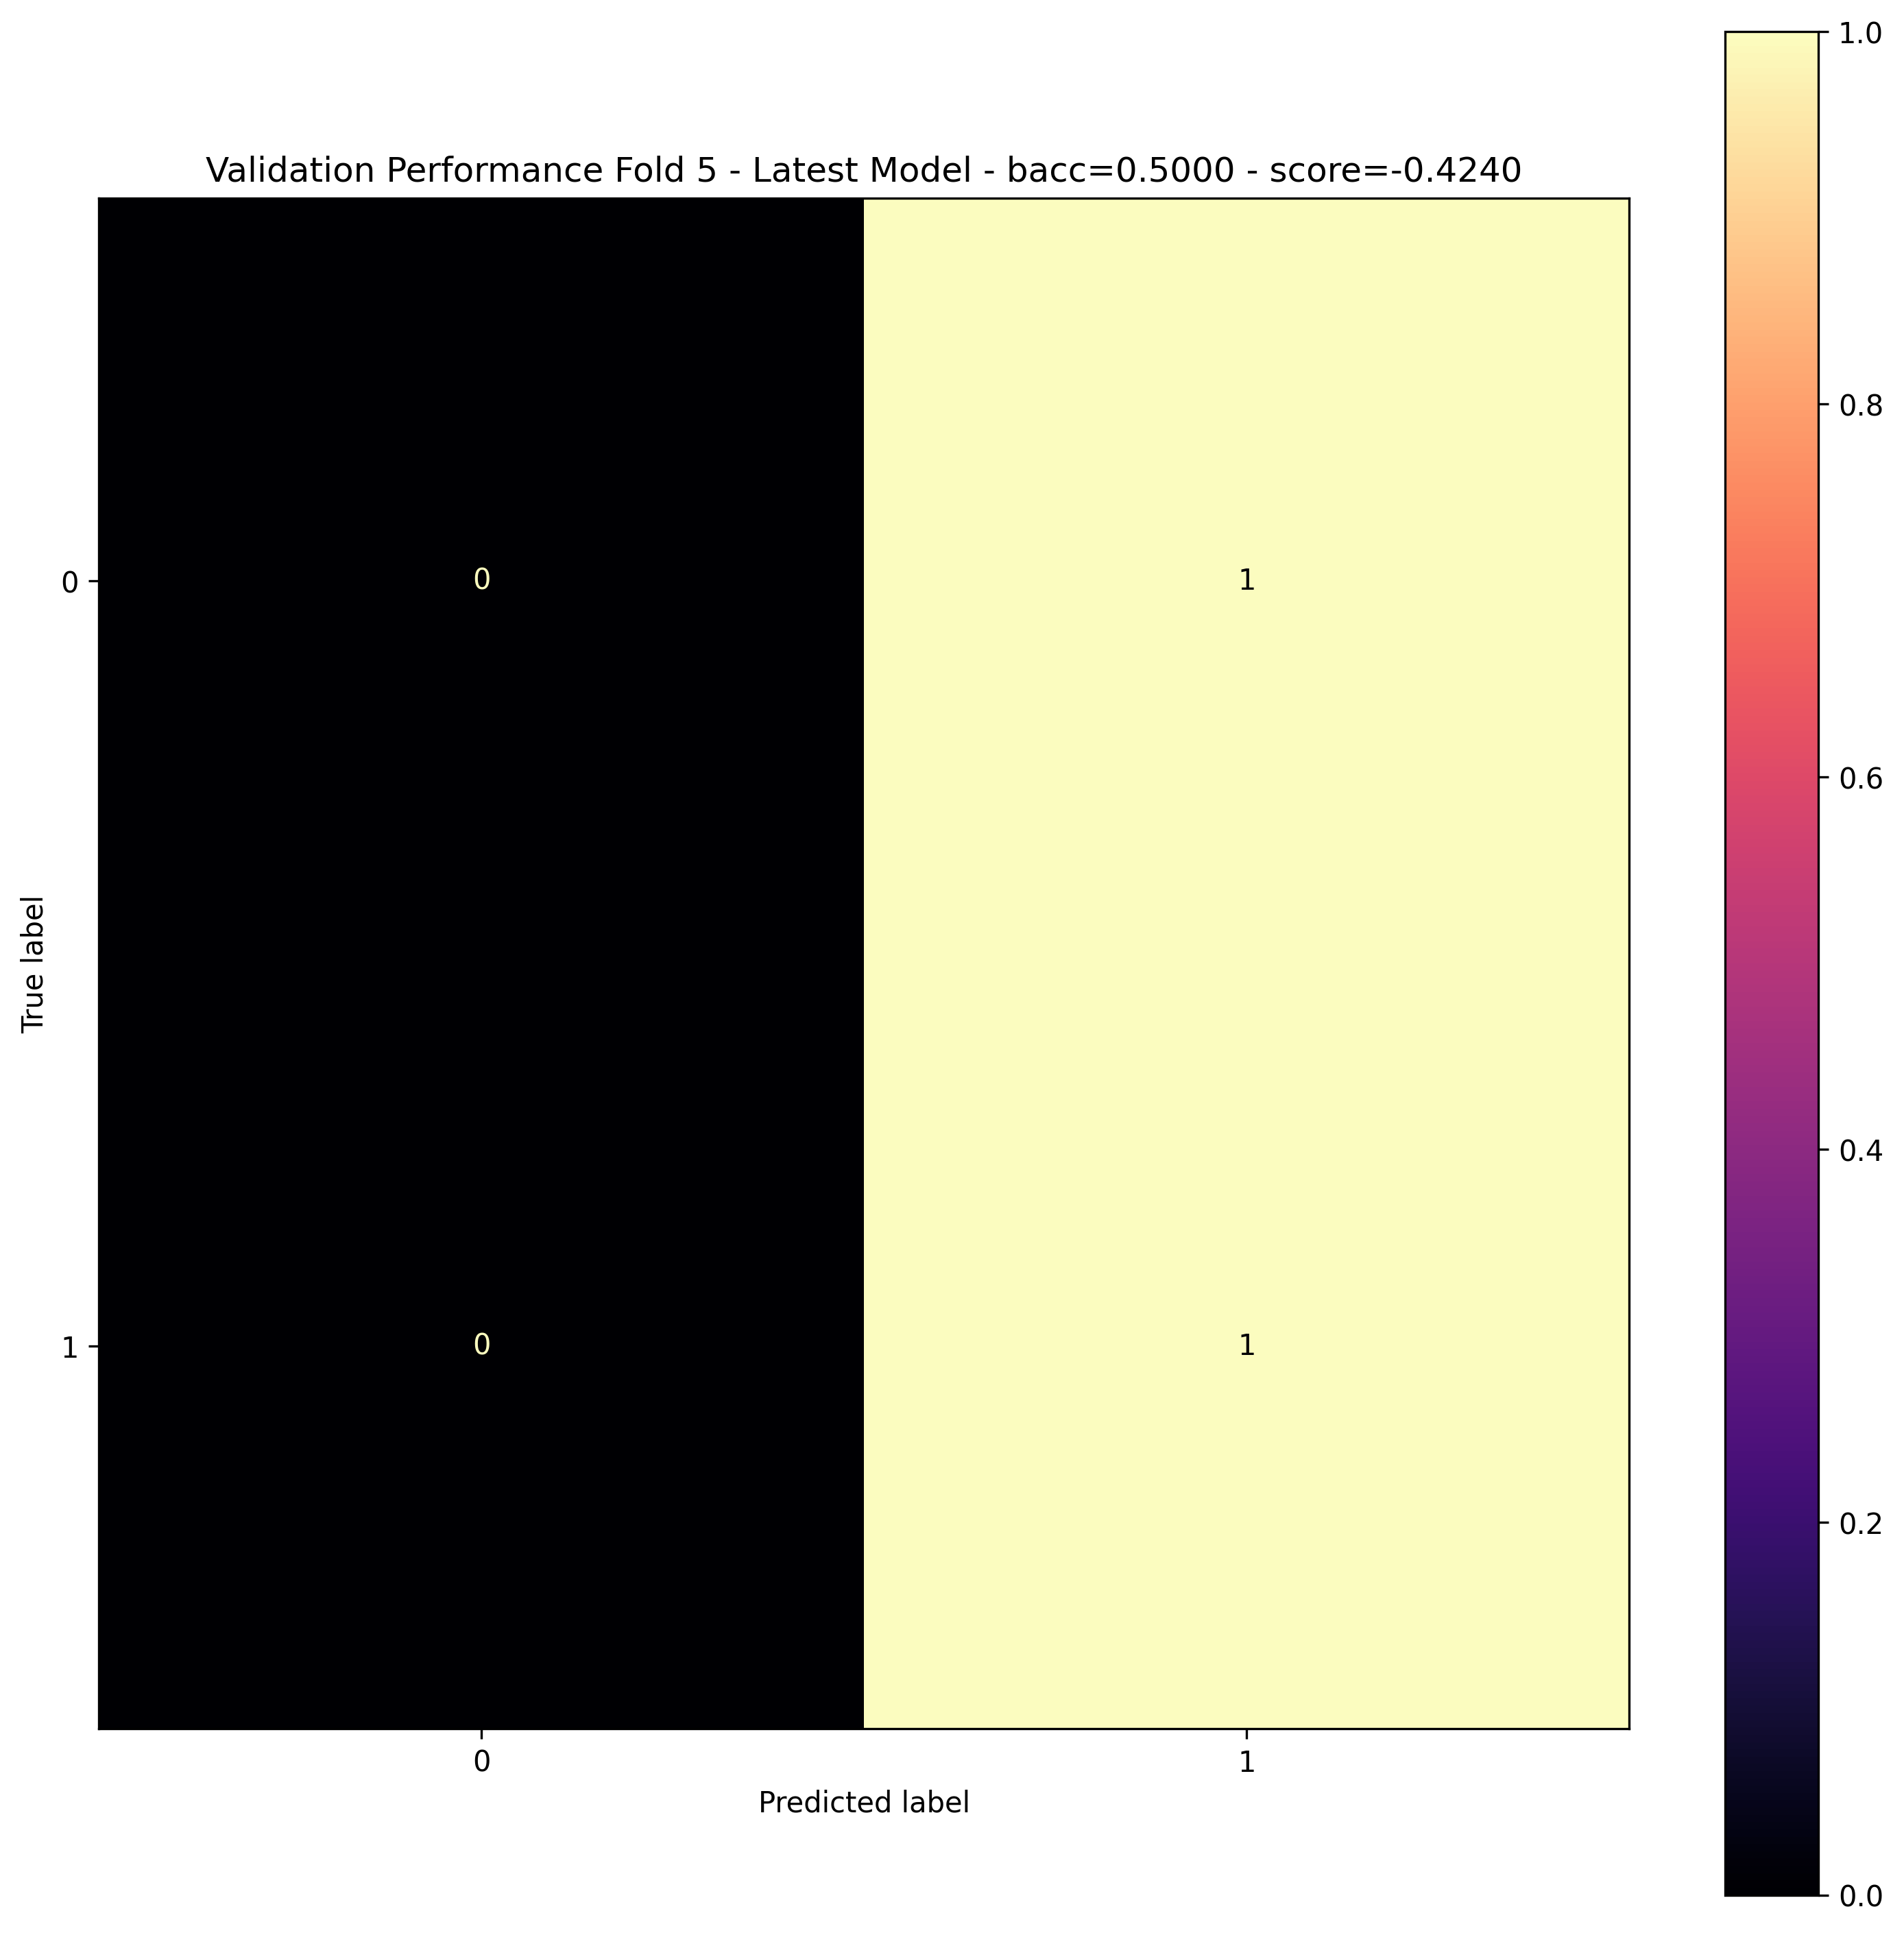

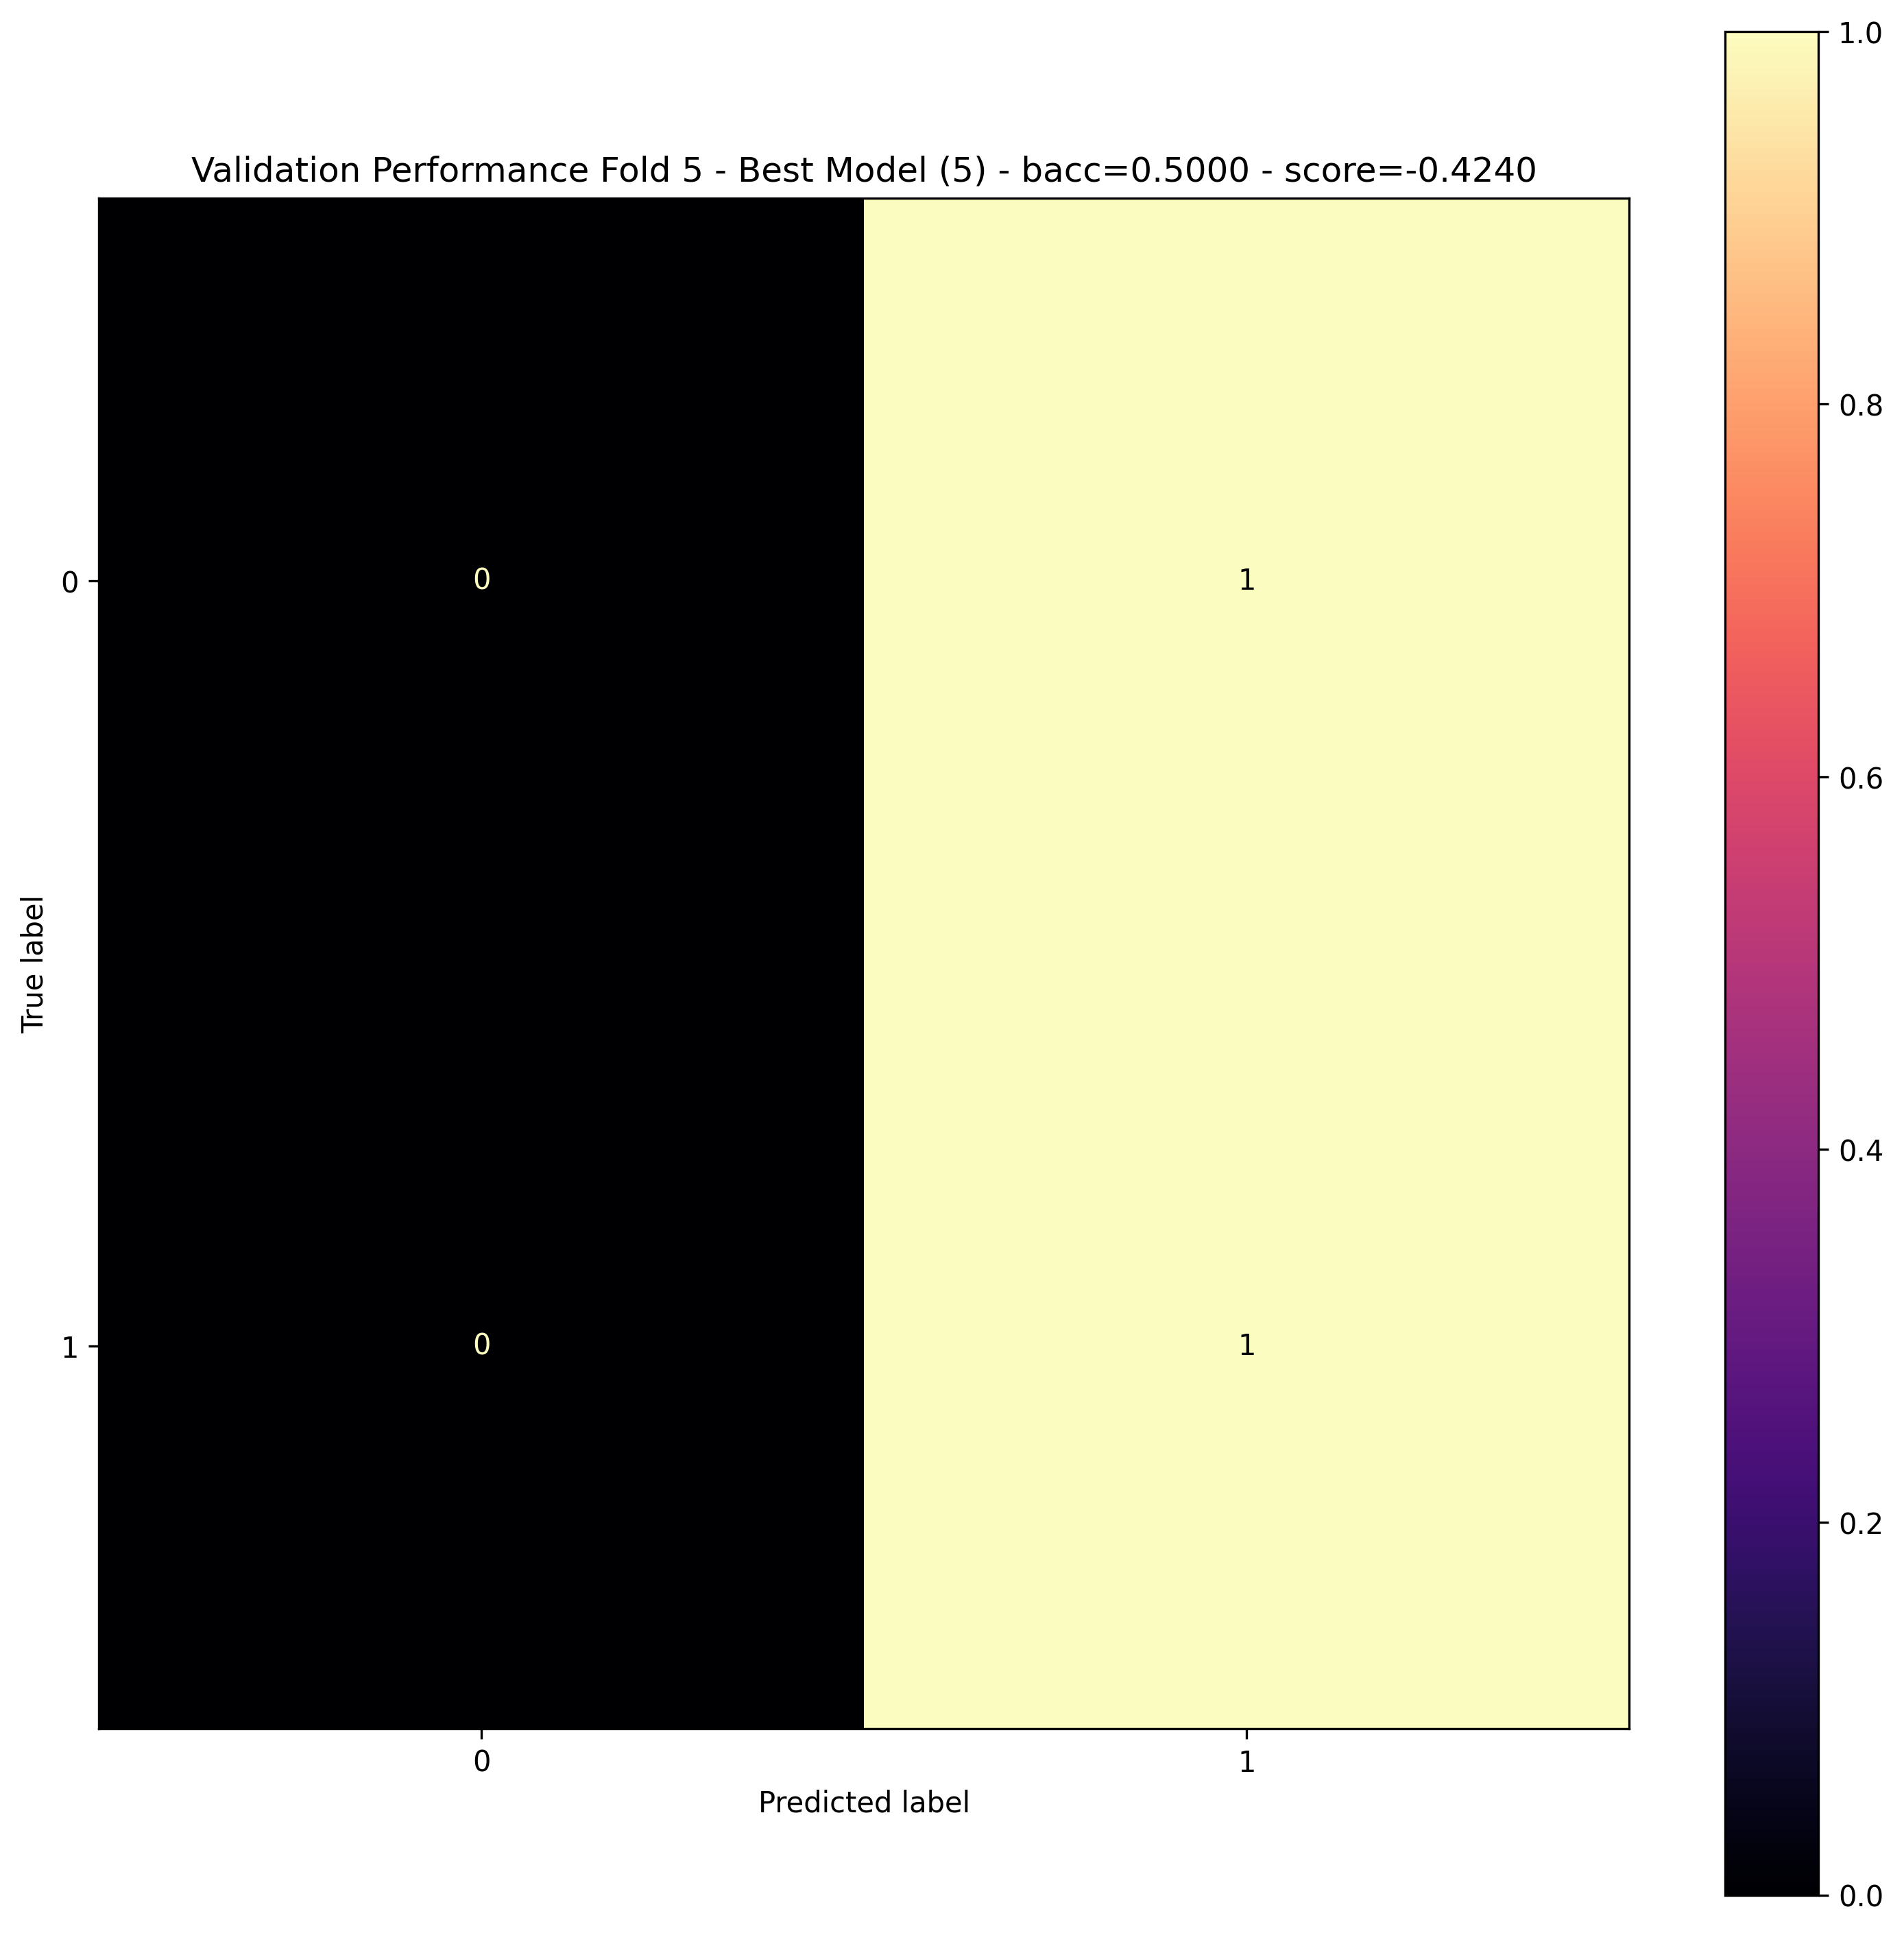


Testing fold 5


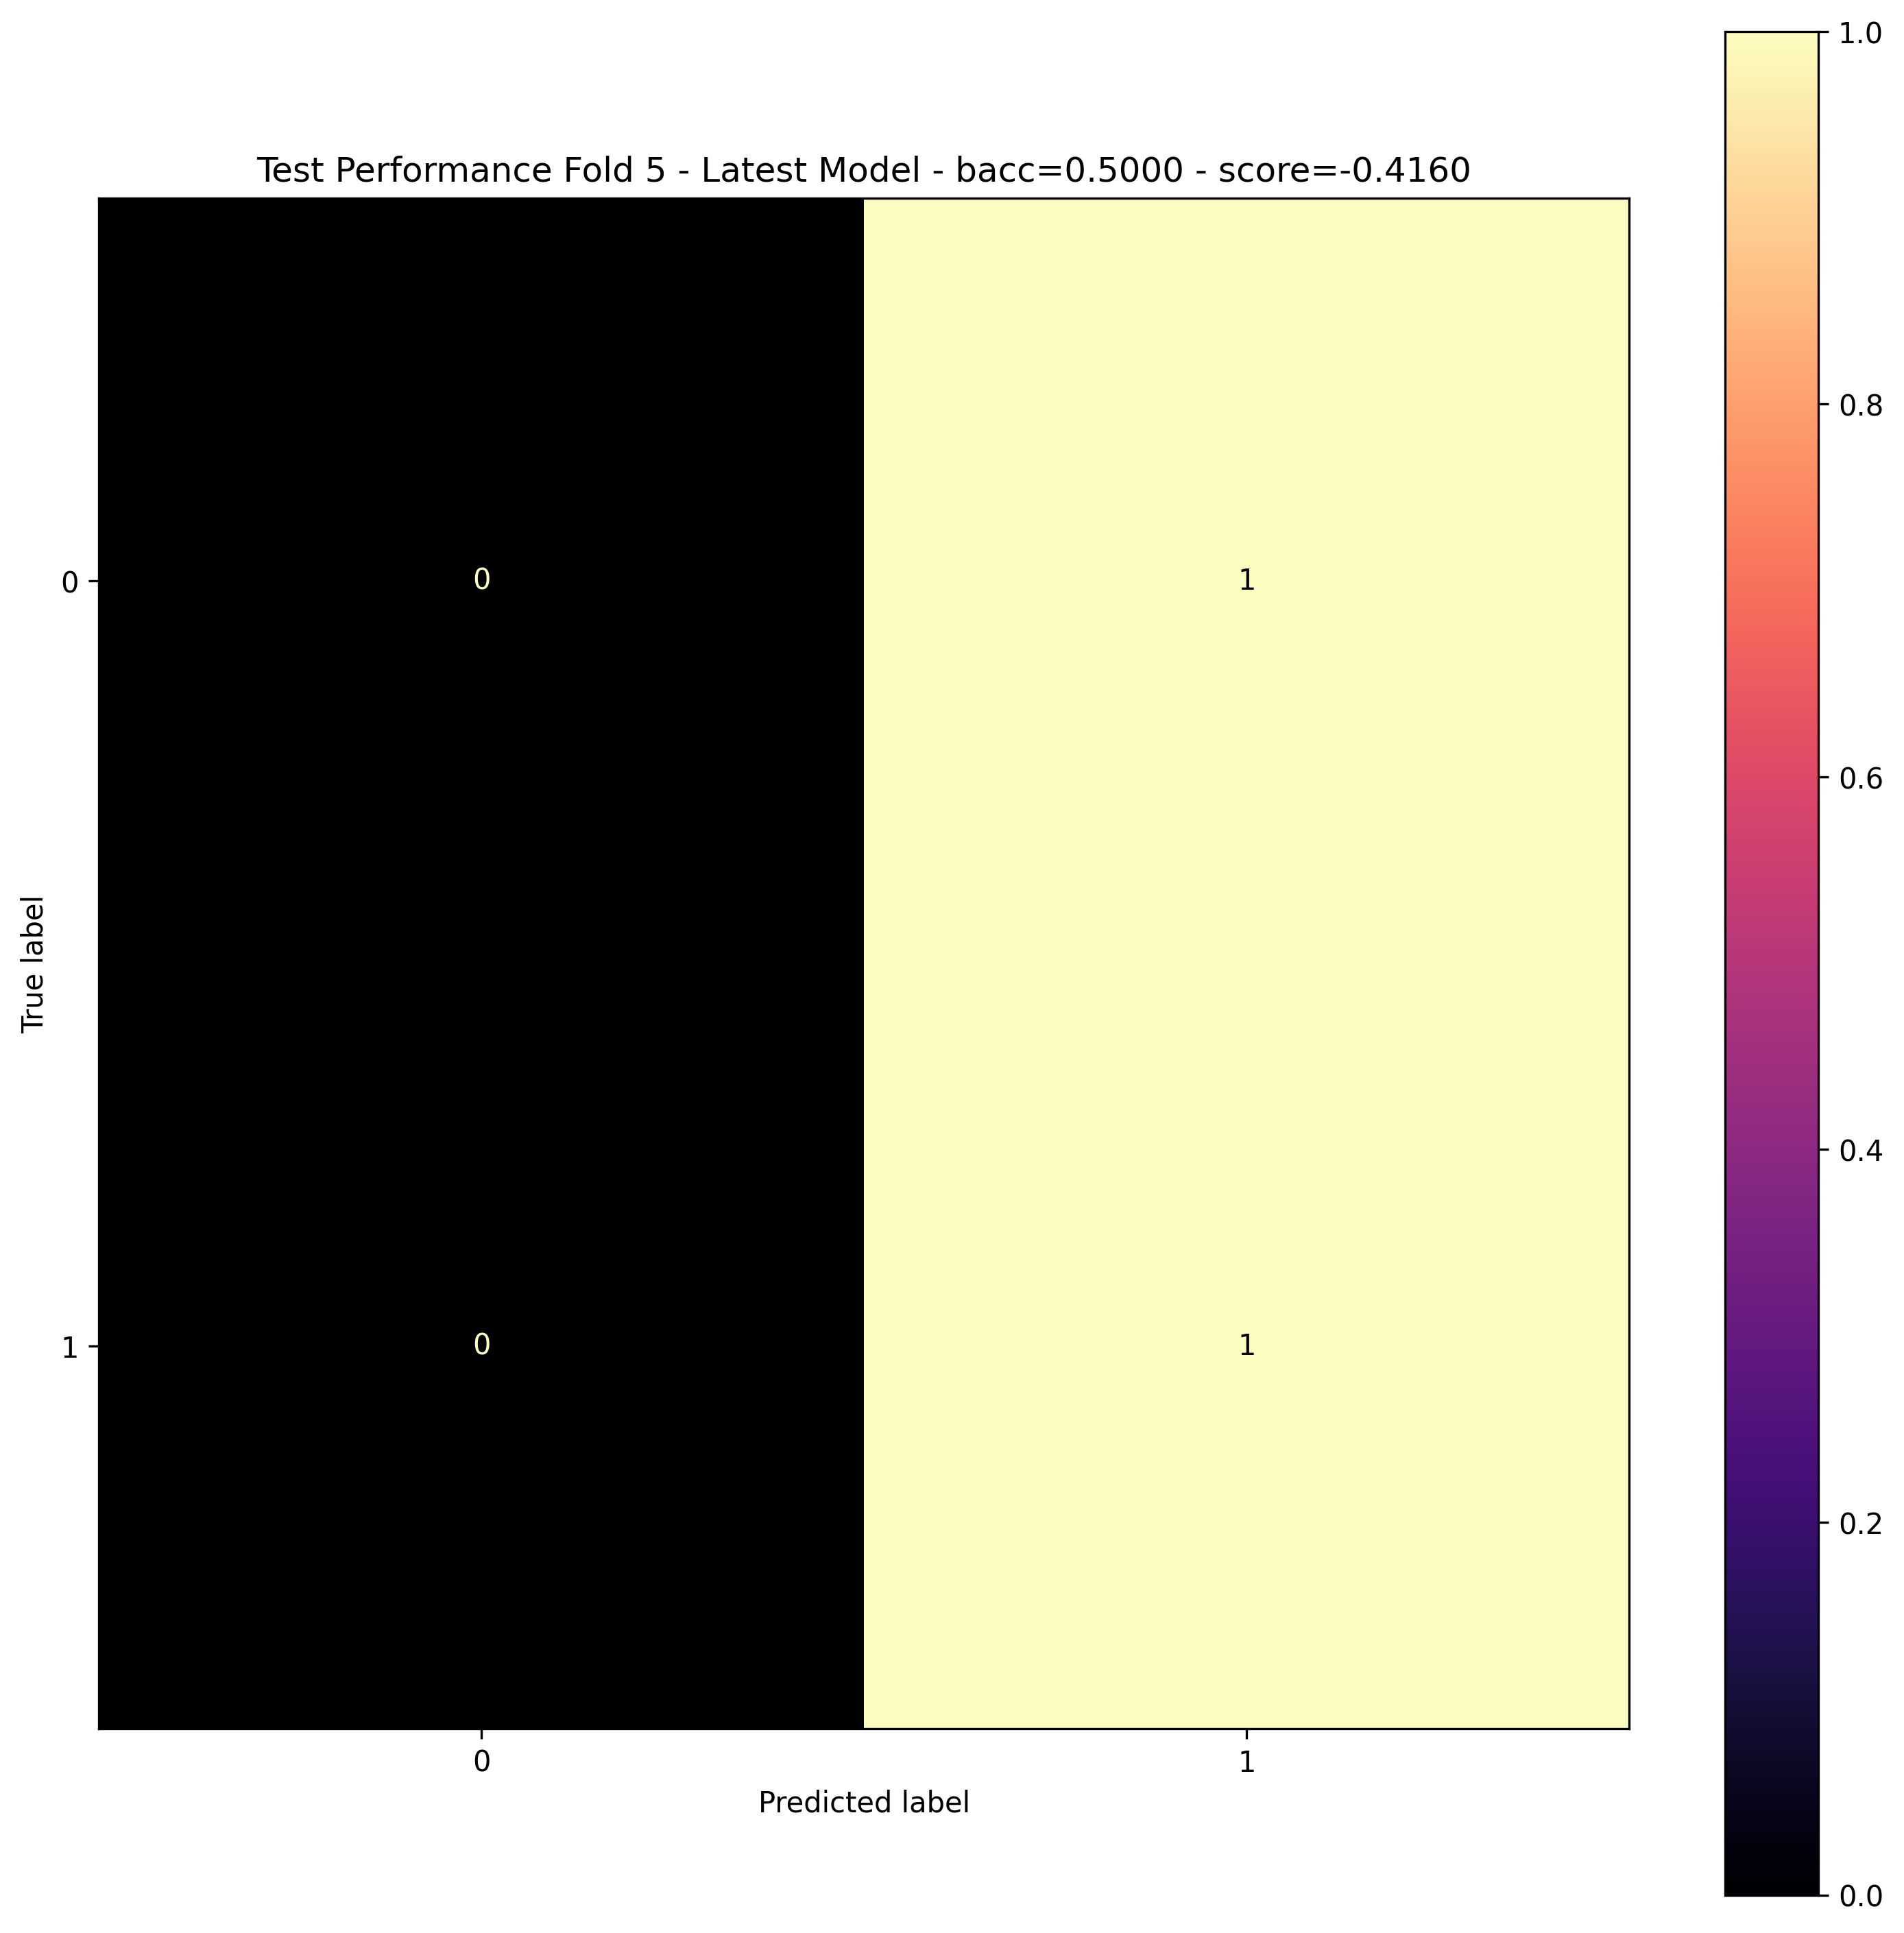

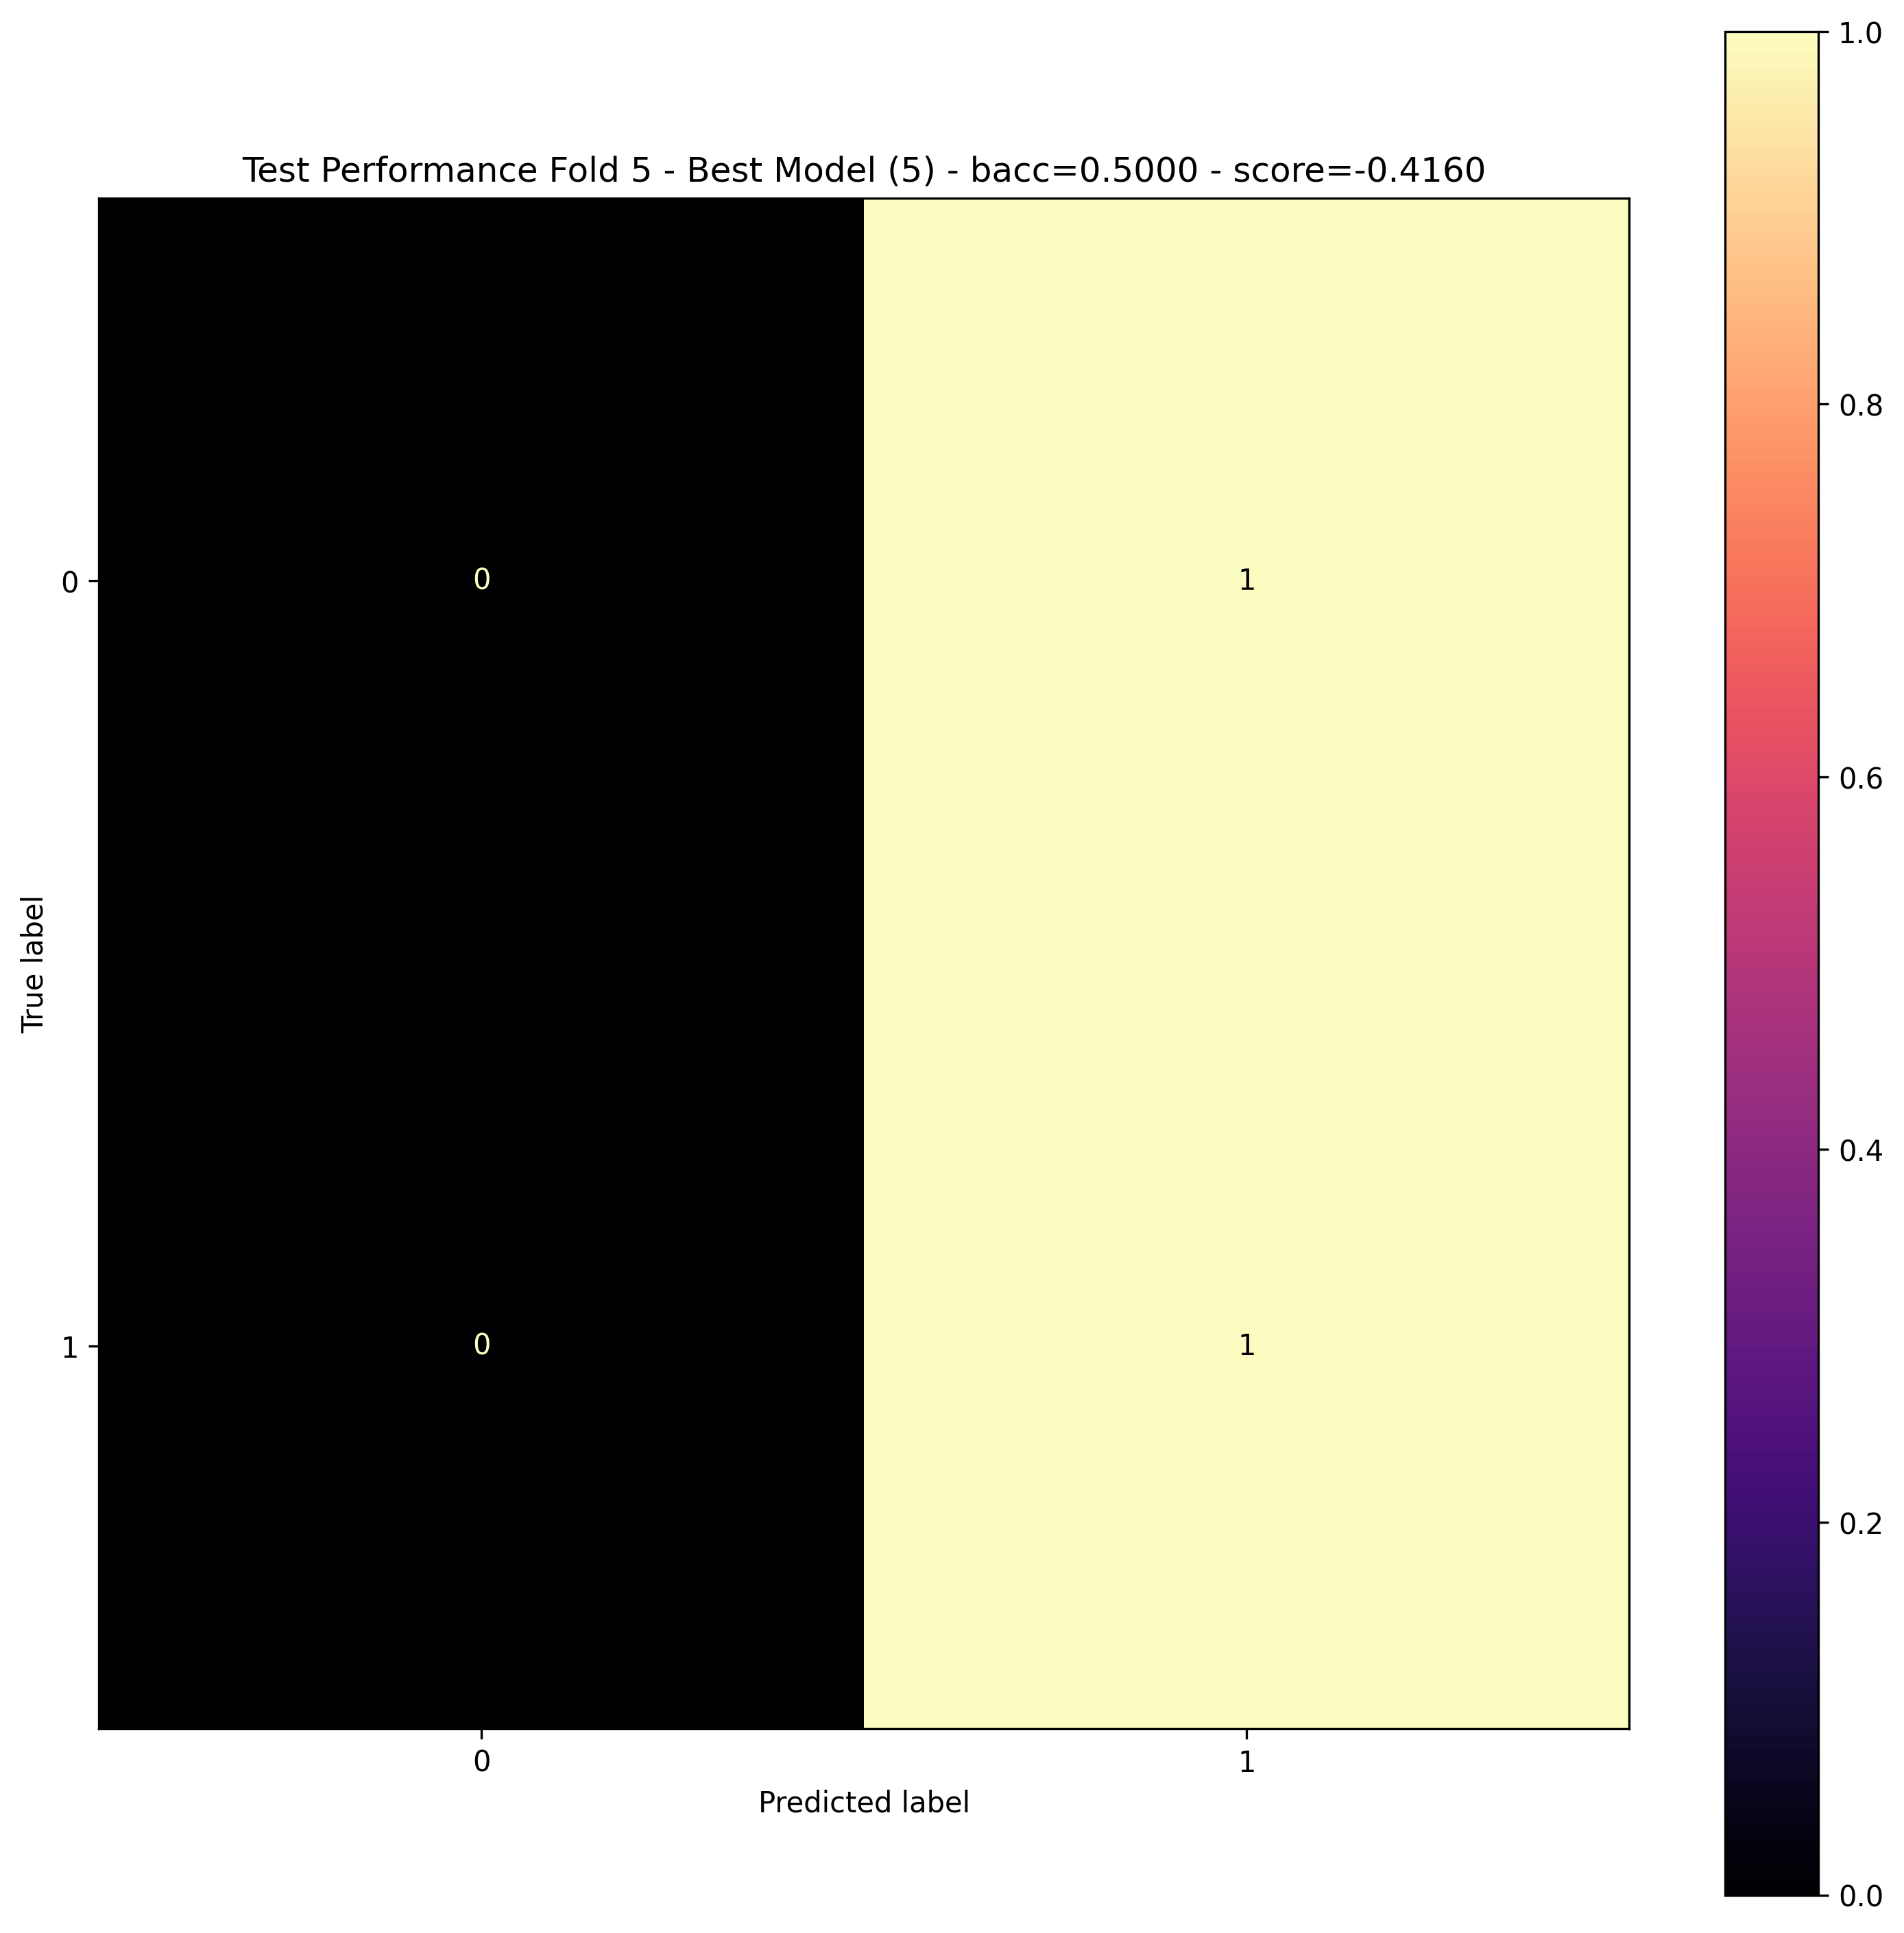

CV Folds:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 6/8 [00:39<00:12,  6.47s/it]

Best Model Test Metrics: avg_loss = 0.000115, num_samples = 24000, num_correct =  7008, acc = 0.292000, bacc = 0.500000, score = -0.416000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-5-best eval-score=-0.4240 test-score=-0.4160"



Executing CV for fold 6
Training fold 6


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59649, 24351]
eval label counts  = [ 8717,  3283]

loss weights                    = [ 0.50,  2.45]
eval loss weights (theoretical) = [ 0.50,  2.66]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000076, num_samples = 84000, num_correct = 52842, acc = 0.629071, bacc = 0.498312, score = 0.258143
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000117, num_samples = 12000, num_correct =  3451, acc = 0.287583, bacc = 0.498623, score = -0.424833
Training Epoch   2/5  : lr = 1.00E-03, epoch

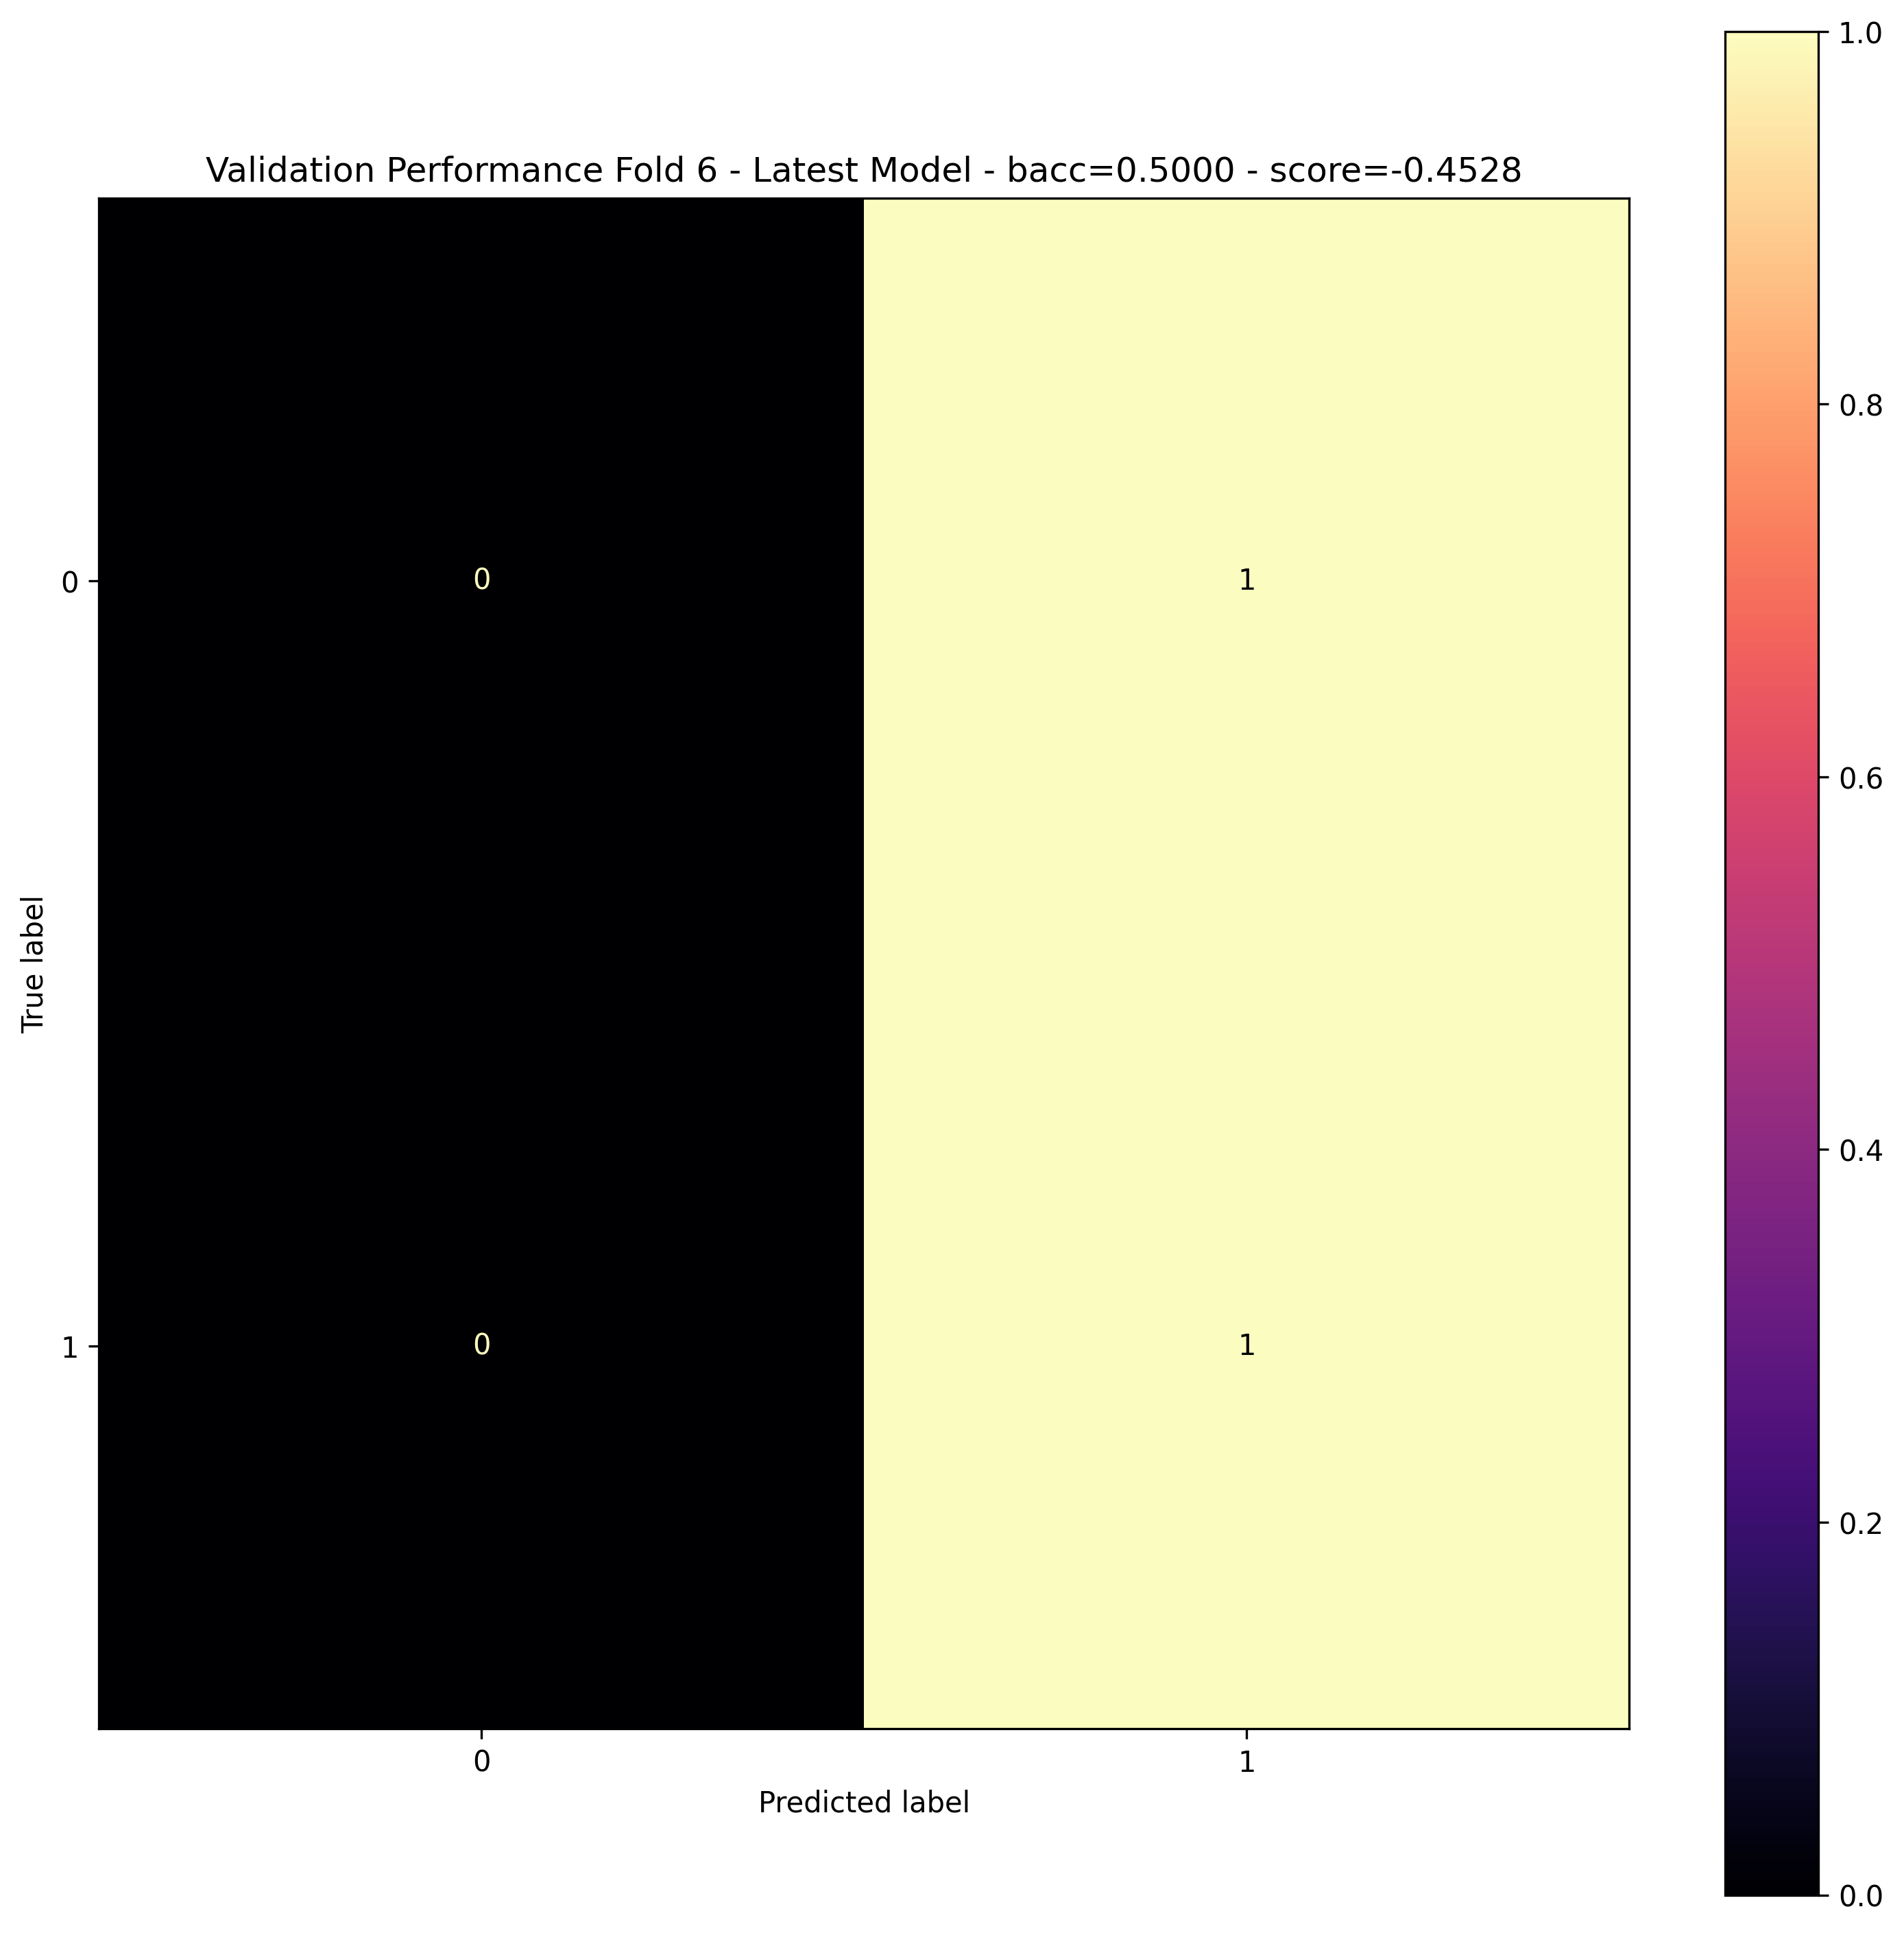

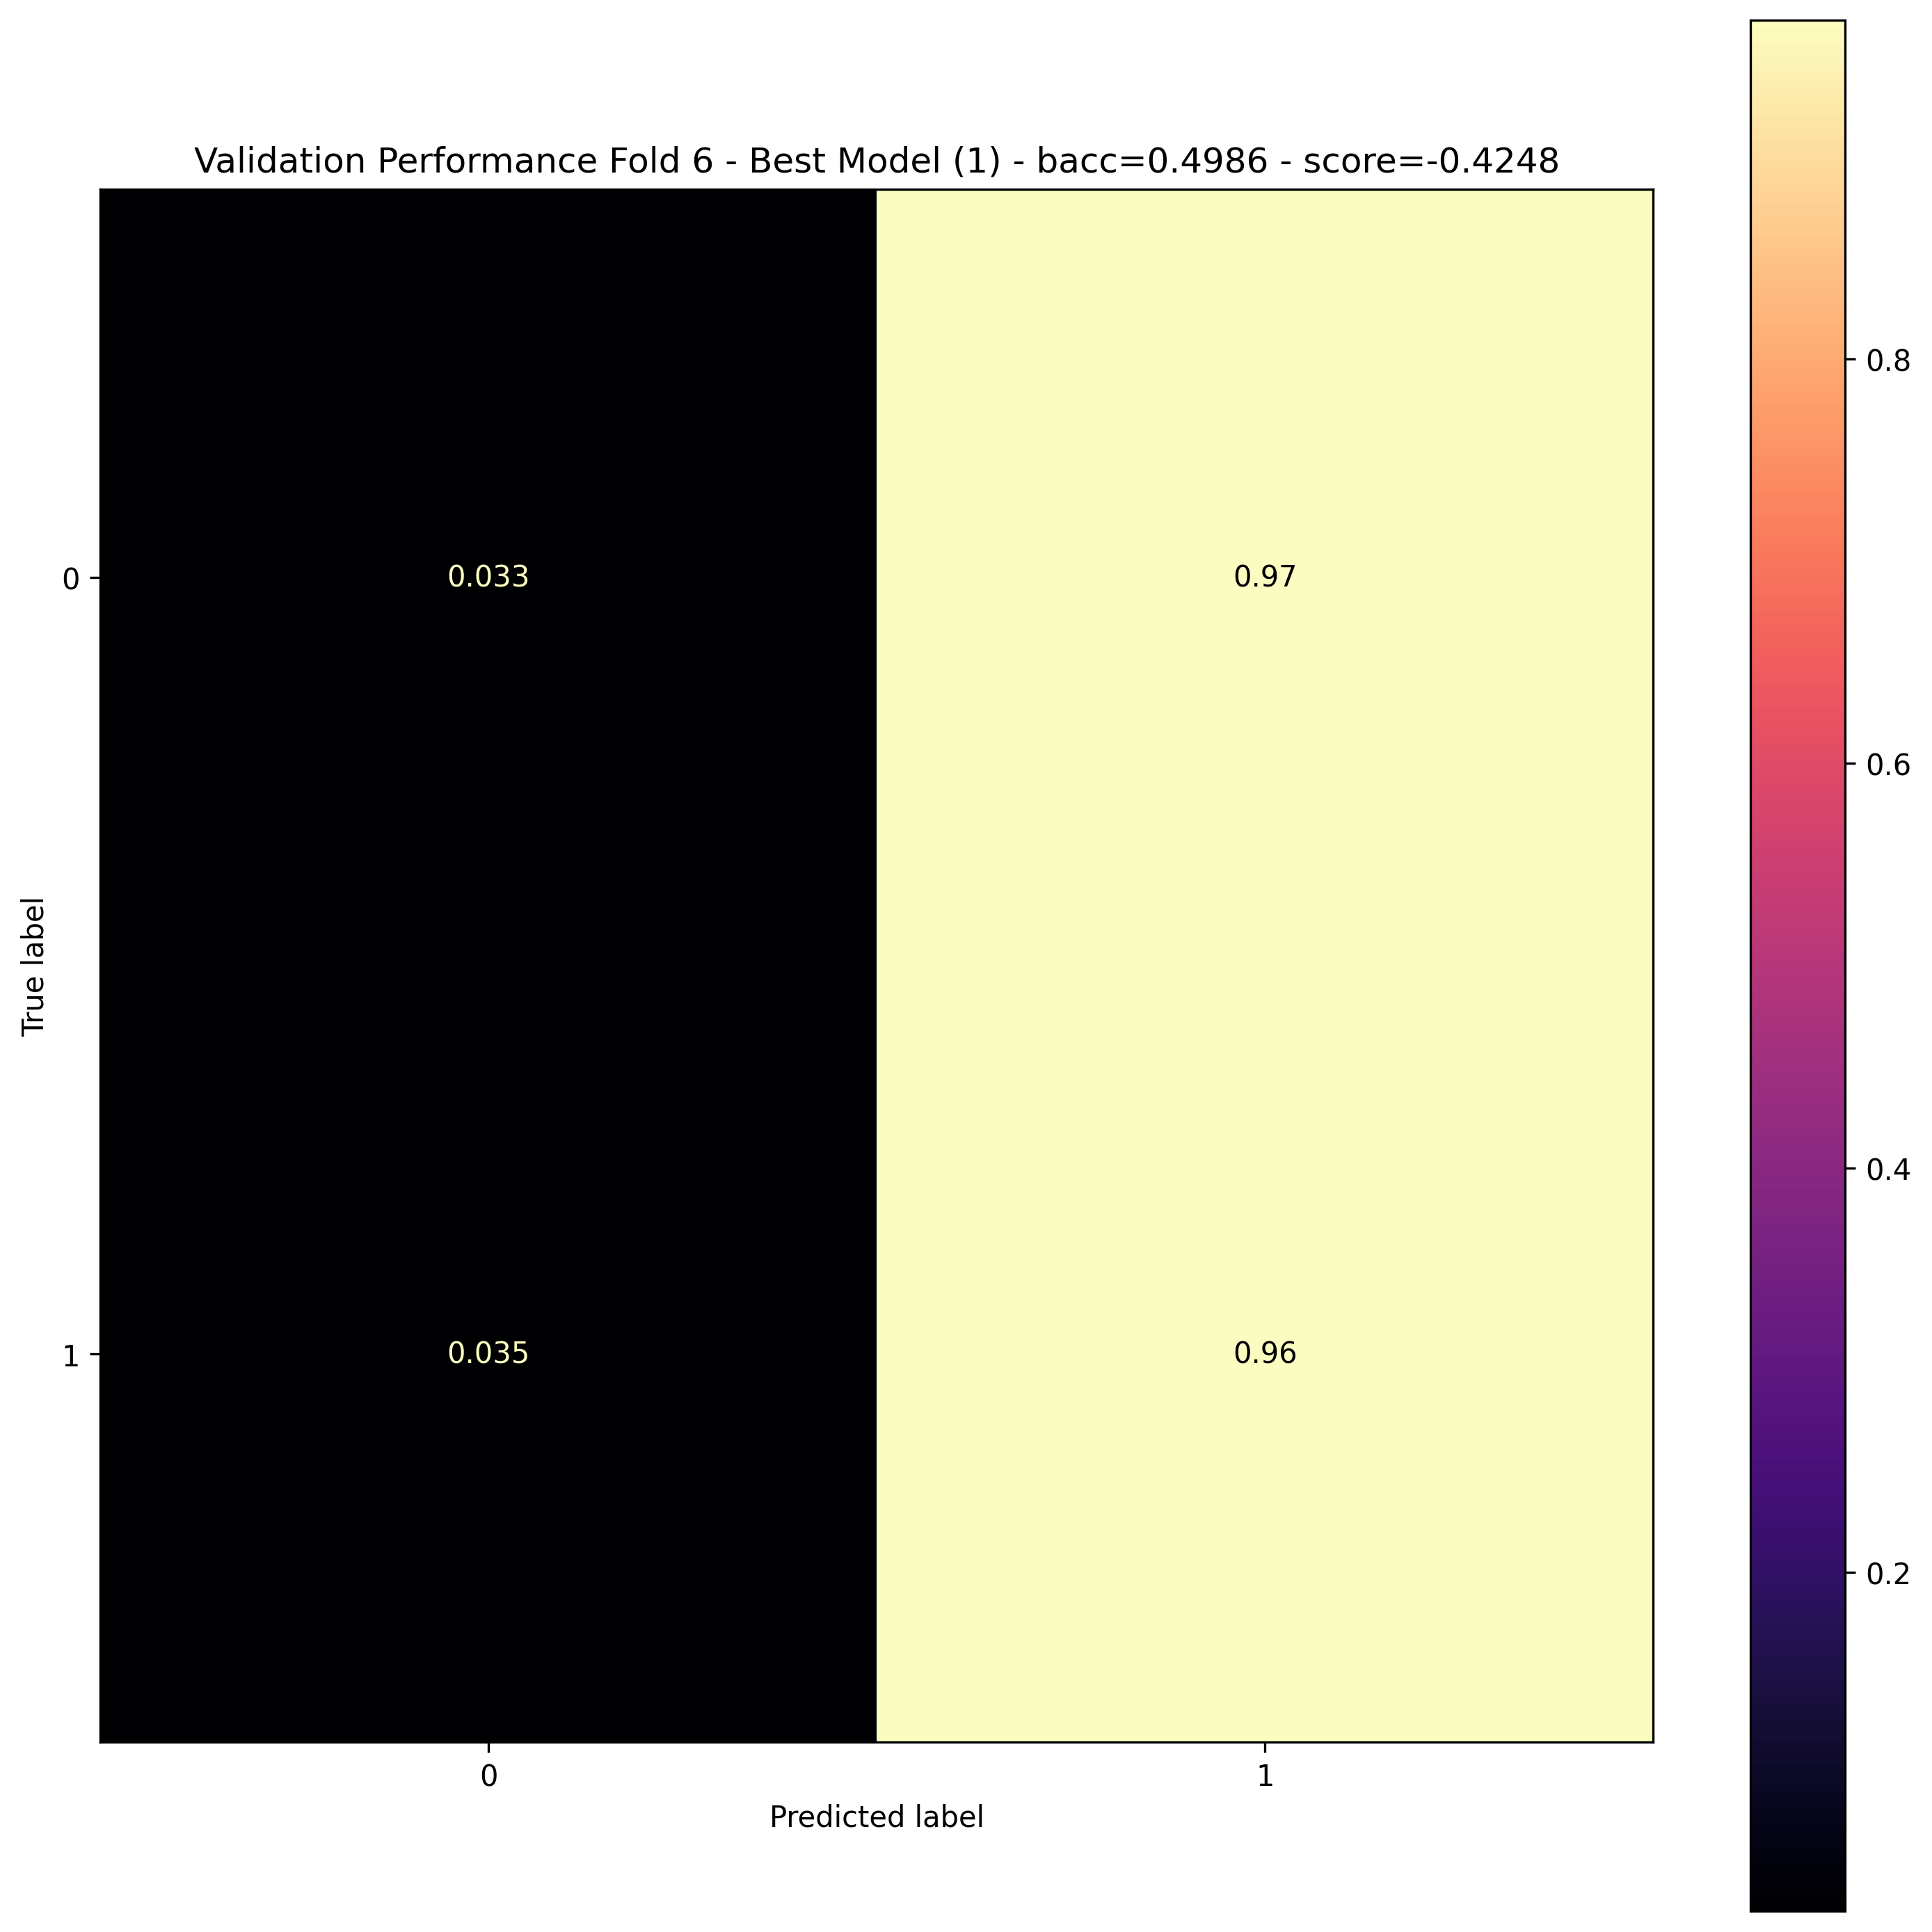


Testing fold 6


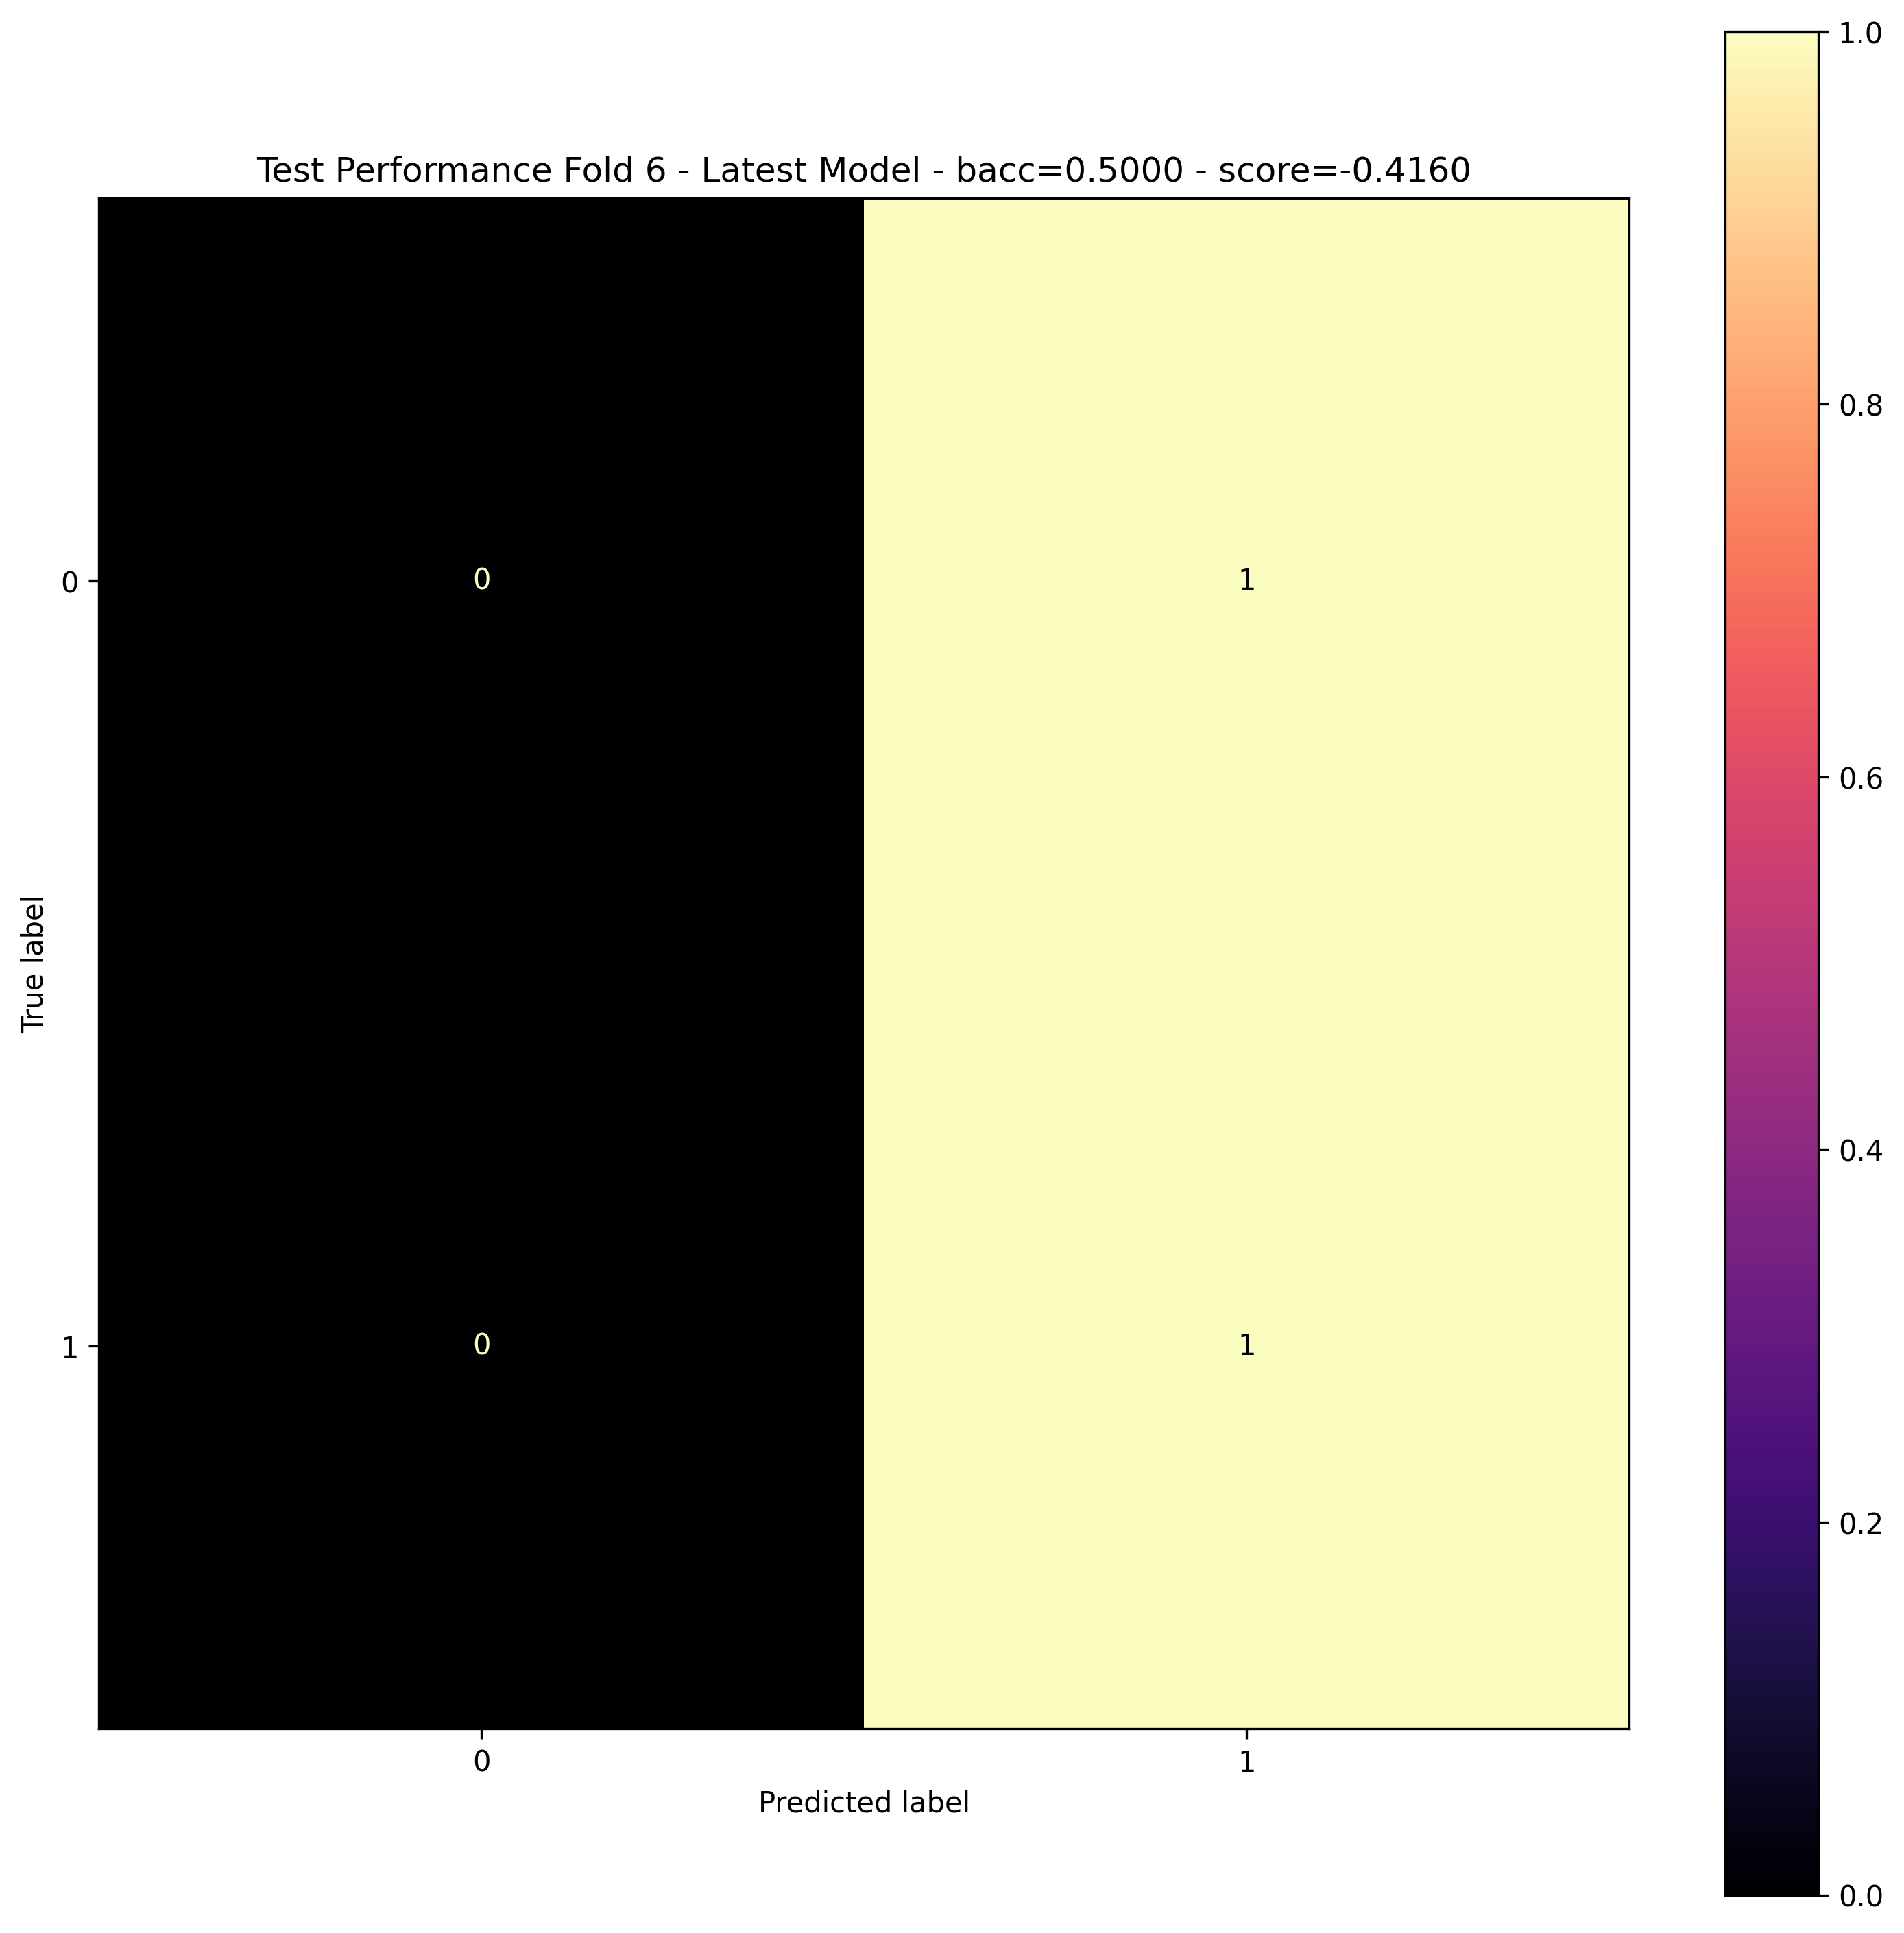

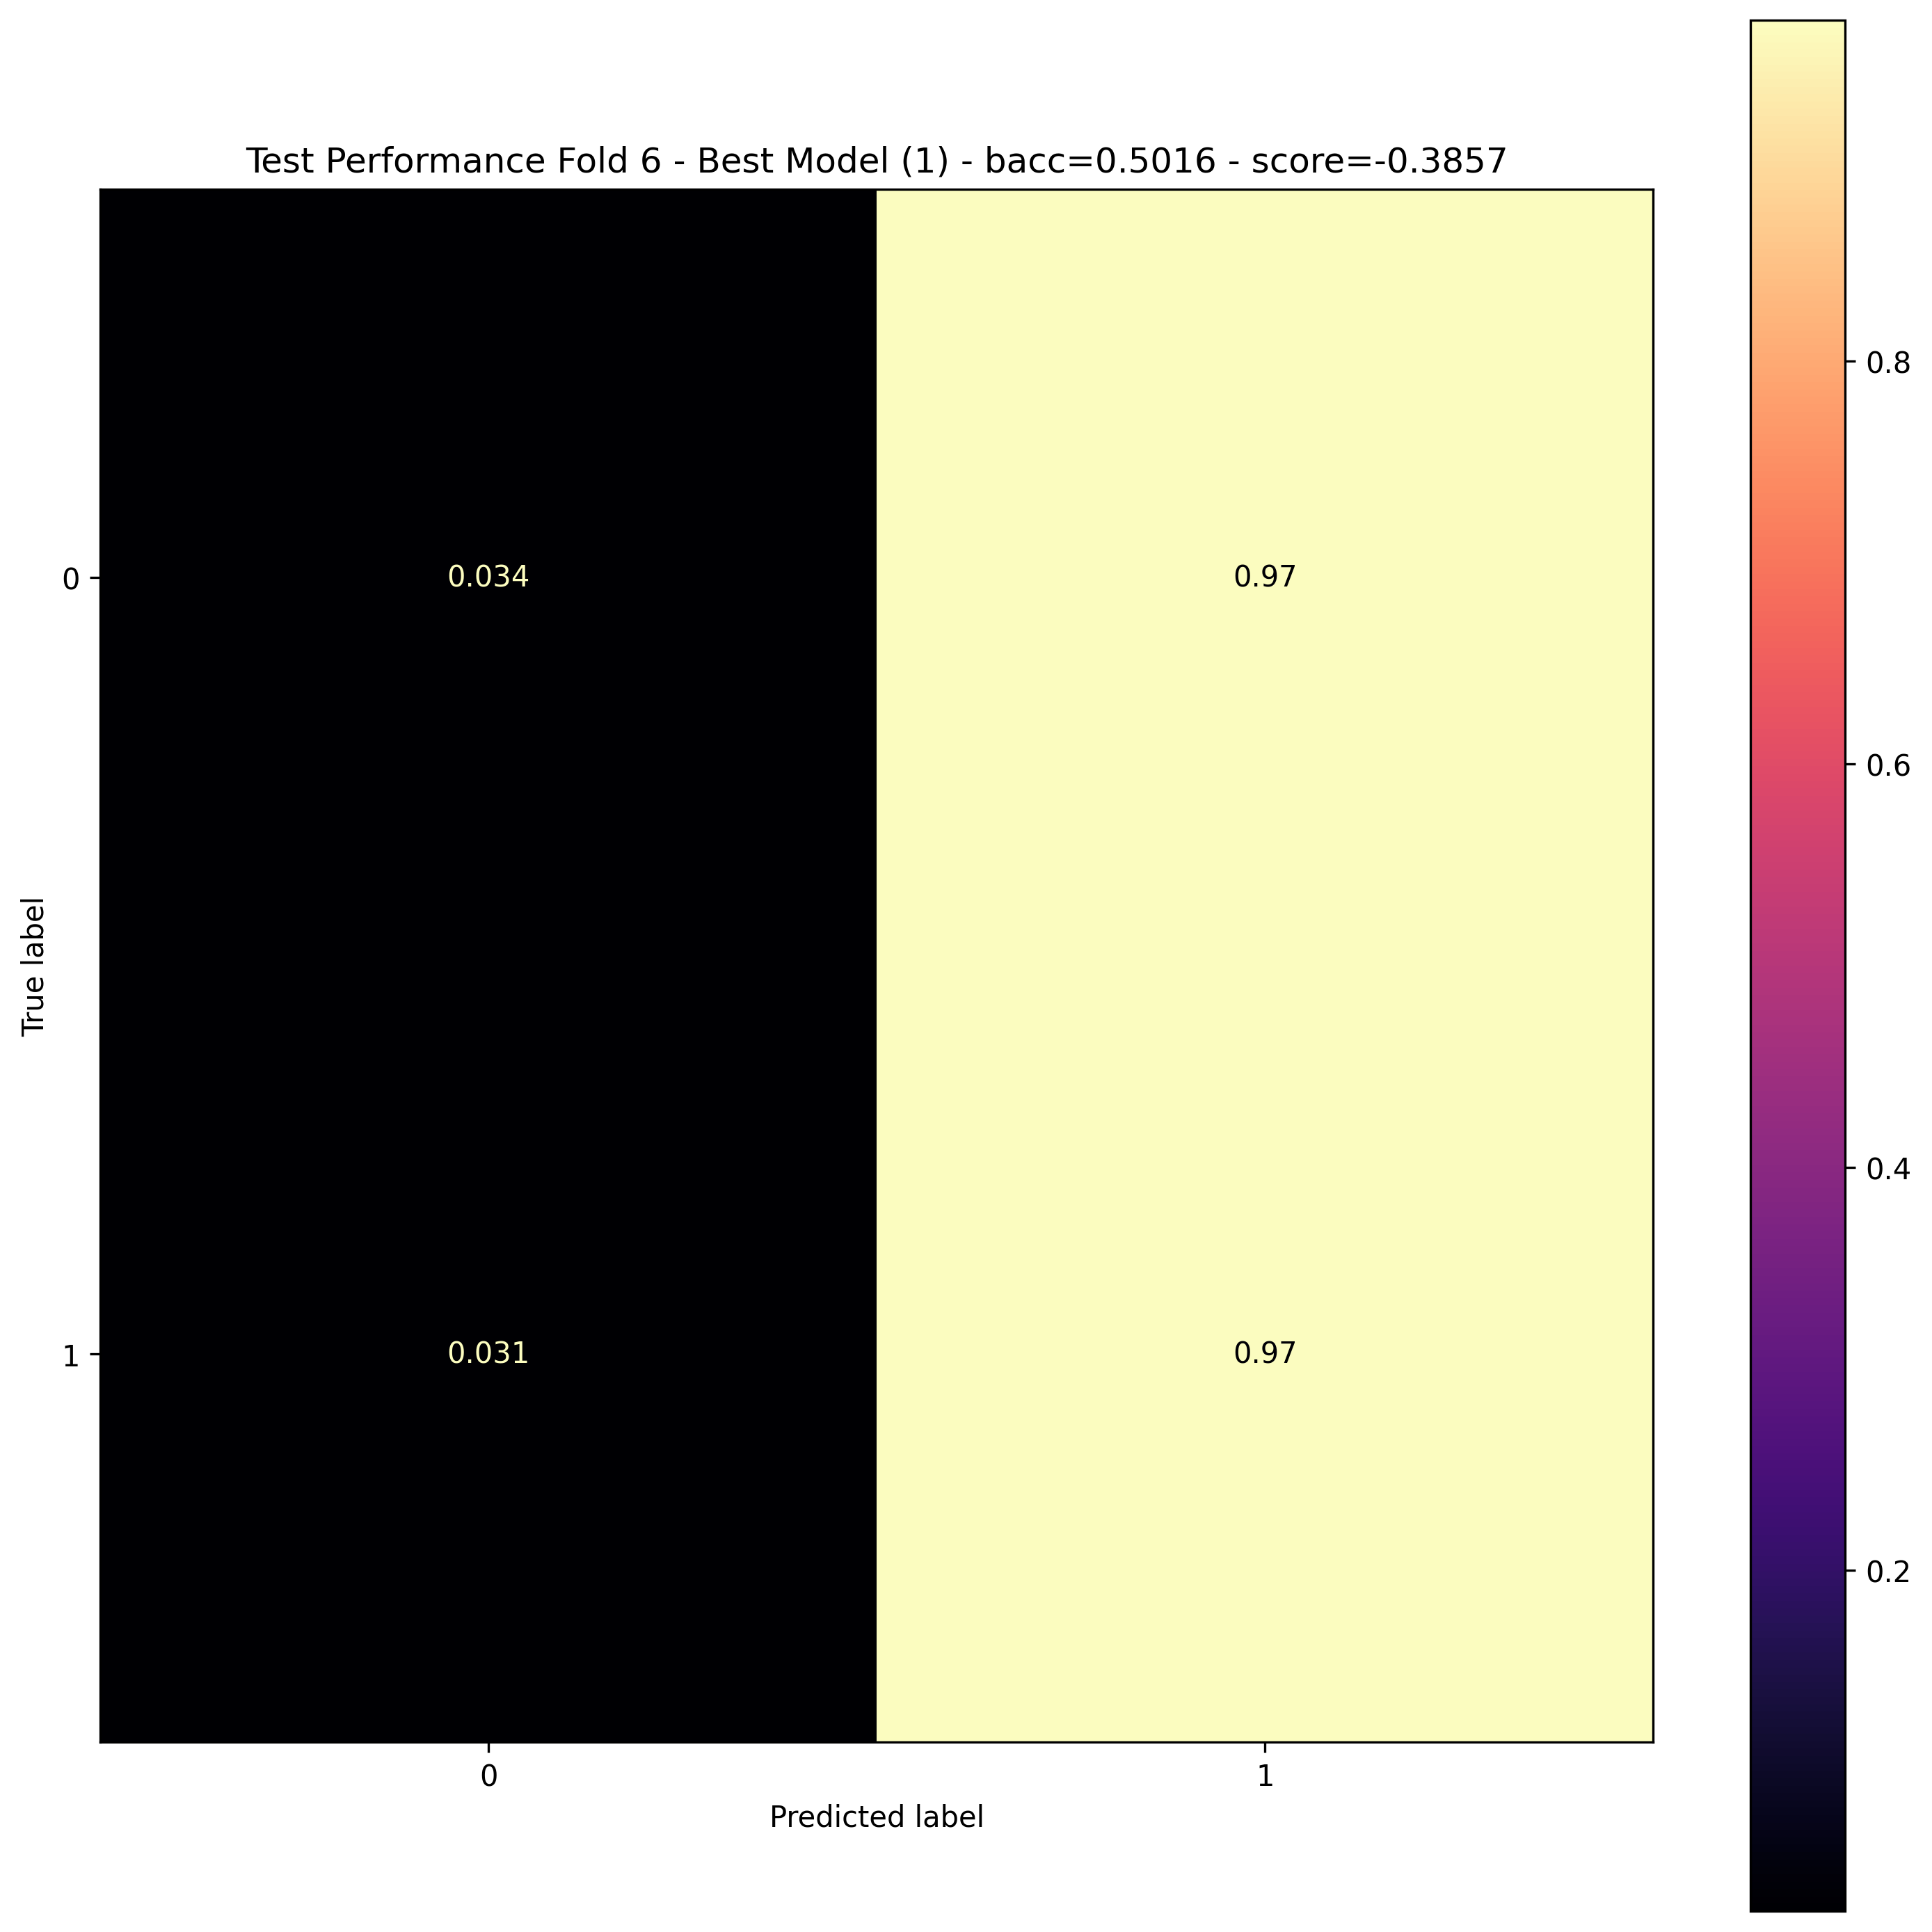

CV Folds:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 7/8 [00:46<00:06,  6.43s/it]

Best Model Test Metrics: avg_loss = 0.000087, num_samples = 24000, num_correct =  7372, acc = 0.307167, bacc = 0.501572, score = -0.385667
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-6-best eval-score=-0.4248 test-score=-0.3857"



Executing CV for fold 7
Training fold 7


#### Training ####
##################
AttentionClassifier with 105578 parameters, in_fnn: 59760, attention_stack: 43920, out_fnn: 1898
##################

train label counts = [59909, 24091]
eval label counts  = [ 8457,  3543]

loss weights                    = [ 0.50,  2.49]
eval loss weights (theoretical) = [ 0.50,  2.39]


Training Epoch   1/5  : lr = 1.00E-03, epoch =     1, avg_loss = 0.000082, num_samples = 84000, num_correct = 59910, acc = 0.713214, bacc = 0.500021, score = 0.426429
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000109, num_samples = 12000, num_correct =  8457, acc = 0.704750, bacc = 0.500000, score = 0.409500
Training Epoch   2/5  : lr = 1.00E-03, epoch 

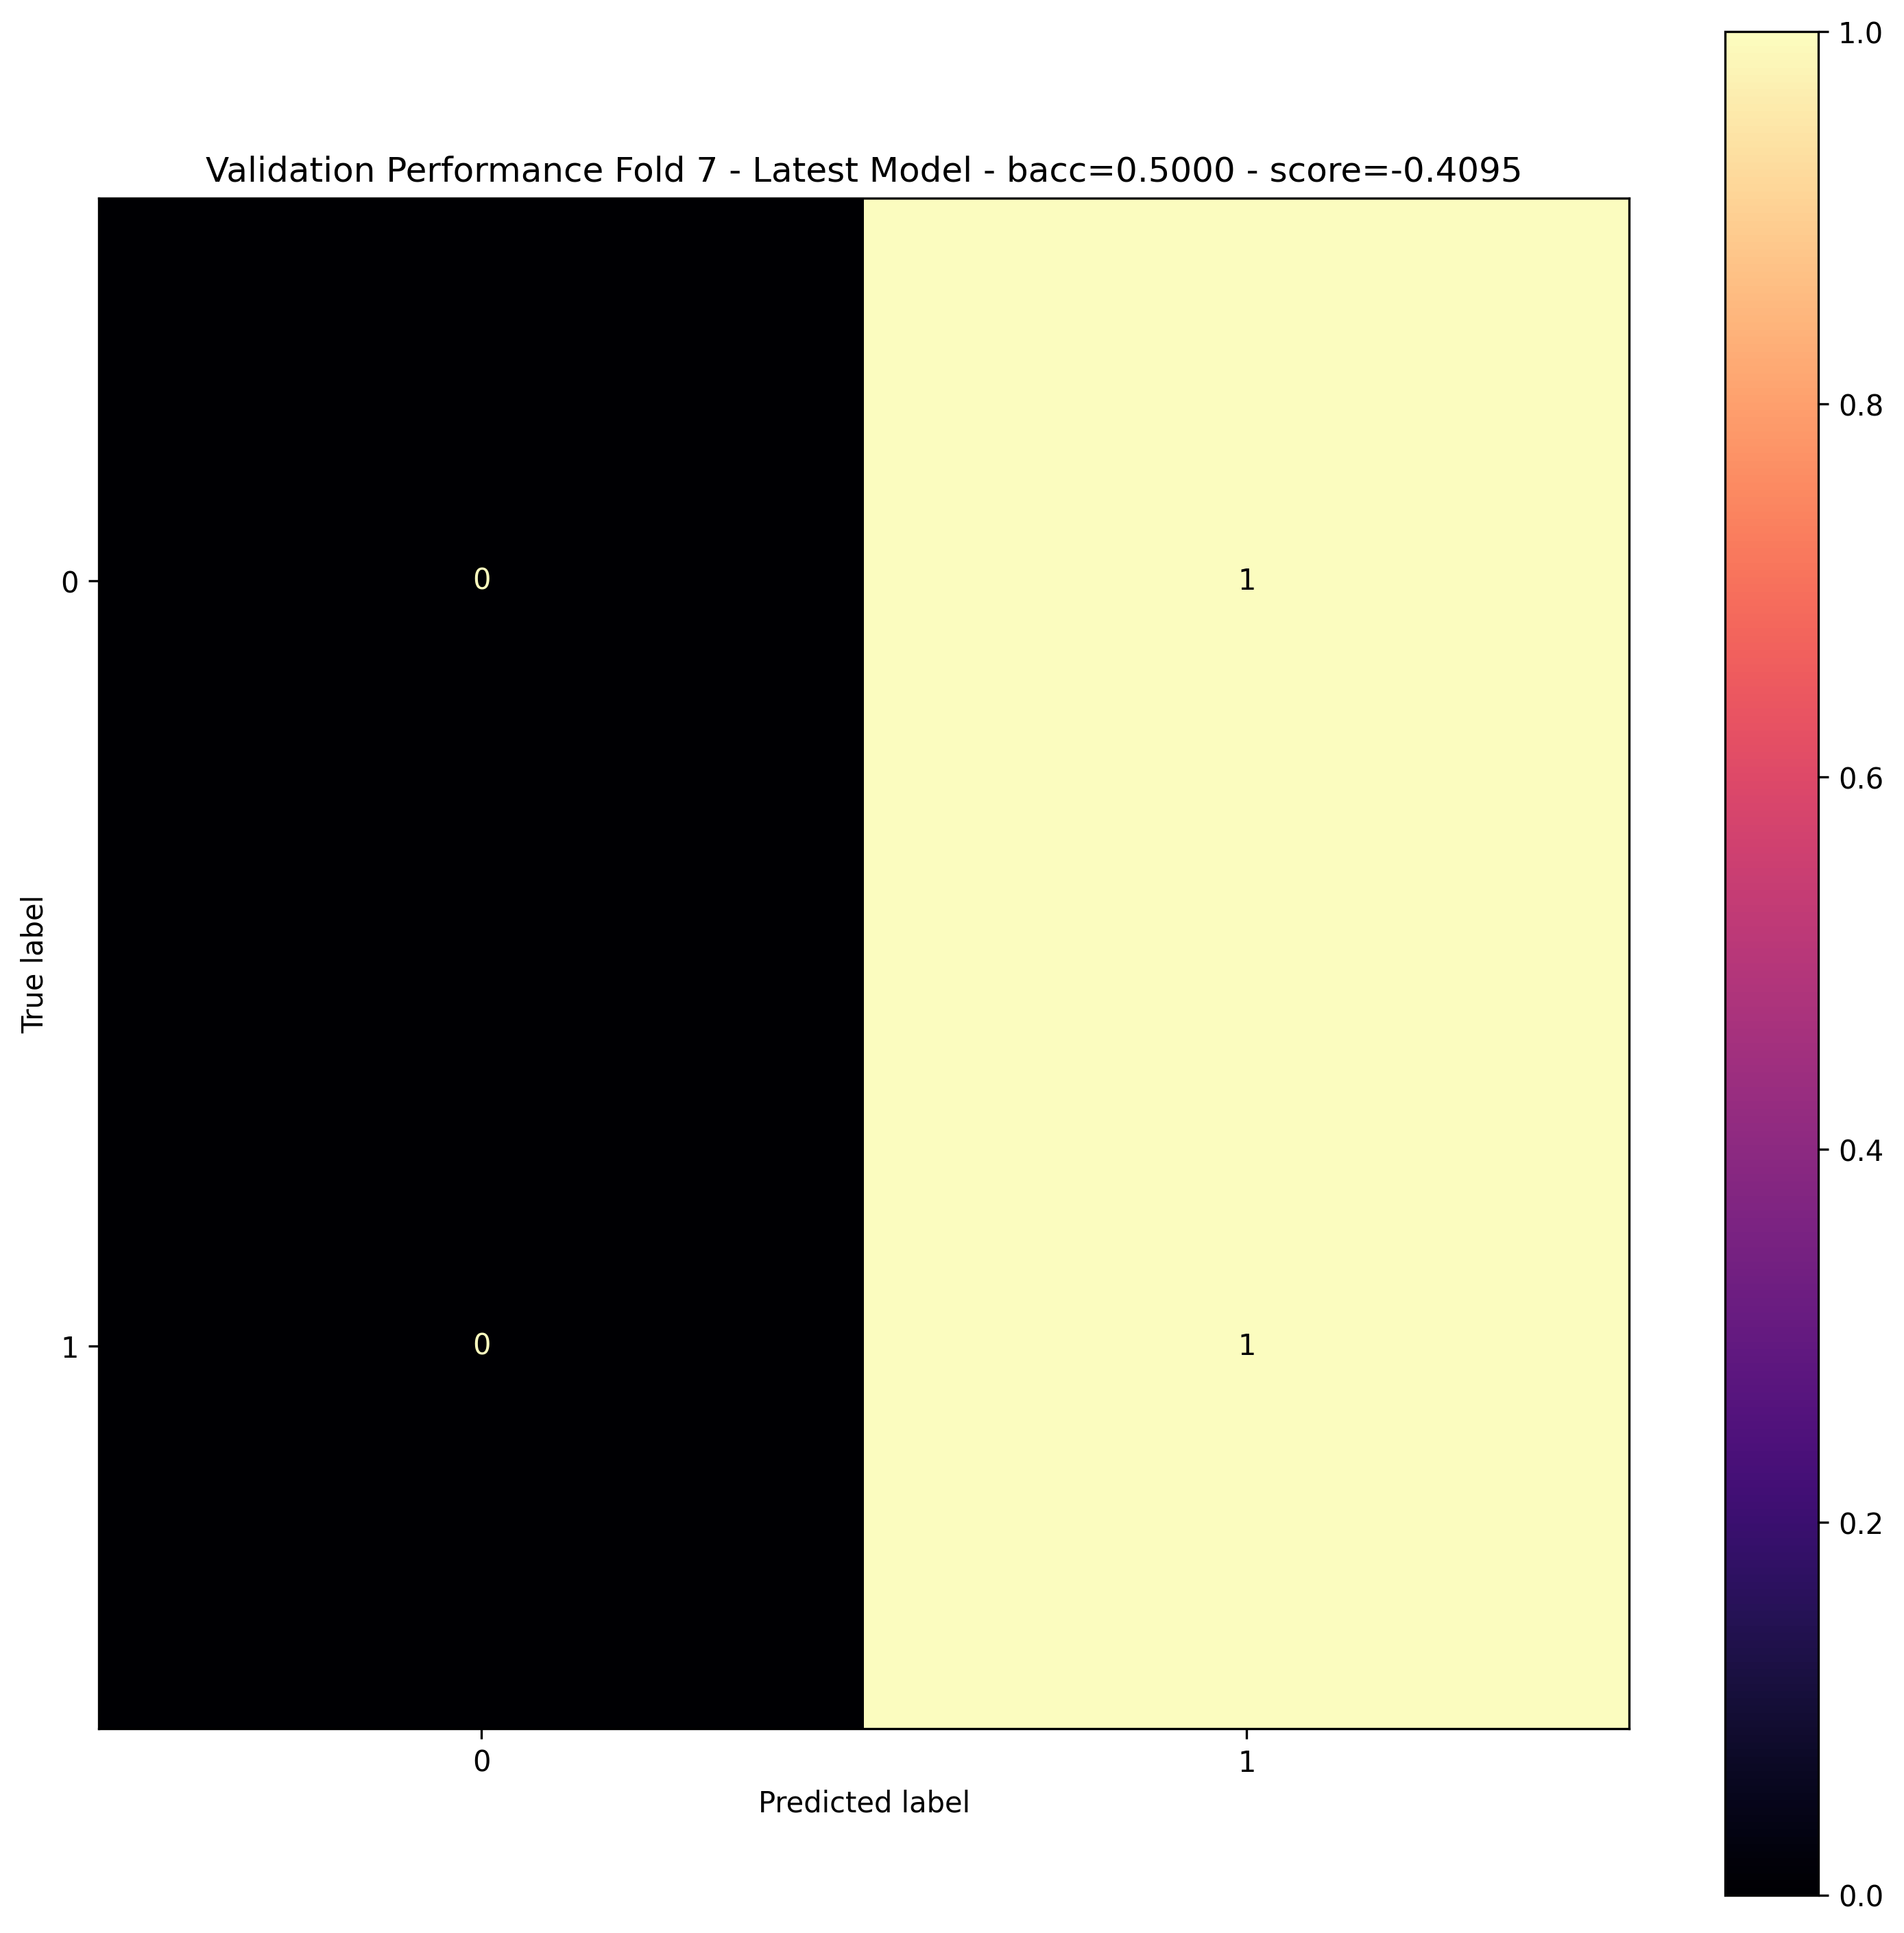

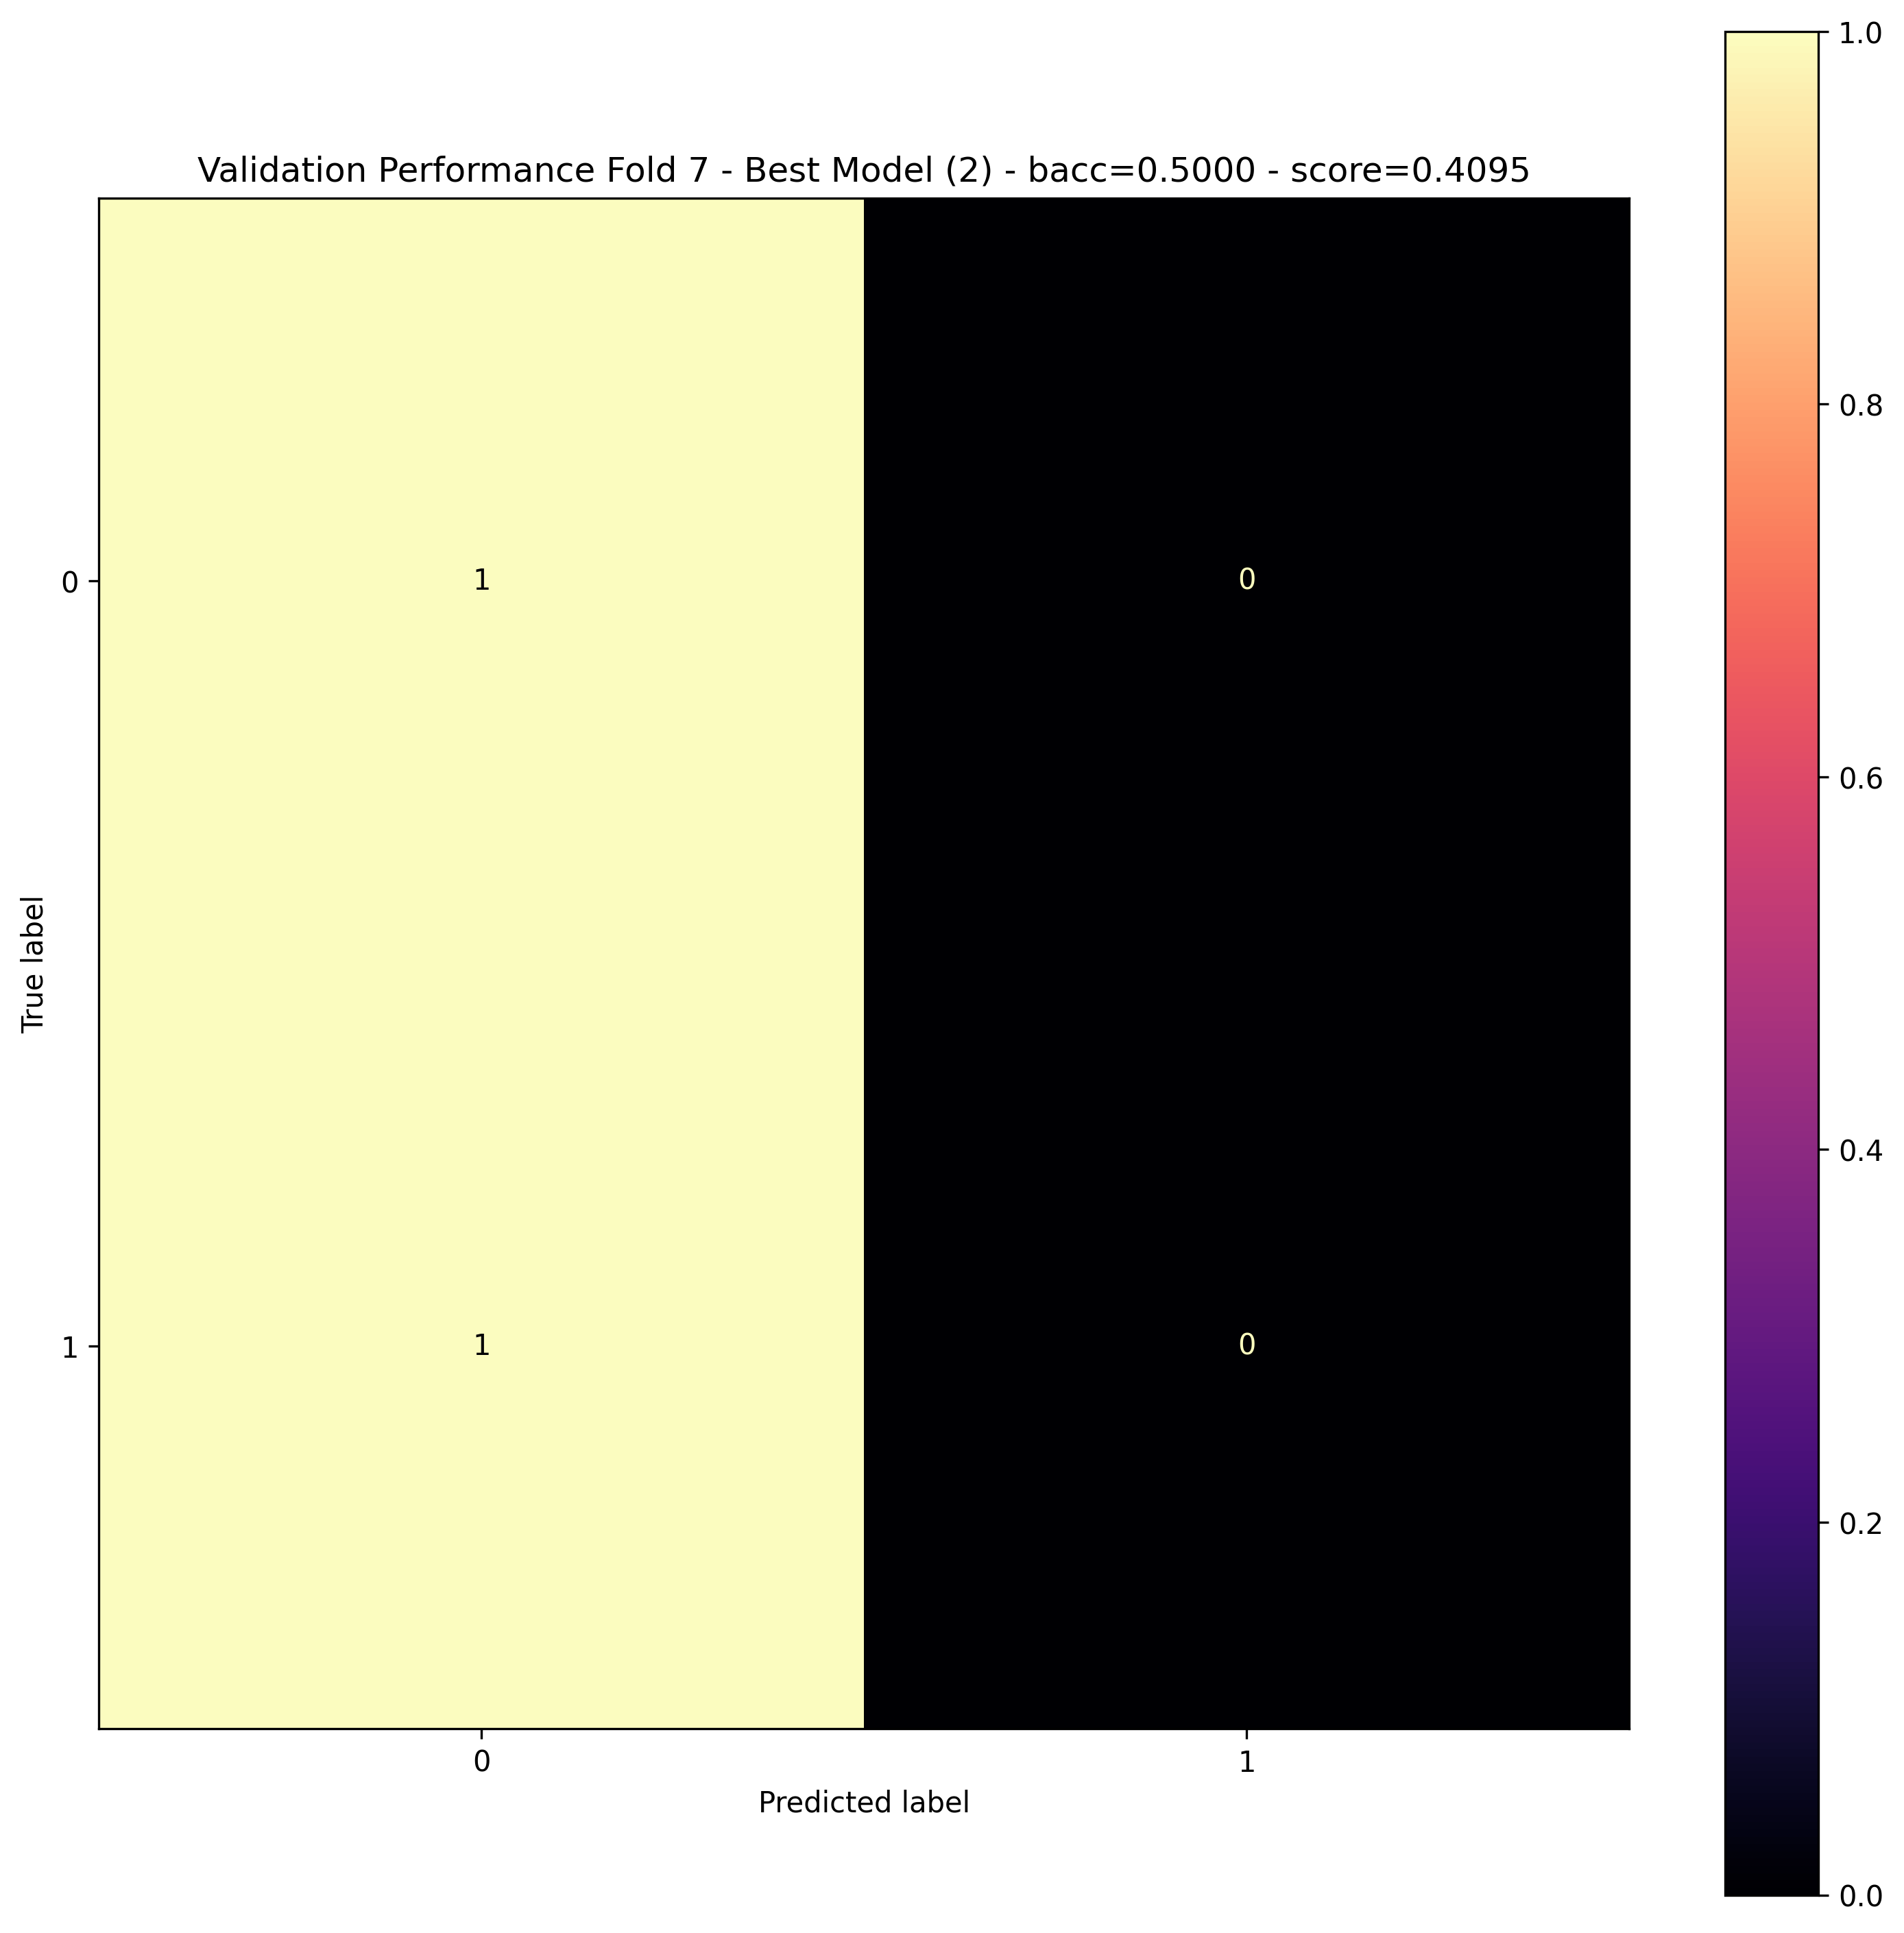


Testing fold 7


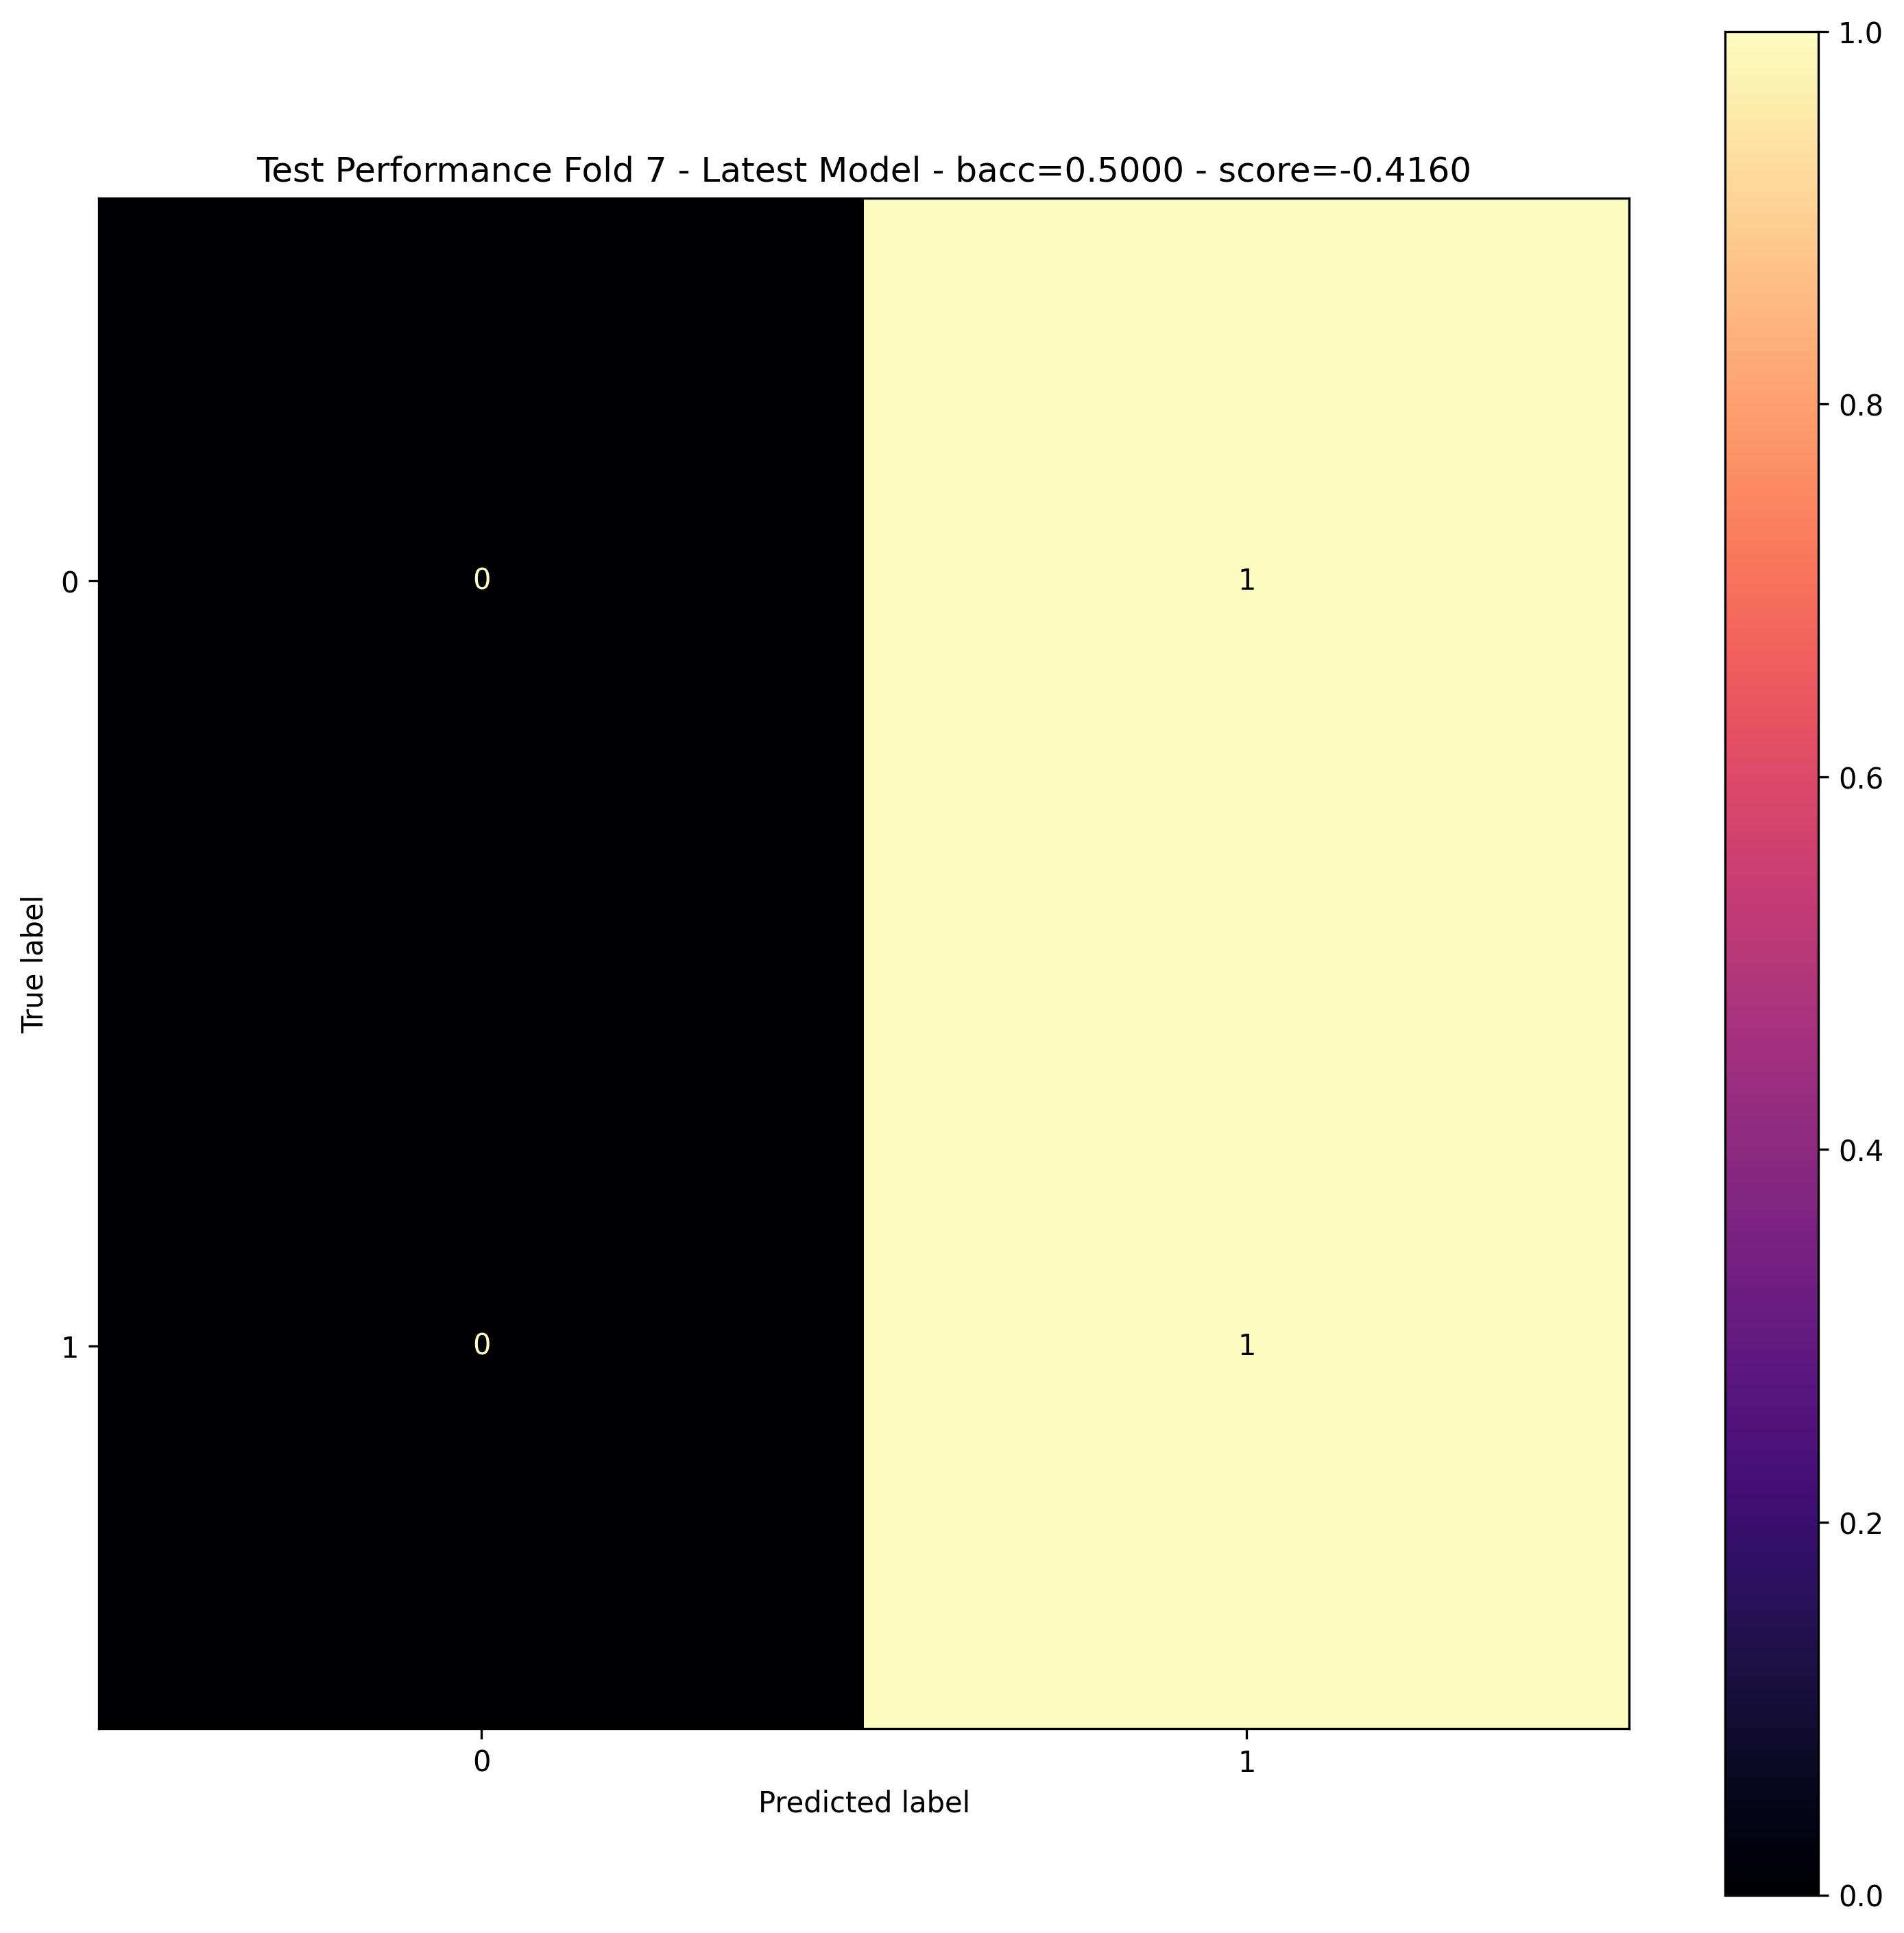

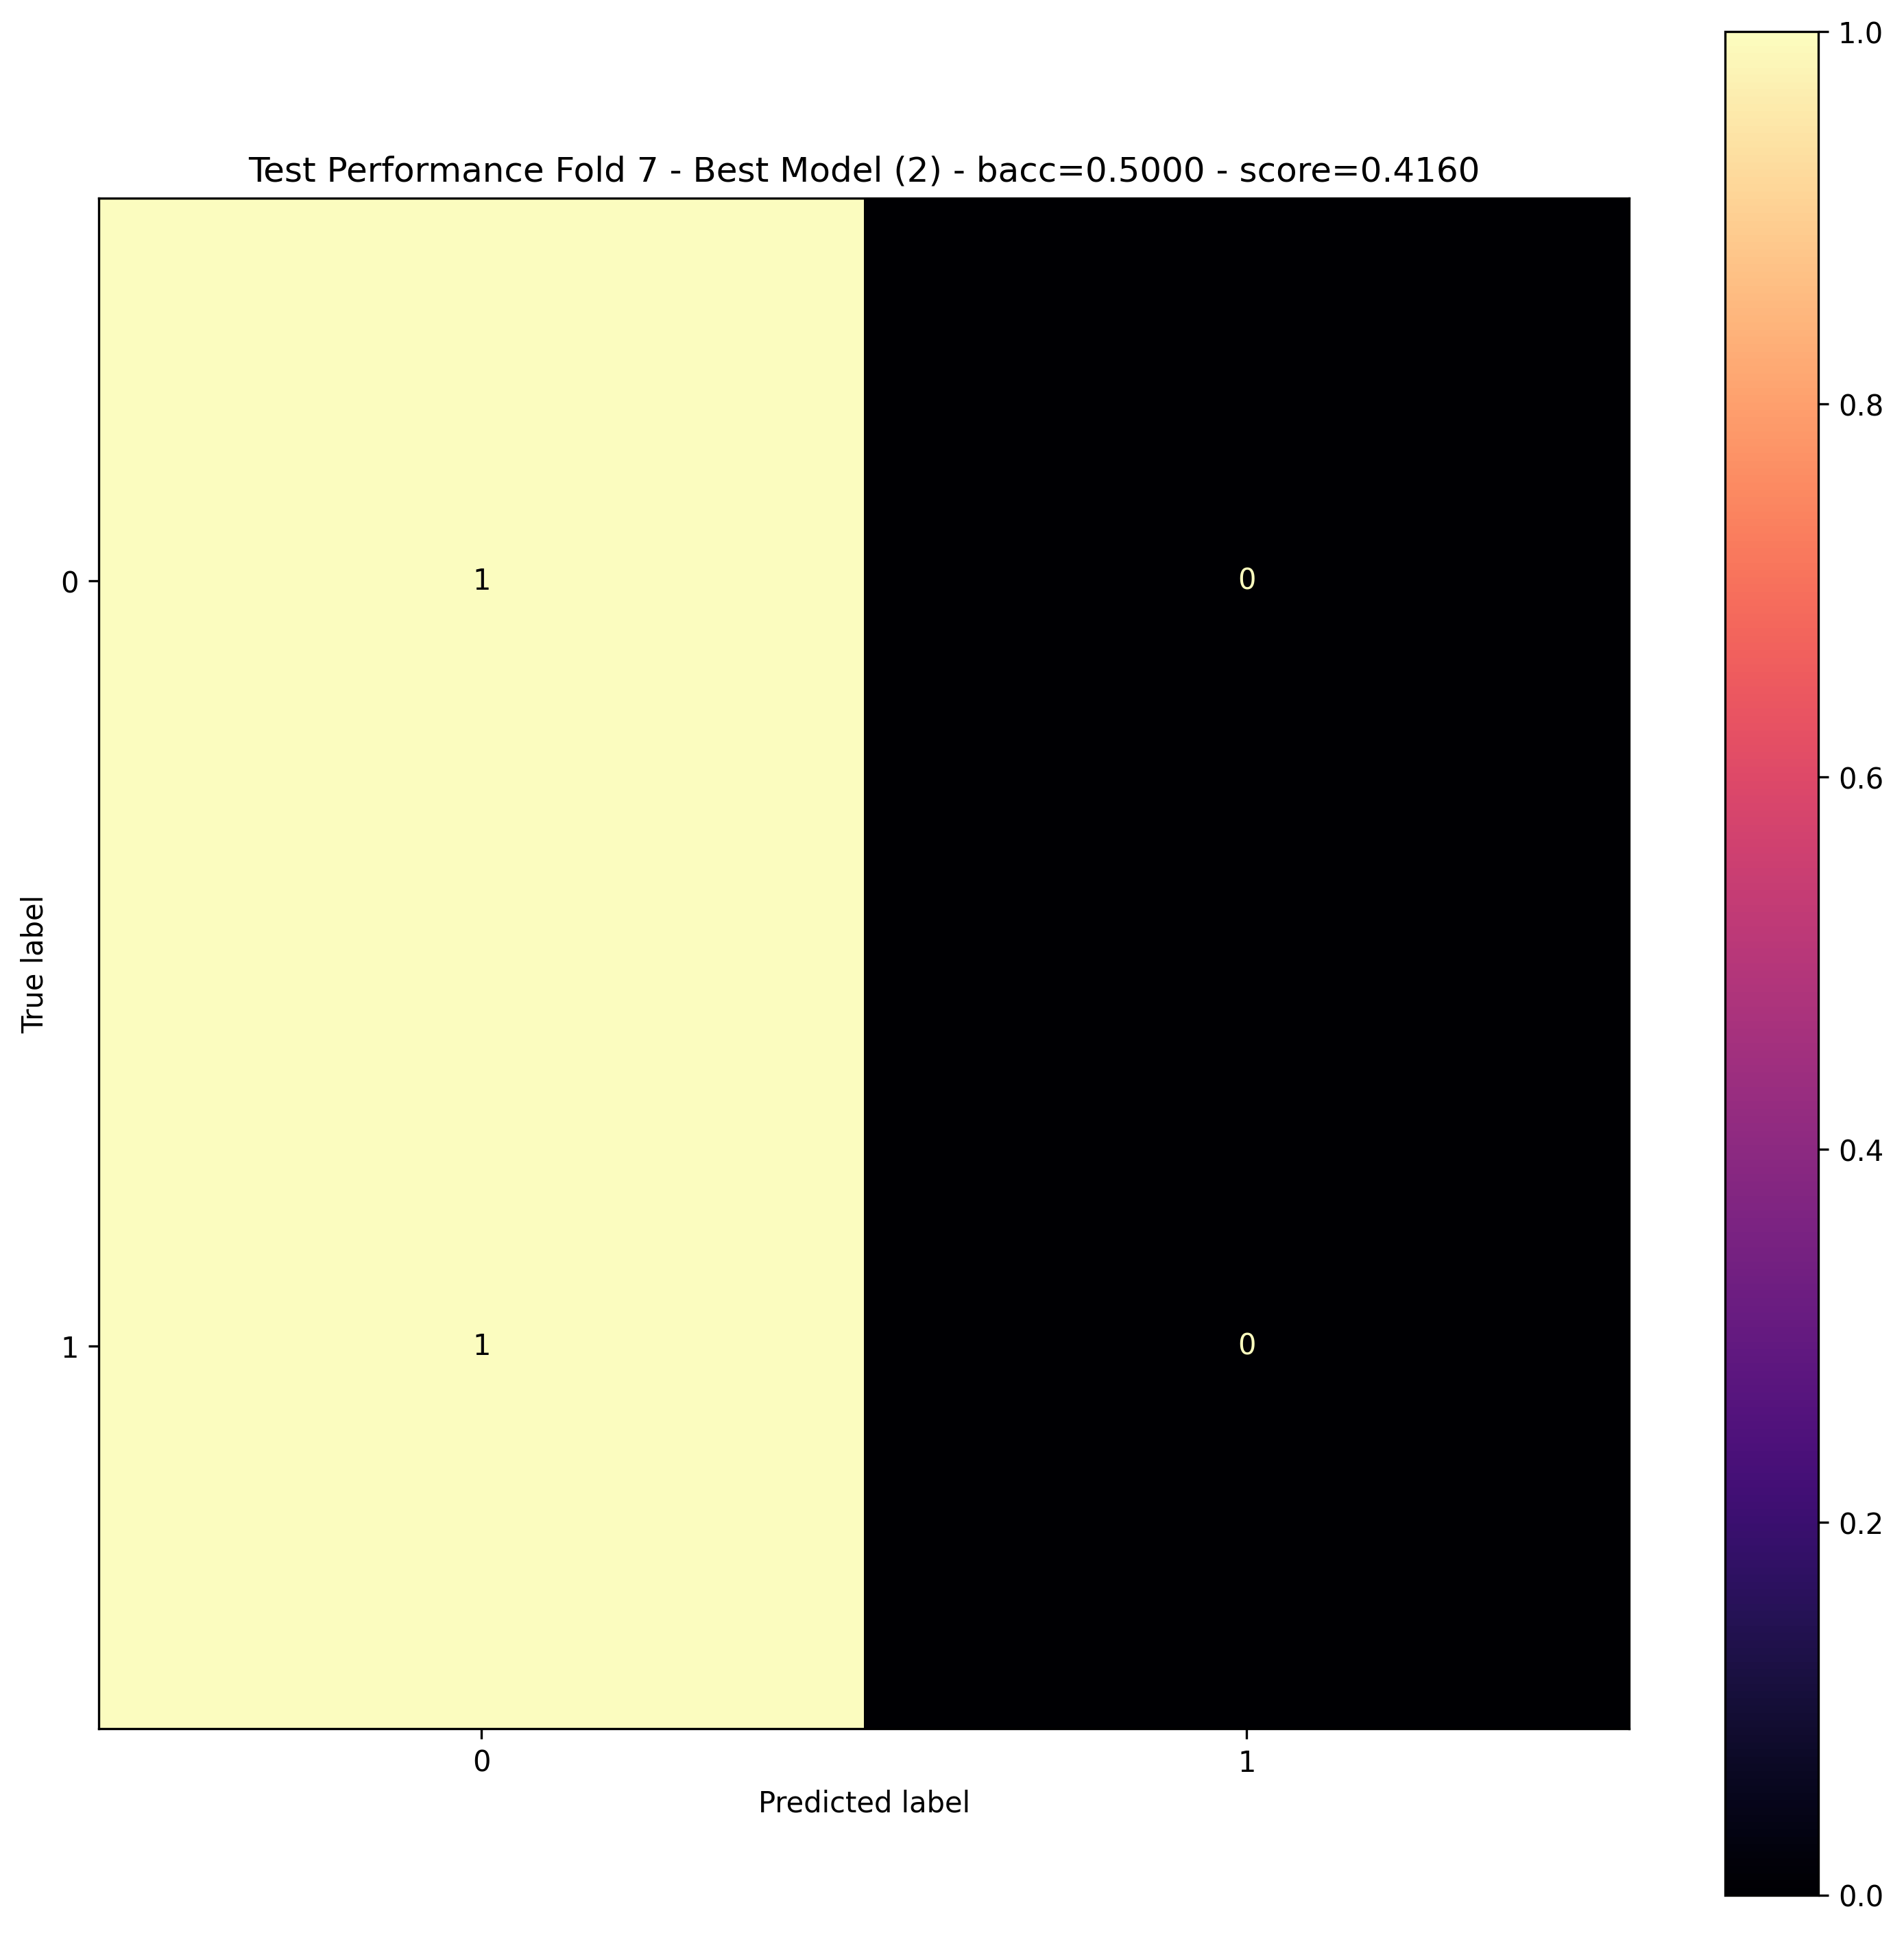

CV Folds: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.55s/it]

Best Model Test Metrics: avg_loss = 0.000086, num_samples = 24000, num_correct = 16992, acc = 0.708000, bacc = 0.500000, score = 0.416000
Saved model with scaler as "bird_no_bird_classifier cv2023-06-11_13.50 fold-7-best eval-score=0.4095 test-score=0.4160"


#################
#### Metrics ####
#################


cv_average_best_best_models_eval_metrics = epoch = 4.125000, avg_loss = 0.000143, num_samples = 12000.000000, num_correct = 4089.500000, acc = 0.340792, bacc = 0.499828, score = -0.318417 


cv_average_best_best_models_test_metrics = epoch = 4.125000, avg_loss = 0.000143, num_samples = 12000.000000, num_correct = 4089.500000, acc = 0.340792, bacc = 0.499828, score = -0.318417 




In [11]:
set_random_seed(43)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: AttentionClassifier(ac_hyper_parameters),
    training_hyper_parameters, 
    sequences_ds_train_binary_labels,
    sequences_ds_test_binary_labels,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='bird_no_bird_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

if best_models_metrics[0][2] is not None:
    cv_average_best_best_models_test_metrics = calculate_average_metrics([m[2] for m in best_models_metrics])
    print(f'{cv_average_best_best_models_test_metrics = } \n\n')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

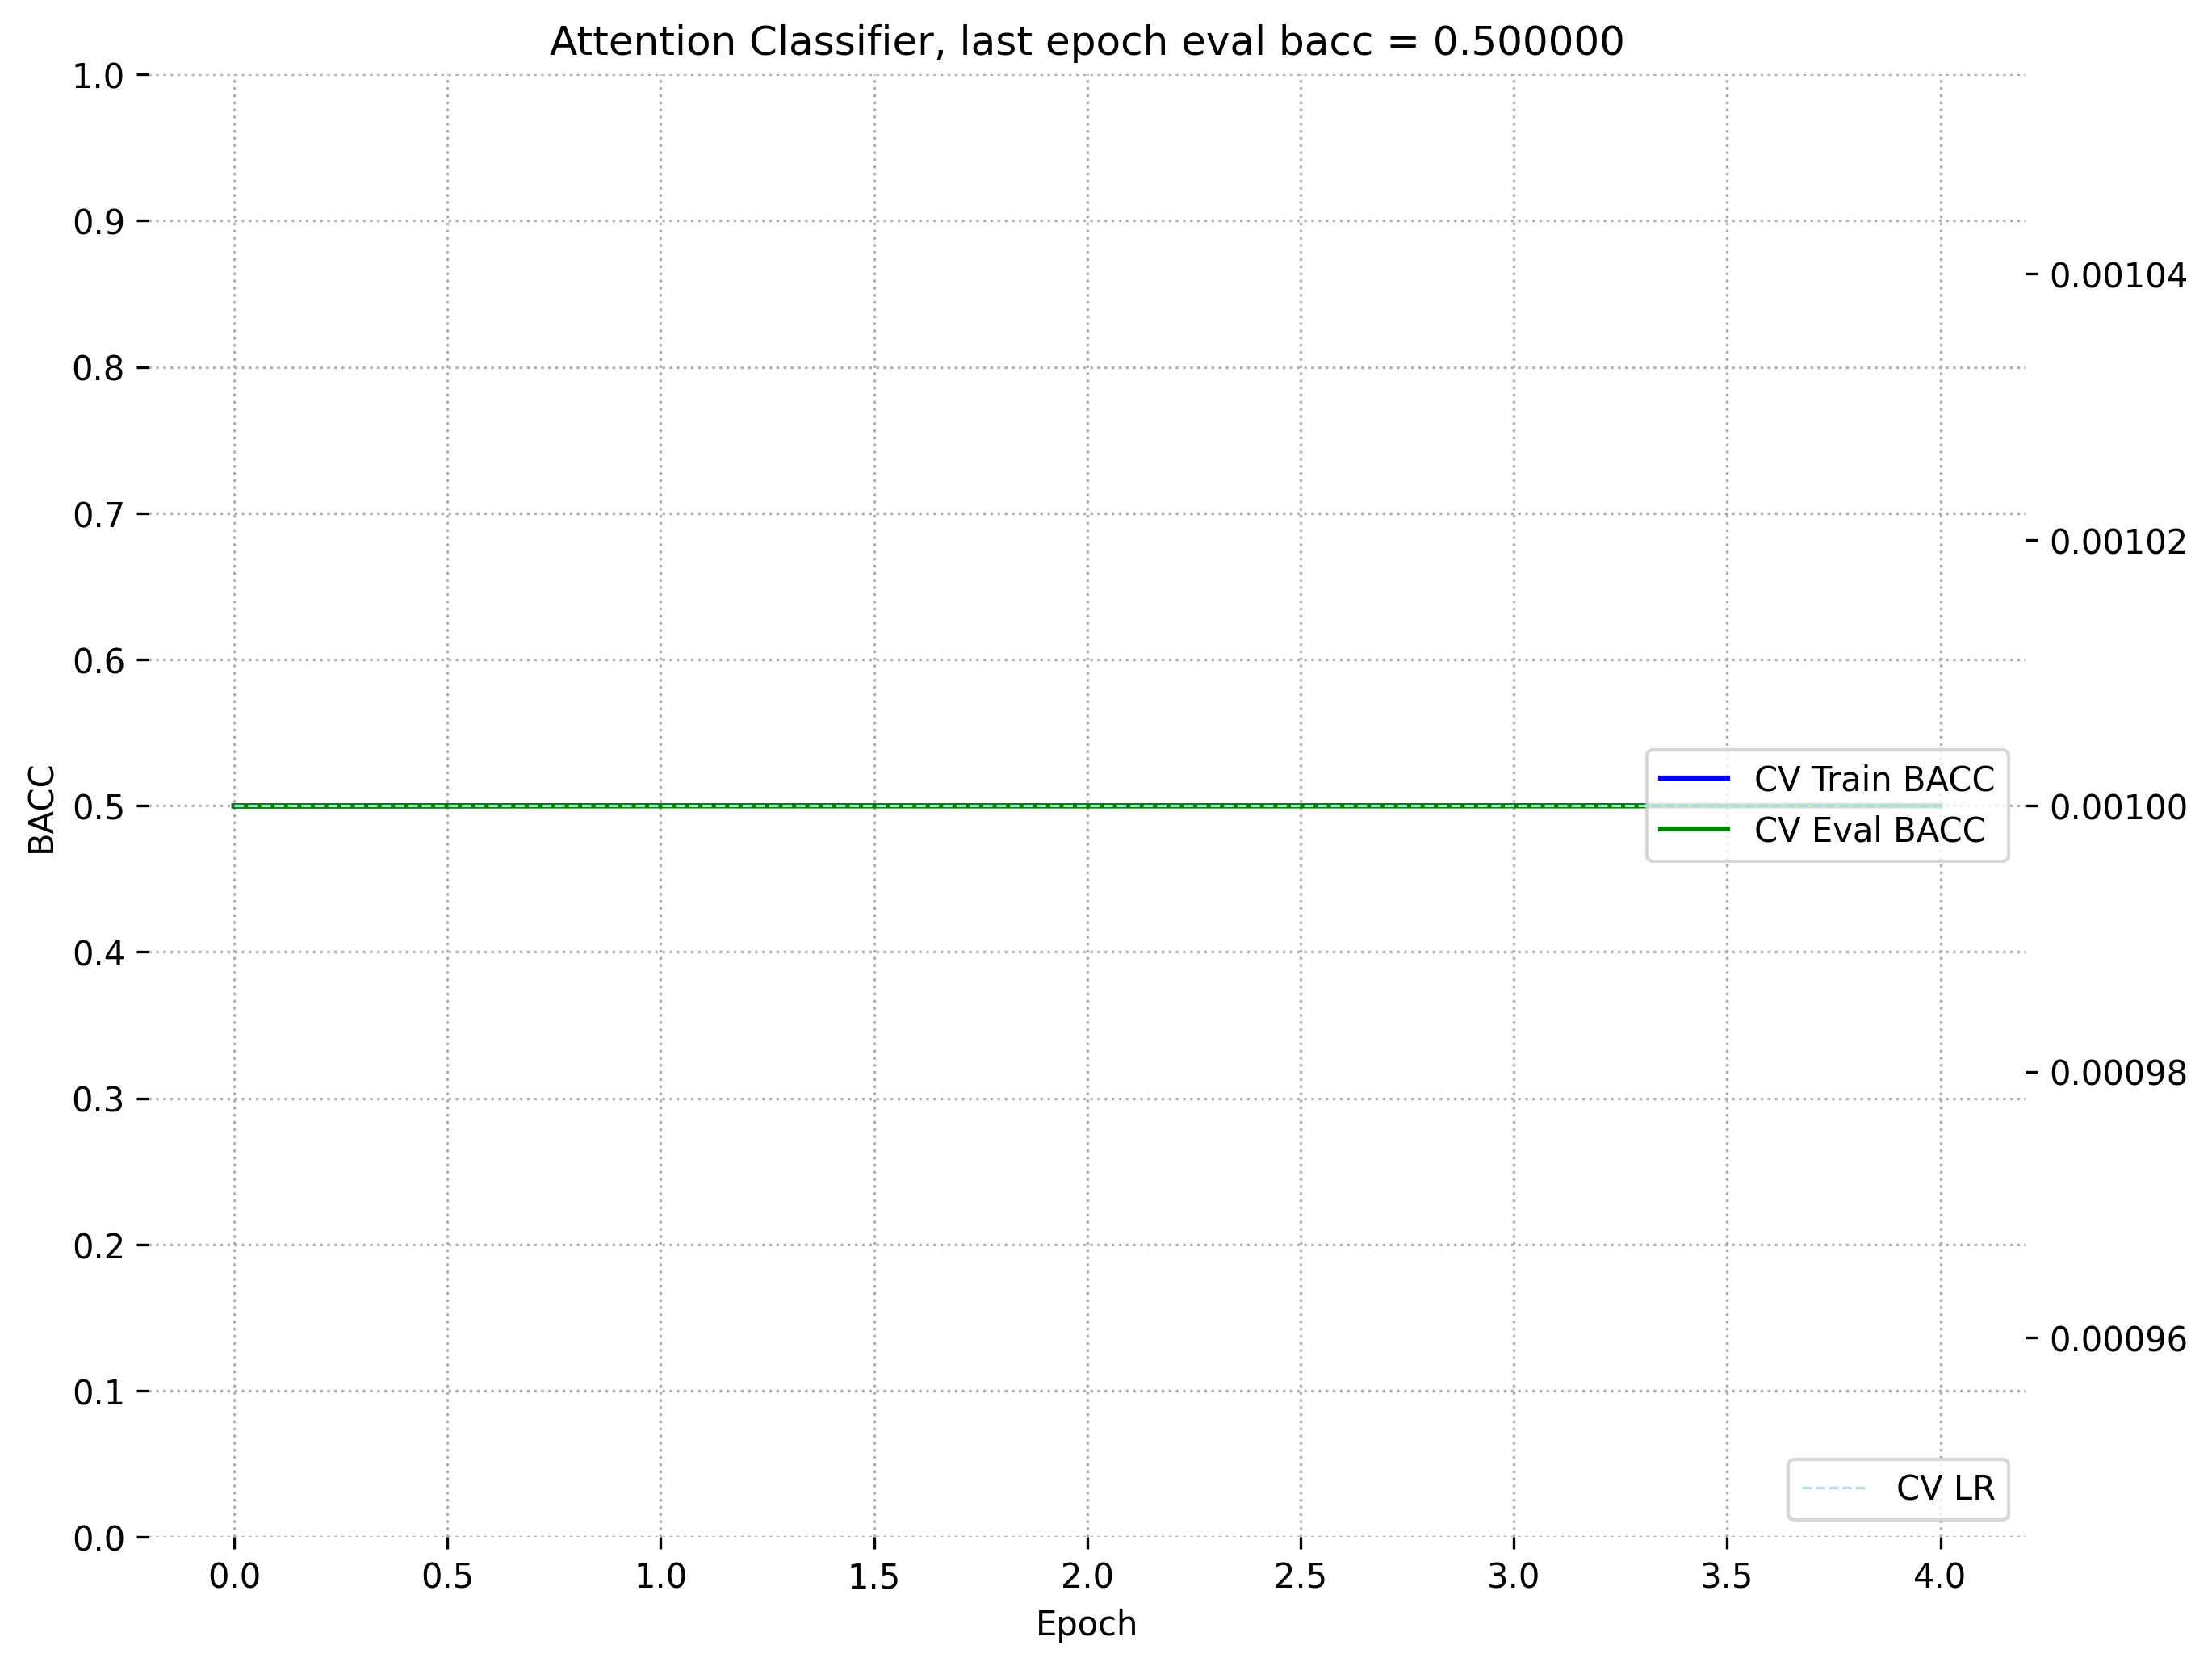

In [12]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')